In [2]:
# 0️⃣ NOTEBOOK SETUP & CONFIGURATION
# ------------------------------------------------------------
# Purpose: Standardize environment, paths, logging, constants,
# and lightweight helper utilities we’ll reuse across the notebook.
# ------------------------------------------------------------

# 0.1 Imports
from __future__ import annotations
import os
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import warnings
import logging
import math
import numpy as np
import pandas as pd

# 0.2 Display / pandas options
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# 0.3 Warnings (keep notebook clean)
warnings.filterwarnings("ignore")

# 0.4 Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 0.5 Paths (assumes files are in the same directory as the notebook)
BASE_DIR = Path(".").resolve()
DATA_DIR = BASE_DIR  # same folder as notebook
CONFIG = {
    "sku_file": DATA_DIR / "SKU_Wise_Data.xlsx",
    "inbound_file": DATA_DIR / "DC_Inbound.xlsx",
    "outbound_file": DATA_DIR / "DC_Outbound.xlsx",
    "network_file": DATA_DIR / "Network_Map.xlsx",
}

# 0.6 Sanity check files exist
for k, v in CONFIG.items():
    if not Path(v).exists():
        raise FileNotFoundError(f"Missing required file for '{k}': {v}")

# 0.7 Logging (concise INFO logs)
logger = logging.getLogger("case_notebook")
logger.setLevel(logging.INFO)
if not logger.handlers:
    _h = logging.StreamHandler()
    _fmt = logging.Formatter("[%(levelname)s] %(message)s")
    _h.setFormatter(_fmt)
    logger.addHandler(_h)
logger.info("Notebook setup initialized.")

# 0.8 Business/Model Assumptions (centralized)
ASSUMPTIONS = {
    # Replenishment cadence: Warehouses place orders anytime; fulfillment occurs weekly
    "replenishment_cadence_days": 7,
    # Lead time variability by region (as coefficient of variation on mean LT)
    "lead_time_variability": {
        "North America": 0.10,
        "Europe": 0.10,
        "Asia": 0.15,
    },
    # Default target cycle service levels (can be tuned later per ABC–XYZ)
    # e.g., A: 97.5%, B: 95%, C: 90% — these are placeholders for later refinement
    "default_csl_targets": {
        "A": 0.975,
        "B": 0.950,
        "C": 0.900,
    },
    # Currency
    "currency": "€",
    # Timezone / calendar
    "timezone": "UTC",
    "date_grain": "M",  # monthly in provided data
}

# 0.9 Lightweight helpers (kept tiny on purpose)

def coerce_numeric(series: pd.Series) -> pd.Series:
    """
    Convert strings with currency symbols, commas, dashes to numeric.
    Leaves NaN where not parseable.
    """
    if series.dtype.kind in "biufc":
        return series
    s = series.astype(str).str.strip()
    # Treat '-' or empty as NaN
    s = s.replace({"-": np.nan, "": np.nan, "None": np.nan})
    # Remove currency symbols and thousand separators
    s = s.str.replace("€", "", regex=False)
    s = s.str.replace(",", "", regex=False)
    # Remove stray percent sign (handled separately if needed)
    s = s.str.replace("%", "", regex=False)
    return pd.to_numeric(s, errors="coerce")

def coerce_percentage(series: pd.Series) -> pd.Series:
    """
    Convert share columns like '88%' or 0.88 to float in [0,1].
    """
    s = series.copy()
    if s.dtype.kind not in "biufc":
        s = s.astype(str).str.strip()
        s = s.replace({"-": np.nan, "": np.nan, "None": np.nan})
        has_pct = s.str.contains("%", na=False)
        s_pct = pd.to_numeric(s.str.replace("%", "", regex=False), errors="coerce") / 100.0
        s_num = pd.to_numeric(s, errors="coerce")
        s = np.where(has_pct, s_pct, s_num)
    # normalize >1 to 0–1 if clearly percent coded as 88 not 0.88
    s = pd.to_numeric(s, errors="coerce")
    s = np.where((s > 1) & (s <= 100), s / 100.0, s)
    return pd.to_numeric(s, errors="coerce")

def standardize_month_col(df: pd.DataFrame, col: str = "Month") -> pd.DataFrame:
    """
    Ensure Month is pandas Period (Month) and add a datetime 'MonthStart' column for joins/plots.
    """
    out = df.copy()
    out[col] = pd.to_datetime(out[col], errors="coerce").dt.to_period("M")
    out["MonthStart"] = out[col].dt.to_timestamp(how="start")
    return out

def read_excel_safely(path: Path, **kwargs) -> pd.DataFrame:
    """
    Wrapper to read Excel with consistent dtype handling.
    """
    df = pd.read_excel(path, **kwargs)
    return df

def quick_shape(df: pd.DataFrame, name: str) -> None:
    logger.info(f"{name}: shape={df.shape[0]} rows × {df.shape[1]} cols")

# 0.10 Tiny environment echo (useful for reproducibility in competitions)
import sys, platform
logger.info(f"Python: {sys.version.split()[0]} | Pandas: {pd.__version__} | NumPy: {np.__version__}")
logger.info(f"Platform: {platform.system()} {platform.release()} | Base dir: {BASE_DIR}")
logger.info(f"Files: {[str(v) for v in CONFIG.values()]}")

print("Step 0 complete — environment, paths, assumptions, and helpers are ready.")


[INFO] Notebook setup initialized.
[INFO] Python: 3.12.4 | Pandas: 2.2.3 | NumPy: 1.26.4
[INFO] Platform: Windows 11 | Base dir: C:\Users\sinan\Desktop\Mckinsey\Final
[INFO] Files: ['C:\\Users\\sinan\\Desktop\\Mckinsey\\Final\\SKU_Wise_Data.xlsx', 'C:\\Users\\sinan\\Desktop\\Mckinsey\\Final\\DC_Inbound.xlsx', 'C:\\Users\\sinan\\Desktop\\Mckinsey\\Final\\DC_Outbound.xlsx', 'C:\\Users\\sinan\\Desktop\\Mckinsey\\Final\\Network_Map.xlsx']


Step 0 complete — environment, paths, assumptions, and helpers are ready.


In [4]:
# 1️⃣ DATA LOADING & CLEANING — Part A: SKU_Wise_Data.xlsx
# ------------------------------------------------------------
# Outputs:
#   - sku_df  (cleaned dataframe in memory)
#   - a small audit printout for quick verification
# ------------------------------------------------------------

# 1.1 Load raw
sku_df = read_excel_safely(CONFIG["sku_file"])

# 1.2 Normalize column names (strip spaces, unify common names)
sku_df.columns = [c.strip() for c in sku_df.columns]

# 1.3 Standardize Month to Period[M] and MonthStart
if "Month" not in sku_df.columns:
    raise KeyError("Expected 'Month' column in SKU_Wise_Data.xlsx")
sku_df = standardize_month_col(sku_df, col="Month")

# 1.4 Clean string/categorical columns (trim)
for col in ["Region", "Location", "Location Type", "SKU", "Category"]:
    if col in sku_df.columns:
        sku_df[col] = sku_df[col].astype(str).str.strip()

# 1.5 Coerce numeric columns
num_cols = [
    "Forecast Units", "Sales Units",
    "Opening Stock Units", "Receipts Units", "Closing Stock Units",
    "Unit Cost (€)", "Unit Sales Price (€)"
]
for col in num_cols:
    if col in sku_df.columns:
        sku_df[col] = coerce_numeric(sku_df[col])

# 1.6 Quick shape log
quick_shape(sku_df, "SKU_Wise_Data (post-clean)")

# 1.7 Basic integrity checks (non-fatal; they print warnings if oddities found)
expected_regions = {"Asia", "Europe", "North America"}
expected_loc_types = {"Warehouse", "DC"}
expected_categories = {"Accessories", "Apparel", "Shoes"}

problems = []

if not set(sku_df["Region"].unique()).issubset(expected_regions):
    problems.append(f"Unexpected Region values: {sorted(set(sku_df['Region'].unique()) - expected_regions)}")

if "Location Type" in sku_df.columns and not set(sku_df["Location Type"].unique()).issubset(expected_loc_types):
    problems.append(f"Unexpected Location Type values: {sorted(set(sku_df['Location Type'].unique()) - expected_loc_types)}")

if not set(sku_df["Category"].unique()).issubset(expected_categories):
    problems.append(f"Unexpected Category values: {sorted(set(sku_df['Category'].unique()) - expected_categories)}")

# 1.8 Nulls & basic range checks on key numeric columns
null_summary = sku_df[num_cols].isna().sum().sort_values(ascending=False)
neg_checks = {}
for col in ["Forecast Units", "Sales Units", "Opening Stock Units", "Receipts Units", "Closing Stock Units"]:
    if col in sku_df.columns:
        neg_ct = (sku_df[col] < 0).sum()
        neg_checks[col] = int(neg_ct)

# 1.9 Mini audit summary
print("\n=== SKU_Wise_Data — MINI AUDIT ===")
print("Rows:", len(sku_df))
print("Time range:", sku_df["Month"].min(), "→", sku_df["Month"].max())
print("\nUnique counts:")
for c in ["Region", "Location", "Location Type", "SKU", "Category"]:
    if c in sku_df.columns:
        print(f"  {c}: {sku_df[c].nunique()}")

print("\nTop 5 rows:")
display(sku_df.head(5))

print("\nNulls in numeric columns:")
display(null_summary.to_frame("null_count").T)

print("\nNegative value checks (counts):")
display(pd.Series(neg_checks, name="neg_counts"))

if problems:
    print("\n[WARN] Potential categorical anomalies detected:")
    for p in problems:
        print(" -", p)
else:
    print("\nCategorical values match expected sets.")

# 1.10 Quick dtypes snapshot
print("\nDtypes snapshot:")
display(sku_df.dtypes.to_frame("dtype").T)

# 1.11 Save an ordered column list for future reference (optional)
sku_cols_order = [
    "Month", "MonthStart", "Region", "Location", "Location Type",
    "SKU", "Category",
    "Forecast Units", "Sales Units",
    "Opening Stock Units", "Receipts Units", "Closing Stock Units",
    "Unit Cost (€)", "Unit Sales Price (€)"
]
sku_cols_order = [c for c in sku_cols_order if c in sku_df.columns]
sku_df = sku_df[sku_cols_order]

print("\n✅ SKU_Wise_Data loaded & cleaned (stored as sku_df).")


[INFO] SKU_Wise_Data (post-clean): shape=64800 rows × 14 cols



=== SKU_Wise_Data — MINI AUDIT ===
Rows: 64800
Time range: 2024-01 → 2024-12

Unique counts:
  Region: 3
  Location: 18
  Location Type: 2
  SKU: 300
  Category: 3

Top 5 rows:


,Month,Region,Location,Location Type,SKU,Category,Forecast Units,Sales Units,Opening Stock Units,Receipts Units,Closing Stock Units,Unit Cost (€),Unit Sales Price (€),MonthStart
0,2024-01,North America,WH_01,Warehouse,SKU_0001,Apparel,22,53,262,69,278,20,45,2024-01-01
1,2024-01,North America,WH_01,Warehouse,SKU_0002,Apparel,27,42,151,36,145,20,45,2024-01-01
2,2024-01,North America,WH_01,Warehouse,SKU_0003,Apparel,1,42,280,37,275,20,45,2024-01-01
3,2024-01,North America,WH_01,Warehouse,SKU_0004,Shoes,24,66,246,52,232,45,95,2024-01-01
4,2024-01,North America,WH_01,Warehouse,SKU_0005,Shoes,42,97,63,80,46,45,95,2024-01-01



Nulls in numeric columns:


,Forecast Units,Sales Units,Opening Stock Units,Receipts Units,Closing Stock Units,Unit Cost (€),Unit Sales Price (€)
null_count,0,0,0,0,0,0,0



Negative value checks (counts):


Forecast Units         0
Sales Units            0
Opening Stock Units    0
Receipts Units         0
Closing Stock Units    0
Name: neg_counts, dtype: int64


Categorical values match expected sets.

Dtypes snapshot:


,Month,Region,Location,Location Type,SKU,Category,Forecast Units,Sales Units,Opening Stock Units,Receipts Units,Closing Stock Units,Unit Cost (€),Unit Sales Price (€),MonthStart
dtype,period[M],object,object,object,object,object,int64,int64,int64,int64,int64,int64,int64,datetime64[ns]



✅ SKU_Wise_Data loaded & cleaned (stored as sku_df).


In [6]:
# 1️⃣ DATA LOADING & CLEANING — Part B: DC_Inbound.xlsx
# ------------------------------------------------------------
# Outputs:
#   - inbound_df (cleaned dataframe in memory)
#   - concise audit (shape, time range, uniques, nulls, share checks)
# ------------------------------------------------------------

# 1. Load raw
inbound_df = read_excel_safely(CONFIG["inbound_file"])

# 2. Normalize/uniquify column names (handles accidental duplicates like "DC")
def _uniquify(cols):
    seen = {}
    out = []
    for c in cols:
        base = str(c).strip()
        if base not in seen:
            seen[base] = 0
            out.append(base)
        else:
            seen[base] += 1
            out.append(f"{base}_{seen[base]}")
    return out

inbound_df.columns = _uniquify(inbound_df.columns)

# 3. Try to map expected columns (robust to minor name variations)
col_map_candidates = {
    "Month": ["Month"],
    "DC": ["DC", "From DC", "Assigned DC", "DC_Europe", "DC_0", "DC_1"],  # robust
    "Region": ["Region"],
    "SKU": ["SKU", "Sku"],
    "Category": ["Category"],
    "Supplier": ["Supplier"],
    "Supplier Country": ["Supplier Country", "SupplierCountry", "Origin Country"],
    "Inbound Units": ["Inbound Units", "Inbound_Units", "Inbound Qty"],
    "Supplier->DC Logistics Cost (€)": [
        "Supplier->DC Logistics Cost (€)", "Supplier->DC Logistics Cost", "Inbound Logistics Cost (€)", "Inbound Cost (€)"
    ],
    "Ocean Share": ["Ocean Share", "Ocean_Share", "Ocean %"],
    "Air Share": ["Air Share", "Air_Share", "Air %"],
    "Other Share": ["Other Share", "Other_Share", "Other %"],
}

def best_match(df, targets):
    found = {}
    for std, options in targets.items():
        for o in options:
            if o in df.columns:
                found[std] = o
                break
        if std not in found:
            # tolerate missing; we'll handle after
            found[std] = None
    return found

col_map = best_match(inbound_df, col_map_candidates)

required_fields = [
    "Month","DC","Region","SKU","Category","Supplier","Supplier Country",
    "Inbound Units","Supplier->DC Logistics Cost (€)","Ocean Share","Air Share","Other Share"
]
missing = [f for f in required_fields if col_map.get(f) is None]
if missing:
    raise KeyError(f"Missing required columns in DC_Inbound: {missing}\nAvailable columns: {list(inbound_df.columns)}")

# 4. Rename to standardized names
inbound_df = inbound_df.rename(columns={v:k for k,v in col_map.items() if v is not None})

# 5. Standardize Month and trim strings
inbound_df = standardize_month_col(inbound_df, col="Month")
for c in ["DC","Region","SKU","Category","Supplier","Supplier Country"]:
    inbound_df[c] = inbound_df[c].astype(str).str.strip()

# 6. Coerce numerics
inbound_df["Inbound Units"] = coerce_numeric(inbound_df["Inbound Units"])
inbound_df["Supplier->DC Logistics Cost (€)"] = coerce_numeric(inbound_df["Supplier->DC Logistics Cost (€)"])

for s in ["Ocean Share","Air Share","Other Share"]:
    inbound_df[s] = coerce_percentage(inbound_df[s])

# 7. Quick shape log
quick_shape(inbound_df, "DC_Inbound (post-clean)")

# 8. Mini audits
null_summary = inbound_df[["Inbound Units","Supplier->DC Logistics Cost (€)","Ocean Share","Air Share","Other Share"]].isna().sum()

neg_checks = {
    "Inbound Units": int((inbound_df["Inbound Units"] < 0).sum()),
    "Supplier->DC Logistics Cost (€)": int((inbound_df["Supplier->DC Logistics Cost (€)"] < 0).sum()),
}

# Share sum check (allow small tolerance)
share_sum = inbound_df[["Ocean Share","Air Share","Other Share"]].sum(axis=1)
share_off = (share_sum < 0.98) | (share_sum > 1.02)
off_count = int(share_off.sum())

# Expected categorical sets (non-fatal check)
expected_regions = {"Asia", "Europe", "North America"}
expected_categories = {"Accessories", "Apparel", "Shoes"}

cat_problems = []
if not set(inbound_df["Region"].unique()).issubset(expected_regions):
    cat_problems.append(f"Unexpected Region values: {sorted(set(inbound_df['Region'].unique()) - expected_regions)}")
if not set(inbound_df["Category"].unique()).issubset(expected_categories):
    cat_problems.append(f"Unexpected Category values: {sorted(set(inbound_df['Category'].unique()) - expected_categories)}")

# 9. Print audit
print("\n=== DC_Inbound — MINI AUDIT ===")
print("Rows:", len(inbound_df))
print("Time range:", inbound_df["Month"].min(), "→", inbound_df["Month"].max())
print("\nUnique counts:")
for c in ["DC","Region","SKU","Category","Supplier","Supplier Country"]:
    print(f"  {c}: {inbound_df[c].nunique()}")

print("\nTop 5 rows:")
display(inbound_df.head(5))

print("\nNulls (key numeric/percent columns):")
display(null_summary.to_frame("null_count").T)

print("\nNegative value checks (counts):")
display(pd.Series(neg_checks, name="neg_counts"))

print(f"\nShare-sum off-by>2% rows: {off_count} (out of {len(inbound_df)})")
if off_count > 0:
    print("  Example off rows (first 5 indices):", list(inbound_df.index[share_off][:5]))

if cat_problems:
    print("\n[WARN] Potential categorical anomalies detected:")
    for p in cat_problems:
        print(" -", p)
else:
    print("\nCategorical values match expected sets.")

# 10. Order columns for readability
inbound_cols = [
    "Month","MonthStart","Region","DC","SKU","Category","Supplier","Supplier Country",
    "Inbound Units","Supplier->DC Logistics Cost (€)","Ocean Share","Air Share","Other Share"
]
inbound_cols = [c for c in inbound_cols if c in inbound_df.columns]
inbound_df = inbound_df[inbound_cols]

print("\n✅ DC_Inbound loaded & cleaned (stored as inbound_df).")


[INFO] DC_Inbound (post-clean): shape=10800 rows × 14 cols



=== DC_Inbound — MINI AUDIT ===
Rows: 10800
Time range: 2024-01 → 2024-12

Unique counts:
  DC: 3
  Region: 3
  SKU: 300
  Category: 3
  Supplier: 10
  Supplier Country: 3

Top 5 rows:


,Month,DC,DC.1,Region,SKU,Category,Supplier,Supplier Country,Inbound Units,Supplier->DC Logistics Cost (€),Ocean Share,Air Share,Other Share,MonthStart
0,2024-01,DC_Europe,DC_Europe,Europe,SKU_0001,Apparel,Supplier_06,Vietnam,181,602.9640,0.8820,0.1930,0.0000,2024-01-01
1,2024-01,DC_Europe,DC_Europe,Europe,SKU_0002,Apparel,Supplier_03,China,155,549.1800,0.7390,0.2310,0.0300,2024-01-01
2,2024-01,DC_Europe,DC_Europe,Europe,SKU_0003,Apparel,Supplier_01,Indonesia,147,453.9690,0.8040,0.0940,0.1020,2024-01-01
3,2024-01,DC_Europe,DC_Europe,Europe,SKU_0004,Shoes,Supplier_08,Vietnam,266,"1,921.2030",0.7770,0.1090,0.1140,2024-01-01
4,2024-01,DC_Europe,DC_Europe,Europe,SKU_0005,Shoes,Supplier_09,China,234,"1,710.3870",0.6840,0.1180,0.1980,2024-01-01



Nulls (key numeric/percent columns):


,Inbound Units,Supplier->DC Logistics Cost (€),Ocean Share,Air Share,Other Share
null_count,0,0,0,0,0



Negative value checks (counts):


Inbound Units                      0
Supplier->DC Logistics Cost (€)    0
Name: neg_counts, dtype: int64


Share-sum off-by>2% rows: 1004 (out of 10800)
  Example off rows (first 5 indices): [0, 17, 18, 38, 50]

Categorical values match expected sets.

✅ DC_Inbound loaded & cleaned (stored as inbound_df).


In [8]:
# Patch: fix duplicate DC col and normalize mode shares to sum=1 row-wise

# 1) Drop duplicate DC column if present
if "DC.1" in inbound_df.columns:
    inbound_df = inbound_df.drop(columns=["DC.1"])

# 2) Proportional renormalization of shares
share_cols = ["Ocean Share", "Air Share", "Other Share"]
sum_sh = inbound_df[share_cols].sum(axis=1)

# Avoid division by zero: where all shares are NaN or 0, keep as NaN (will handle later if any)
mask_valid = sum_sh > 0
inbound_df.loc[mask_valid, share_cols] = (
    inbound_df.loc[mask_valid, share_cols].div(sum_sh[mask_valid], axis=0)
)

# 3) Re-audit
share_sum2 = inbound_df[share_cols].sum(axis=1)
off2 = ((share_sum2 < 0.999) | (share_sum2 > 1.001)).sum()

print("\n=== DC_Inbound — POST-PATCH AUDIT ===")
print("Columns:", list(inbound_df.columns))
print("Share-sum off-by>0.1% rows:", int(off2), f"(out of {len(inbound_df)})")

print("\nShare stats after normalization (should be ~1.0):")
display(share_sum2.describe())

print("\nTop 3 rows (sanity):")
display(inbound_df.head(3))

print("\n✅ Patch applied. Inbound shares now normalized and duplicate DC column removed.")



=== DC_Inbound — POST-PATCH AUDIT ===
Columns: ['Month', 'MonthStart', 'Region', 'DC', 'SKU', 'Category', 'Supplier', 'Supplier Country', 'Inbound Units', 'Supplier->DC Logistics Cost (€)', 'Ocean Share', 'Air Share', 'Other Share']
Share-sum off-by>0.1% rows: 0 (out of 10800)

Share stats after normalization (should be ~1.0):


count   10,800.0000
mean         1.0000
std          0.0000
min          1.0000
25%          1.0000
50%          1.0000
75%          1.0000
max          1.0000
dtype: float64


Top 3 rows (sanity):


,Month,MonthStart,Region,DC,SKU,Category,Supplier,Supplier Country,Inbound Units,Supplier->DC Logistics Cost (€),Ocean Share,Air Share,Other Share
0,2024-01,2024-01-01,Europe,DC_Europe,SKU_0001,Apparel,Supplier_06,Vietnam,181,602.9640,0.8205,0.1795,0.0000
1,2024-01,2024-01-01,Europe,DC_Europe,SKU_0002,Apparel,Supplier_03,China,155,549.1800,0.7390,0.2310,0.0300
2,2024-01,2024-01-01,Europe,DC_Europe,SKU_0003,Apparel,Supplier_01,Indonesia,147,453.9690,0.8040,0.0940,0.1020



✅ Patch applied. Inbound shares now normalized and duplicate DC column removed.


In [10]:
# 1️⃣ DATA LOADING & CLEANING — Part C: DC_Outbound.xlsx
# ------------------------------------------------------------
# Outputs:
#   - outbound_df (cleaned dataframe in memory)
#   - concise audit (shape, time range, uniques, nulls, share checks)
#   - note: we keep cost NaNs (from '-') for now; we’ll decide imputation later
# ------------------------------------------------------------

# 1) Load raw
outbound_df = read_excel_safely(CONFIG["outbound_file"])

# 2) Normalize/uniquify column names
def _uniquify(cols):
    seen = {}
    out = []
    for c in cols:
        base = str(c).strip()
        if base not in seen:
            seen[base] = 0
            out.append(base)
        else:
            seen[base] += 1
            out.append(f"{base}_{seen[base]}")
    return out

outbound_df.columns = _uniquify(outbound_df.columns)

# 3) Best-effort column mapping (robust to minor variations)
col_map_candidates = {
    "Month": ["Month"],
    "From DC": ["From DC", "DC", "Assigned DC"],
    "To WH": ["To WH", "Warehouse", "WH", "To Warehouse"],
    "Region": ["Region"],
    "SKU": ["SKU", "Sku"],
    "Category": ["Category"],
    "DC->WH Logistics Cost (€)": [
        "DC->WH Logistics Cost (€)", "DC->WH Logistics Cost",
        "Outbound Logistics Cost (€)", "Outbound Cost (€)"
    ],
    "Air Share": ["Air Share", "Air_Share", "Air %"],
    "Non-Air Share": ["Non-Air Share", "Non-Air_Share", "Non Air Share", "Non Air %"],
}

def best_match(df, targets):
    found = {}
    for std, options in targets.items():
        for o in options:
            if o in df.columns:
                found[std] = o
                break
        if std not in found:
            found[std] = None
    return found

col_map = best_match(outbound_df, col_map_candidates)

required_fields = [
    "Month","From DC","To WH","Region","SKU","Category",
    "DC->WH Logistics Cost (€)","Air Share","Non-Air Share"
]
missing = [f for f in required_fields if col_map.get(f) is None]
if missing:
    raise KeyError(f"Missing required columns in DC_Outbound: {missing}\nAvailable columns: {list(outbound_df.columns)}")

# 4) Rename to standardized names
outbound_df = outbound_df.rename(columns={v:k for k,v in col_map.items() if v is not None})

# 5) Standardize Month + trim strings
outbound_df = standardize_month_col(outbound_df, col="Month")
for c in ["From DC","To WH","Region","SKU","Category"]:
    outbound_df[c] = outbound_df[c].astype(str).str.strip()

# 6) Coerce numerics
# Note: cost has 419 '-' → will become NaN via coerce_numeric
outbound_df["DC->WH Logistics Cost (€)"] = coerce_numeric(outbound_df["DC->WH Logistics Cost (€)"])
outbound_df["Air Share"] = coerce_percentage(outbound_df["Air Share"])
outbound_df["Non-Air Share"] = coerce_percentage(outbound_df["Non-Air Share"])

# 7) Quick shape log
quick_shape(outbound_df, "DC_Outbound (post-clean)")

# 8) Mini audits
null_summary = outbound_df[["DC->WH Logistics Cost (€)","Air Share","Non-Air Share"]].isna().sum()

neg_checks = {
    "DC->WH Logistics Cost (€)": int((outbound_df["DC->WH Logistics Cost (€)"] < 0).sum()),
}

# Share sum check (allow small tolerance)
share_sum = outbound_df[["Air Share","Non-Air Share"]].sum(axis=1)
off_1pct = ((share_sum < 0.99) | (share_sum > 1.01))
off_count = int(off_1pct.sum())

# 9) Print audit
print("\n=== DC_Outbound — MINI AUDIT ===")
print("Rows:", len(outbound_df))
print("Time range:", outbound_df["Month"].min(), "→", outbound_df["Month"].max())

print("\nUnique counts:")
for c in ["From DC","To WH","Region","SKU","Category"]:
    print(f"  {c}: {outbound_df[c].nunique()}")

print("\nTop 5 rows:")
display(outbound_df.head(5))

print("\nNulls (key numeric/percent columns):")
display(null_summary.to_frame("null_count").T)

print("\nNegative value checks (counts):")
display(pd.Series(neg_checks, name="neg_counts"))

print(f"\nAir + Non-Air share-sum off-by>1% rows: {off_count} (out of {len(outbound_df)})")
if off_count > 0:
    print("  Example off rows (first 5 indices):", list(outbound_df.index[off_1pct][:5]))

# 10) Order columns for readability
out_cols = [
    "Month","MonthStart","Region","From DC","To WH","SKU","Category",
    "DC->WH Logistics Cost (€)","Air Share","Non-Air Share"
]
out_cols = [c for c in out_cols if c in outbound_df.columns]
outbound_df = outbound_df[out_cols]

print("\n✅ DC_Outbound loaded & cleaned (stored as outbound_df).")


[INFO] DC_Outbound (post-clean): shape=54000 rows × 10 cols



=== DC_Outbound — MINI AUDIT ===
Rows: 54000
Time range: 2024-01 → 2024-12

Unique counts:
  From DC: 3
  To WH: 15
  Region: 3
  SKU: 300
  Category: 3

Top 5 rows:


,Month,From DC,To WH,Region,SKU,Category,DC->WH Logistics Cost (€),Air Share,Non-Air Share,MonthStart
0,2024-01,DC_US,WH_01,North America,SKU_0001,Apparel,376.8160,0.2360,0.7640,2024-01-01
1,2024-01,DC_US,WH_01,North America,SKU_0002,Apparel,209.7120,0.2720,0.7280,2024-01-01
2,2024-01,DC_US,WH_01,North America,SKU_0003,Apparel,255.5200,0.3020,0.6980,2024-01-01
3,2024-01,DC_US,WH_01,North America,SKU_0004,Shoes,708.2240,0.2990,0.7010,2024-01-01
4,2024-01,DC_US,WH_01,North America,SKU_0005,Shoes,892.9920,0.2980,0.7020,2024-01-01



Nulls (key numeric/percent columns):


,DC->WH Logistics Cost (€),Air Share,Non-Air Share
null_count,0,0,0



Negative value checks (counts):


DC->WH Logistics Cost (€)    0
Name: neg_counts, dtype: int64


Air + Non-Air share-sum off-by>1% rows: 0 (out of 54000)

✅ DC_Outbound loaded & cleaned (stored as outbound_df).


In [12]:
# 1️⃣ DATA LOADING & CLEANING — Part D: Network_Map.xlsx
# ------------------------------------------------------------
# Outputs:
#   - network_df (cleaned dataframe in memory)
#   - audit: uniqueness, coverage, lead-time stats, anomalies
# ------------------------------------------------------------

# 1) Load raw
network_df = read_excel_safely(CONFIG["network_file"])

# 2) Normalize column names and map to expected
network_df.columns = [c.strip() for c in network_df.columns]

col_map = {
    "Assigned DC": None,
    "Warehouse": None,
    "Region": None,
    "Transit Lead Time days": None,
}
for c in network_df.columns:
    cl = c.lower()
    if "assigned" in cl and "dc" in cl:
        col_map["Assigned DC"] = c
    elif "warehouse" in cl or cl in {"wh", "to wh", "to warehouse"}:
        col_map["Warehouse"] = c
    elif "region" in cl:
        col_map["Region"] = c
    elif ("lead" in cl and "time" in cl) or "transit" in cl:
        col_map["Transit Lead Time days"] = c

missing = [k for k, v in col_map.items() if v is None]
if missing:
    raise KeyError(f"Missing required columns in Network_Map: {missing}\nAvailable columns: {list(network_df.columns)}")

# 3) Rename to standardized names
network_df = network_df.rename(columns={v:k for k, v in col_map.items()})

# 4) Trim strings and coerce lead time to numeric
for c in ["Assigned DC", "Warehouse", "Region"]:
    network_df[c] = network_df[c].astype(str).str.strip()
network_df["Transit Lead Time days"] = coerce_numeric(network_df["Transit Lead Time days"])

# 5) Quick shape log
quick_shape(network_df, "Network_Map (post-clean)")

# 6) Basic audits
exp_regions = {"Asia", "Europe", "North America"}
exp_dcs = {"DC_Europe", "DC_Singapore", "DC_US"}

problems = []
if not set(network_df["Region"].unique()).issubset(exp_regions):
    problems.append(f"Unexpected Region values: {sorted(set(network_df['Region'].unique()) - exp_regions)}")
if not set(network_df["Assigned DC"].unique()).issubset(exp_dcs):
    problems.append(f"Unexpected Assigned DC values: {sorted(set(network_df['Assigned DC'].unique()) - exp_dcs)}")

# 7) Duplicates & mapping integrity
dup_wh = network_df["Warehouse"].duplicated(keep=False)
dup_rows = network_df[dup_wh]

# Each WH should map to exactly one DC and one Region
wh_counts = network_df.groupby("Warehouse").agg(
    n_rows=("Warehouse", "size"),
    dcs=("Assigned DC", "nunique"),
    regions=("Region", "nunique")
).reset_index()

# 8) Lead-time checks
lt = network_df["Transit Lead Time days"]
lt_null = int(lt.isna().sum())
lt_nonpos = int((lt <= 0).sum())
lt_stats = lt.describe()

# 9) Coverage checks (against outbound and sku tables already loaded)
#    Ensures every WH_01..WH_15 is present; if extra warehouses exist, we flag them
wh_in_network = set(network_df["Warehouse"].unique())
wh_in_outbound = set(outbound_df["To WH"].unique()) if 'outbound_df' in globals() else set()
wh_in_sku = set(sku_df.loc[sku_df["Location Type"]=="Warehouse", "Location"].unique()) if 'sku_df' in globals() else set()

missing_in_network_from_outbound = sorted(list(wh_in_outbound - wh_in_network))
missing_in_network_from_sku = sorted(list(wh_in_sku - wh_in_network))
extras_in_network = sorted(list(wh_in_network - (wh_in_outbound | wh_in_sku)))  # unlikely, but we check

# 10) Print audit
print("\n=== Network_Map — MINI AUDIT ===")
print("Rows:", len(network_df))
print("\nUnique counts:")
for c in ["Assigned DC", "Warehouse", "Region"]:
    print(f"  {c}: {network_df[c].nunique()}")

print("\nHead:")
display(network_df.head(10))

print("\nLead-time stats (days):")
display(lt_stats.to_frame("Transit LT days").T)
print(f"Null lead times: {lt_null} | Non-positive lead times: {lt_nonpos}")

print("\nOne-to-one mapping check per Warehouse:")
display(wh_counts.sort_values(["dcs","regions","n_rows"], ascending=False).head(10))

if not dup_rows.empty:
    print("\n[WARN] Duplicate Warehouse rows detected (showing first 10):")
    display(dup_rows.head(10))

if problems:
    print("\n[WARN] Categorical anomalies:")
    for p in problems:
        print(" -", p)
else:
    print("\nCategoricals look good (Assigned DC & Region sets match expectations).")

print("\nCoverage checks vs other tables:")
print("  Missing in Network (but present in Outbound):", missing_in_network_from_outbound)
print("  Missing in Network (but present in SKU table):", missing_in_network_from_sku)
print("  Extra in Network (not seen in Outbound or SKU):", extras_in_network)

# 11) Keep tidy column order
network_df = network_df[["Assigned DC", "Warehouse", "Region", "Transit Lead Time days"]]

print("\n✅ Network_Map loaded & cleaned (stored as network_df).")


[INFO] Network_Map (post-clean): shape=15 rows × 4 cols



=== Network_Map — MINI AUDIT ===
Rows: 15

Unique counts:
  Assigned DC: 3
  Warehouse: 15
  Region: 3

Head:


,Assigned DC,Warehouse,Region,Transit Lead Time days
0,DC_Europe,WH_09,Europe,7
1,DC_Europe,WH_10,Europe,10
2,DC_Europe,WH_11,Europe,15
3,DC_Europe,WH_12,Europe,12
4,DC_Singapore,WH_13,Asia,7
5,DC_Singapore,WH_14,Asia,15
6,DC_Singapore,WH_15,Asia,10
7,DC_US,WH_01,North America,7
8,DC_US,WH_02,North America,7
9,DC_US,WH_03,North America,7



Lead-time stats (days):


,count,mean,std,min,25%,50%,75%,max
Transit LT days,15.0000,8.7333,3.1952,5.0000,7.0000,7.0000,10.0000,15.0000


Null lead times: 0 | Non-positive lead times: 0

One-to-one mapping check per Warehouse:


,Warehouse,n_rows,dcs,regions
0,WH_01,1,1,1
1,WH_02,1,1,1
2,WH_03,1,1,1
3,WH_04,1,1,1
4,WH_05,1,1,1
5,WH_06,1,1,1
6,WH_07,1,1,1
7,WH_08,1,1,1
8,WH_09,1,1,1
9,WH_10,1,1,1



Categoricals look good (Assigned DC & Region sets match expectations).

Coverage checks vs other tables:
  Missing in Network (but present in Outbound): []
  Missing in Network (but present in SKU table): []
  Extra in Network (not seen in Outbound or SKU): []

✅ Network_Map loaded & cleaned (stored as network_df).


In [16]:
# 2️⃣ DATA QUALITY & RECONCILIATION CHECKS — COMPLETE CELL
# ------------------------------------------------------------
# Prereqs in memory: sku_df, inbound_df, outbound_df, network_df
# Purpose: No transformations to sources; only validations and diagnostics.
# ------------------------------------------------------------

from itertools import chain

print("\n=== 2.1 Coverage Consistency (Months & SKUs) ===")
months = {
    "SKU_Wise": set(sku_df["Month"].astype(str).unique()),
    "Inbound": set(inbound_df["Month"].astype(str).unique()),
    "Outbound": set(outbound_df["Month"].astype(str).unique()),
}
skus = {
    "SKU_Wise": set(sku_df["SKU"].unique()),
    "Inbound": set(inbound_df["SKU"].unique()),
    "Outbound": set(outbound_df["SKU"].unique()),
}

def _set_diff(a, b, name_a, name_b):
    only_a = sorted(list(a - b))[:10]
    only_b = sorted(list(b - a))[:10]
    print(f"- {name_a} not in {name_b}: {len(a - b)}", ("→ sample:", only_a) if only_a else "")
    print(f"- {name_b} not in {name_a}: {len(b - a)}", ("→ sample:", only_b) if only_b else "")

print("Months:")
_set_diff(months["SKU_Wise"], months["Inbound"], "SKU_Wise", "Inbound")
_set_diff(months["SKU_Wise"], months["Outbound"], "SKU_Wise", "Outbound")

print("\nSKUs:")
_set_diff(skus["SKU_Wise"], skus["Inbound"], "SKU_Wise", "Inbound")
_set_diff(skus["SKU_Wise"], skus["Outbound"], "SKU_Wise", "Outbound")

# ------------------------------------------------------------------

print("\n=== 2.2 Network Mapping Checks (DC ↔ WH, Region) ===")
# Build clean warehouse map with non-colliding column names
wh_map = (
    network_df[["Warehouse", "Assigned DC", "Region"]]
    .drop_duplicates()
    .rename(columns={"Region": "Region_net"})
)

# a) From DC must equal Assigned DC for the WH
ob_chk = outbound_df.merge(wh_map, left_on="To WH", right_on="Warehouse", how="left")
ob_chk["dc_match"] = (ob_chk["From DC"] == ob_chk["Assigned DC"])
ob_dc_mismatch = ob_chk[~ob_chk["dc_match"]]
print(f"Outbound: From DC matches Network Assigned DC → {len(ob_chk) - len(ob_dc_mismatch):,}/{len(ob_chk):,} rows")
print(f"  DC mismatches: {len(ob_dc_mismatch):,}")
if len(ob_dc_mismatch) > 0:
    display(ob_dc_mismatch[["Month","Region","From DC","To WH","Assigned DC"]].head(10))

# b) Outbound Region must equal Network Region for that WH (patched)
ob_chk["region_match"] = (ob_chk["Region"] == ob_chk["Region_net"])
ob_region_mismatch = ob_chk[~ob_chk["region_match"]]
print(f"Outbound: Region matches Network Region → {len(ob_chk) - len(ob_region_mismatch):,}/{len(ob_chk):,} rows")
print(f"  Region mismatches: {len(ob_region_mismatch):,}")
if len(ob_region_mismatch) > 0:
    display(ob_region_mismatch[["Month","From DC","To WH","Region","Region_net"]].head(10))

# c) SKU table warehouses exist in Network_Map
sku_whs = sku_df.loc[sku_df["Location Type"]=="Warehouse","Location"].unique()
missing_wh_in_network = sorted(list(set(sku_whs) - set(wh_map["Warehouse"])))
print(f"SKU table warehouses present in Network_Map: {len(set(sku_whs) & set(wh_map['Warehouse']))}/{len(sku_whs)}")
print("  Missing WHs in Network_Map:", missing_wh_in_network)

# ------------------------------------------------------------------

print("\n=== 2.3 Inventory Balance Residual (row-level) ===")
# Formula: Opening + Receipts - Sales - Closing ≈ 0
inv_cols = ["Opening Stock Units", "Receipts Units", "Sales Units", "Closing Stock Units"]
for c in inv_cols:
    if c not in sku_df.columns:
        raise KeyError(f"Column missing in sku_df: {c}")

sku_df["_inv_residual"] = (
    sku_df["Opening Stock Units"].astype(float)
    + sku_df["Receipts Units"].astype(float)
    - sku_df["Sales Units"].astype(float)
    - sku_df["Closing Stock Units"].astype(float)
)

res_stats = sku_df["_inv_residual"].describe()
print("Residual stats (Opening + Receipts - Sales - Closing):")
display(res_stats.to_frame("residual_units").T)

# Show worst offenders by absolute residual (top 10)
top_inv_issues = (
    sku_df
    .assign(abs_res=lambda d: d["_inv_residual"].abs())
    .sort_values("abs_res", ascending=False)
    .head(10)
    [["Month","Region","Location","Location Type","SKU","Category",
      "Opening Stock Units","Receipts Units","Sales Units","Closing Stock Units","_inv_residual"]]
)
print("Top 10 absolute residual rows (investigate if >1–2 units):")
display(top_inv_issues)

# ------------------------------------------------------------------

print("\n=== 2.4 Inbound (Supplier→DC) vs DC Receipts (SKU table) ===")
# Aggregate inbound at Month×DC×SKU
agg_inbound = (
    inbound_df.groupby(["Month","DC","SKU"], as_index=False)
    .agg(inbound_units=("Inbound Units","sum"))
)

# Extract DC rows from SKU table and aggregate Receipts Units at Month×DC×SKU
dc_rows = sku_df.loc[sku_df["Location Type"]=="DC"].copy().rename(columns={"Location":"DC"})
agg_dc_receipts = (
    dc_rows.groupby(["Month","DC","SKU"], as_index=False)
    .agg(dc_receipts=("Receipts Units","sum"))
)

# Join and compute deltas
rec_chk = agg_inbound.merge(agg_dc_receipts, on=["Month","DC","SKU"], how="outer")
rec_chk["inbound_units"] = rec_chk["inbound_units"].fillna(0)
rec_chk["dc_receipts"] = rec_chk["dc_receipts"].fillna(0)
rec_chk["delta"] = rec_chk["dc_receipts"] - rec_chk["inbound_units"]

# Tolerances (units). Adjust later if you prefer.
tol = 1.0
exact_match = int((rec_chk["delta"] == 0).sum())
within_tol = int((rec_chk["delta"].abs() <= tol).sum())
total_pairs = len(rec_chk)

print(f"Pairs (Month×DC×SKU): {total_pairs:,}")
print(f"  Exact matches (delta = 0): {exact_match:,} ({exact_match/total_pairs:.1%})")
print(f"  Within ±{tol} unit(s): {within_tol:,} ({within_tol/total_pairs:.1%})")

# Show largest variances
worst_delta = rec_chk.assign(abs_delta=lambda d: d["delta"].abs()).sort_values("abs_delta", ascending=False).head(10)
print("\nTop 10 Inbound vs DC Receipts deltas:")
display(worst_delta)

# DC-level monthly totals (sanity lens)
tot_inb = agg_inbound.groupby(["Month","DC"], as_index=False)["inbound_units"].sum()
tot_rcv = agg_dc_receipts.groupby(["Month","DC"], as_index=False)["dc_receipts"].sum()
totals = tot_inb.merge(tot_rcv, on=["Month","DC"], how="outer").fillna(0)
totals["delta"] = totals["dc_receipts"] - totals["inbound_units"]
print("\nMonthly totals by DC (inbound vs receipts):")
display(totals.sort_values(["Month","DC"]).head(24))

print("\n✅ Reconciliation checks complete.")



=== 2.1 Coverage Consistency (Months & SKUs) ===
Months:
- SKU_Wise not in Inbound: 0 
- Inbound not in SKU_Wise: 0 
- SKU_Wise not in Outbound: 0 
- Outbound not in SKU_Wise: 0 

SKUs:
- SKU_Wise not in Inbound: 0 
- Inbound not in SKU_Wise: 0 
- SKU_Wise not in Outbound: 0 
- Outbound not in SKU_Wise: 0 

=== 2.2 Network Mapping Checks (DC ↔ WH, Region) ===
Outbound: From DC matches Network Assigned DC → 54,000/54,000 rows
  DC mismatches: 0
Outbound: Region matches Network Region → 54,000/54,000 rows
  Region mismatches: 0
SKU table warehouses present in Network_Map: 15/15
  Missing WHs in Network_Map: []

=== 2.3 Inventory Balance Residual (row-level) ===
Residual stats (Opening + Receipts - Sales - Closing):


,count,mean,std,min,25%,50%,75%,max
residual_units,"64,800.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Top 10 absolute residual rows (investigate if >1–2 units):


,Month,Region,Location,Location Type,SKU,Category,Opening Stock Units,Receipts Units,Sales Units,Closing Stock Units,_inv_residual
0,2024-01,North America,WH_01,Warehouse,SKU_0001,Apparel,262,69,53,278,0.0000
43205,2024-01,Asia,WH_13,Warehouse,SKU_0006,Accessories,194,35,46,183,0.0000
43192,2024-12,Europe,WH_12,Warehouse,SKU_0293,Apparel,67,14,31,50,0.0000
43193,2024-12,Europe,WH_12,Warehouse,SKU_0294,Apparel,93,38,38,93,0.0000
43194,2024-12,Europe,WH_12,Warehouse,SKU_0295,Apparel,179,19,16,182,0.0000
43195,2024-12,Europe,WH_12,Warehouse,SKU_0296,Shoes,281,33,54,260,0.0000
43196,2024-12,Europe,WH_12,Warehouse,SKU_0297,Apparel,338,30,47,321,0.0000
43197,2024-12,Europe,WH_12,Warehouse,SKU_0298,Shoes,307,61,63,305,0.0000
43198,2024-12,Europe,WH_12,Warehouse,SKU_0299,Shoes,162,50,53,159,0.0000
43199,2024-12,Europe,WH_12,Warehouse,SKU_0300,Shoes,209,58,70,197,0.0000



=== 2.4 Inbound (Supplier→DC) vs DC Receipts (SKU table) ===
Pairs (Month×DC×SKU): 10,800
  Exact matches (delta = 0): 0 (0.0%)
  Within ±1.0 unit(s): 0 (0.0%)

Top 10 Inbound vs DC Receipts deltas:


,Month,DC,SKU,inbound_units,dc_receipts,delta,abs_delta
3518,2024-04,DC_US,SKU_0219,781,0,-781,781
2465,2024-03,DC_US,SKU_0066,769,0,-769,769
3382,2024-04,DC_US,SKU_0083,764,0,-764,764
3307,2024-04,DC_US,SKU_0008,763,0,-763,763
2513,2024-03,DC_US,SKU_0114,755,0,-755,755
4446,2024-05,DC_US,SKU_0247,749,0,-749,749
2403,2024-03,DC_US,SKU_0004,746,0,-746,746
2575,2024-03,DC_US,SKU_0176,739,0,-739,739
2548,2024-03,DC_US,SKU_0149,739,0,-739,739
4445,2024-05,DC_US,SKU_0246,738,0,-738,738



Monthly totals by DC (inbound vs receipts):


,Month,DC,inbound_units,dc_receipts,delta
0,2024-01,DC_Europe,56472,0,-56472
1,2024-01,DC_Singapore,40959,0,-40959
2,2024-01,DC_US,129465,0,-129465
3,2024-02,DC_Europe,64121,0,-64121
4,2024-02,DC_Singapore,44548,0,-44548
5,2024-02,DC_US,147583,0,-147583
6,2024-03,DC_Europe,69538,0,-69538
7,2024-03,DC_Singapore,49557,0,-49557
8,2024-03,DC_US,158820,0,-158820
9,2024-04,DC_Europe,71067,0,-71067



✅ Reconciliation checks complete.


In [18]:
# 3️⃣ FORECAST ACCURACY ANALYSIS
# ------------------------------------------------------------
# Grain: SKU × Region × Month
# Scope: Warehouses only (Location Type == 'Warehouse')
# Metrics: WAPE, MAPE, sMAPE, Bias%, MAE, RMSE, and FVA vs Naive (lag-1 actuals)
# Inputs: sku_df from Step 1 (already cleaned)
# ------------------------------------------------------------

import numpy as np
import pandas as pd

# 3.1 Prepare demand dataframe (WH only)
dem = (
    sku_df
    .loc[sku_df["Location Type"] == "Warehouse", 
         ["Month","MonthStart","Region","SKU","Category","Forecast Units","Sales Units"]]
    .rename(columns={"Forecast Units":"forecast", "Sales Units":"actual"})
    .copy()
)

# Ensure sorted by time for lags
dem = dem.sort_values(["Region","SKU","Month"])

# 3.2 Build Naive (lag-1) forecast: previous month's actual at the same SKU×Region
dem["actual_lag1"] = (
    dem.groupby(["Region","SKU"], as_index=True)["actual"]
       .shift(1)
)

# 3.3 Row-level error columns for both models
def safe_div(a, b):
    """Elementwise division with 0-safe handling."""
    out = np.divide(a, b, out=np.zeros_like(a, dtype=float), where=(b!=0))
    return out

# For Primary model (provided Forecast)
dem["ae"]   = (dem["forecast"] - dem["actual"]).abs()
dem["se"]   = (dem["forecast"] - dem["actual"])**2
dem["pe"]   = safe_div((dem["forecast"] - dem["actual"]).abs(), dem["actual"])  # for MAPE (row-wise; will average over A>0)
dem["smape_row"] = safe_div(2*(dem["forecast"] - dem["actual"]).abs(), (dem["forecast"].abs() + dem["actual"].abs()))
dem["be"]   = dem["forecast"] - dem["actual"]  # bias numerator

# For Naive model
dem["naive_fcst"] = dem["actual_lag1"]
dem["ae_naive"]   = (dem["naive_fcst"] - dem["actual"]).abs()
dem["se_naive"]   = (dem["naive_fcst"] - dem["actual"])**2
dem["pe_naive"]   = safe_div((dem["naive_fcst"] - dem["actual"]).abs(), dem["actual"])
dem["smape_row_naive"] = safe_div(2*(dem["naive_fcst"] - dem["actual"]).abs(), (dem["naive_fcst"].abs() + dem["actual"].abs()))
dem["be_naive"]   = dem["naive_fcst"] - dem["actual"]

# 3.4 Metric aggregations at SKU×Region×Month, then roll-ups
grp_cols = ["Region","SKU","Month","MonthStart","Category"]

def agg_metrics(df):
    # WAPE = sum|e| / sum A (aggregate, robust to A=0 at row-level)
    wape = safe_div(df["ae"].sum(), df["actual"].sum())
    # MAPE = mean(|e|/A) over rows where A>0
    mape = df.loc[df["actual"] > 0, "pe"].mean()
    # sMAPE = mean( 2|e| / (|F|+|A|) )
    smape = df["smape_row"].mean()
    # Bias% = sum(F-A)/sum(A)
    bias_pct = safe_div(df["be"].sum(), df["actual"].sum())
    # MAE / RMSE
    mae = df["ae"].mean()
    rmse = np.sqrt(df["se"].mean())

    # Naive counterparts (for FVA)
    wape_n = safe_div(df["ae_naive"].sum(), df["actual"].sum())
    mape_n = df.loc[df["actual"] > 0, "pe_naive"].mean()
    smape_n = df["smape_row_naive"].mean()
    mae_n = df["ae_naive"].mean()
    rmse_n = np.sqrt(df["se_naive"].mean())

    # Forecast Value Add (FVA) vs naive: positive means the provided forecast is better
    fva_wape  = (wape_n - wape)
    fva_mape  = (mape_n - mape) if pd.notna(mape) and pd.notna(mape_n) else np.nan
    fva_smape = (smape_n - smape)
    fva_mae   = (mae_n - mae)
    fva_rmse  = (rmse_n - rmse)

    return pd.Series({
        "WAPE": wape, "MAPE": mape, "sMAPE": smape, "Bias%": bias_pct,
        "MAE": mae, "RMSE": rmse,
        "WAPE_naive": wape_n, "MAPE_naive": mape_n, "sMAPE_naive": smape_n, "MAE_naive": mae_n, "RMSE_naive": rmse_n,
        "FVA_WAPE": fva_wape, "FVA_MAPE": fva_mape, "FVA_sMAPE": fva_smape, "FVA_MAE": fva_mae, "FVA_RMSE": fva_rmse,
        "sum_actual": df["actual"].sum(), "sum_forecast": df["forecast"].sum(), "rows": len(df)
    })

by_sku_region_month = (
    dem.groupby(grp_cols, as_index=False)
       .apply(agg_metrics)
       .reset_index(drop=True)
)

# 3.5 Executive roll-ups (optional; handy for slides)
# A) Region × Month
by_region_month = (
    by_sku_region_month
    .groupby(["Region","Month","MonthStart"], as_index=False)
    .agg({
        "WAPE":"mean","MAPE":"mean","sMAPE":"mean","Bias%":"mean",
        "WAPE_naive":"mean","MAPE_naive":"mean","sMAPE_naive":"mean",
        "FVA_WAPE":"mean","FVA_MAPE":"mean","FVA_sMAPE":"mean"
    })
)

# B) Region × Category (full-year average)
by_region_category = (
    by_sku_region_month
    .groupby(["Region","Category"], as_index=False)
    .agg({
        "WAPE":"mean","MAPE":"mean","sMAPE":"mean","Bias%":"mean",
        "FVA_WAPE":"mean","FVA_MAPE":"mean","FVA_sMAPE":"mean"
    })
    .sort_values(["Region","WAPE"])
)

# 3.6 Quick audits to display
print("\n=== Forecast Accuracy — SAMPLE (SKU×Region×Month) ===")
display(by_sku_region_month.head(10))

print("\n=== Exec View — Region×Month (mean of SKU×Region bins) ===")
display(by_region_month.sort_values(["Region","Month"]).head(18))

print("\n=== Exec View — Region×Category (FY mean) ===")
display(by_region_category)

# 3.7 Diagnostics: worst offenders by WAPE (SKU×Region, full-year average)
worst_wape = (
    by_sku_region_month
    .groupby(["Region","SKU"], as_index=False)
    .agg({"WAPE":"mean","MAPE":"mean","sMAPE":"mean","Bias%":"mean","sum_actual":"sum"})
    .sort_values(["WAPE","sum_actual"], ascending=[False, False])
    .head(20)
)
print("\n=== Top 20 Problem SKUs by WAPE (SKU×Region, FY avg) ===")
display(worst_wape)

print("\n✅ Forecast accuracy computed with naïve baseline (FVA). You can now share snippets for insights.")



=== Forecast Accuracy — SAMPLE (SKU×Region×Month) ===


,Region,SKU,Month,MonthStart,Category,WAPE,MAPE,sMAPE,Bias%,MAE,RMSE,WAPE_naive,MAPE_naive,sMAPE_naive,MAE_naive,RMSE_naive,FVA_WAPE,FVA_MAPE,FVA_sMAPE,FVA_MAE,FVA_RMSE,sum_actual,sum_forecast,rows
0,Asia,SKU_0001,2024-01,2024-01-01,Apparel,0.6201550387596899,0.6216,0.6384,0.21705426356589147,26.6667,28.7054,0.06976744186046512,0.0981,0.1062,4.5000,5.7009,-0.5504,-0.5236,-0.5322,-22.1667,-23.0045,129,157,3
1,Asia,SKU_0001,2024-02,2024-02-01,Apparel,0.5912408759124088,0.5880,0.5745,0.25547445255474455,27.0000,27.7429,0.27007299270072993,0.2800,0.2512,12.3333,14.6173,-0.3212,-0.3081,-0.3233,-14.6667,-13.1255,137,172,3
2,Asia,SKU_0001,2024-03,2024-03-01,Apparel,0.4608294930875576,0.4557,0.4360,0.1382488479262673,33.3333,34.4384,0.4700460829493088,0.4816,0.5281,34.0000,34.3802,0.0092,0.0259,0.0921,0.6667,-0.0581,217,247,3
3,Asia,SKU_0001,2024-04,2024-04-01,Apparel,0.2360248447204969,0.2297,0.2354,-0.037267080745341616,12.6667,14.8324,0.21739130434782608,0.2051,0.1786,11.6667,14.4799,-0.0186,-0.0246,-0.0568,-1.0000,-0.3525,161,155,3
4,Asia,SKU_0001,2024-05,2024-05-01,Apparel,0.25806451612903225,0.2617,0.2472,0.12903225806451613,16.0000,16.4317,0.1989247311827957,0.1888,0.2077,12.3333,13.8684,-0.0591,-0.0729,-0.0395,-3.6667,-2.5632,186,210,3
5,Asia,SKU_0001,2024-06,2024-06-01,Apparel,0.608433734939759,0.5667,0.6004,0.19879518072289157,33.6667,40.0208,0.30120481927710846,0.3051,0.2803,16.6667,19.7821,-0.3072,-0.2616,-0.3201,-17.0000,-20.2387,166,199,3
6,Asia,SKU_0001,2024-07,2024-07-01,Apparel,0.5161290322580645,0.5030,0.7103,-0.3870967741935484,26.6667,29.8775,0.3419354838709677,0.3542,0.3183,17.6667,18.4842,-0.1742,-0.1488,-0.3920,-9.0000,-11.3933,155,95,3
7,Asia,SKU_0001,2024-08,2024-08-01,Apparel,0.4807692307692308,0.4682,0.6706,-0.36538461538461536,16.6667,18.9385,0.3269230769230769,0.3224,0.3108,11.3333,11.7473,-0.1538,-0.1458,-0.3598,-5.3333,-7.1912,104,66,3
8,Asia,SKU_0001,2024-09,2024-09-01,Apparel,0.5,0.4892,0.5193,0.3163265306122449,16.3333,19.7400,0.673469387755102,0.8962,0.7279,22.0000,22.9056,0.1735,0.4070,0.2087,5.6667,3.1656,98,129,3
9,Asia,SKU_0001,2024-10,2024-10-01,Apparel,0.35106382978723405,0.3623,0.3312,0.11702127659574468,11.0000,11.2694,0.5212765957446809,0.5956,0.5003,16.3333,16.5429,0.1702,0.2333,0.1691,5.3333,5.2734,94,105,3



=== Exec View — Region×Month (mean of SKU×Region bins) ===


,Region,Month,MonthStart,WAPE,MAPE,sMAPE,Bias%,WAPE_naive,MAPE_naive,sMAPE_naive,FVA_WAPE,FVA_MAPE,FVA_sMAPE
0,Asia,2024-01,2024-01-01,0.4534,0.4537,0.4918,0.0200,0.2019,0.4508,0.3131,-0.2514,-0.0028,-0.1786
1,Asia,2024-02,2024-02-01,0.4561,0.4537,0.5066,-0.0066,0.2719,0.4172,0.2761,-0.1842,-0.0365,-0.2304
2,Asia,2024-03,2024-03-01,0.4476,0.4497,0.4929,0.0077,0.2432,0.2921,0.2536,-0.2044,-0.1576,-0.2393
3,Asia,2024-04,2024-04-01,0.4407,0.4398,0.4953,-0.0246,0.2289,0.2414,0.2332,-0.2118,-0.1984,-0.2621
4,Asia,2024-05,2024-05-01,0.4360,0.4362,0.4715,0.0279,0.2442,0.3143,0.2453,-0.1918,-0.1220,-0.2262
5,Asia,2024-06,2024-06-01,0.4605,0.4627,0.5110,0.0040,0.2556,0.2867,0.2554,-0.2050,-0.1761,-0.2556
6,Asia,2024-07,2024-07-01,0.4429,0.4430,0.5037,-0.0450,0.3042,0.3382,0.2972,-0.1388,-0.1049,-0.2065
7,Asia,2024-08,2024-08-01,0.4479,0.4481,0.5042,-0.0173,0.3621,0.5887,0.3557,-0.0858,0.1406,-0.1485
8,Asia,2024-09,2024-09-01,0.4491,0.4495,0.4842,0.0137,0.3766,0.7675,0.3819,-0.0725,0.3180,-0.1023
9,Asia,2024-10,2024-10-01,0.4437,0.4482,0.4940,-0.0085,0.3986,0.7081,0.4067,-0.0451,0.2599,-0.0873



=== Exec View — Region×Category (FY mean) ===


,Region,Category,WAPE,MAPE,sMAPE,Bias%,FVA_WAPE,FVA_MAPE,FVA_sMAPE
2,Asia,Shoes,0.4482,0.4479,0.4938,0.0026,-0.2122,-0.1818,-0.2495
1,Asia,Apparel,0.4492,0.4487,0.4961,-0.0078,-0.1343,-0.0180,-0.1679
0,Asia,Accessories,0.4549,0.4580,0.5094,-0.0027,0.0529,0.8494,0.0328
4,Europe,Apparel,0.4465,0.4465,0.4924,-0.0109,-0.1460,-0.0819,-0.1818
5,Europe,Shoes,0.4466,0.4464,0.4920,0.0003,-0.2276,-0.2098,-0.2671
3,Europe,Accessories,0.4523,0.4540,0.5061,-0.0207,0.0344,0.5888,0.0180
6,North America,Accessories,0.4438,0.4464,0.4929,0.0041,-0.0342,0.3395,-0.0541
7,North America,Apparel,0.4465,0.4466,0.4914,-0.0008,-0.1890,-0.1535,-0.2245
8,North America,Shoes,0.4502,0.4498,0.4932,0.0066,-0.2597,-0.2468,-0.2987



=== Top 20 Problem SKUs by WAPE (SKU×Region, FY avg) ===


,Region,SKU,WAPE,MAPE,sMAPE,Bias%,sum_actual
207,Asia,SKU_0208,0.5523,0.5500,0.6834,-0.1865,1690
99,Asia,SKU_0100,0.5502,0.5665,0.6342,0.1014,1078
572,Europe,SKU_0273,0.5449,0.5468,0.6312,-0.0448,3020
142,Asia,SKU_0143,0.5388,0.5471,0.6182,-0.0166,2142
270,Asia,SKU_0271,0.5368,0.5385,0.6691,-0.0356,2263
92,Asia,SKU_0093,0.5338,0.5231,0.6356,-0.1712,1717
263,Asia,SKU_0264,0.5236,0.5328,0.5762,0.0200,2305
561,Europe,SKU_0262,0.5203,0.5283,0.6818,-0.1566,1364
317,Europe,SKU_0018,0.5190,0.5196,0.5472,0.1248,3113
311,Europe,SKU_0012,0.5188,0.5215,0.5301,0.0891,1208



✅ Forecast accuracy computed with naïve baseline (FVA). You can now share snippets for insights.


In [20]:
# 4️⃣ DEMAND VOLATILITY (σ, CoV)
# ------------------------------------------------------------
# Scope: Warehouses only (Location Type == 'Warehouse')
# Metrics:
#   - sigma_demand (std of monthly actuals)
#   - mean_demand (avg monthly actuals)
#   - CoV = sigma / mean  (safe for mean≈0)
# Exec rollups:
#   - Region × Category (volume-weighted CoV)
# Diagnostics:
#   - Volatility leaderboard (high-CoV, volume-filtered)
#   - Rolling 3M CoV (SKU×Region×Month)
# Outputs in memory:
#   - vol_sku_region  (FY’24 σ, mean, CoV per SKU×Region)
#   - vol_region_category  (FY’24 weighted CoV by Region×Category)
#   - vol_leaderboard  (Top-N by CoV with volume floor)
#   - vol_roll_3m  (rolling CoV at SKU×Region×Month)
# ------------------------------------------------------------

import numpy as np
import pandas as pd

# 4.1 Prepare demand frame (WH only)
dem4 = (
    sku_df
    .loc[sku_df["Location Type"] == "Warehouse",
         ["Month","MonthStart","Region","SKU","Category","Sales Units"]]
    .rename(columns={"Sales Units":"actual"})
    .copy()
)

# Guard: ensure full-year selection if needed (data is already 2024-01..12)
# dem4 = dem4[(dem4["Month"] >= "2024-01") & (dem4["Month"] <= "2024-12")]

# 4.2 FY volatility per SKU×Region
def safe_cov(s):
    mu = s.mean()
    sig = s.std(ddof=1)  # sample std dev
    cov = np.nan
    if pd.notna(mu) and mu > 0:
        cov = sig / mu
    return pd.Series({"mean_demand": mu, "sigma_demand": sig, "CoV": cov})

vol_sku_region = (
    dem4.groupby(["Region","SKU","Category"], as_index=False)
        .agg(
            months_active=("actual", lambda x: x.notna().sum()),
            sum_actual=("actual","sum"),
            **{
                "mean_demand": ("actual","mean"),
                "sigma_demand": ("actual", lambda x: x.std(ddof=1)),
            }
        )
)
# Compute CoV safely
vol_sku_region["CoV"] = np.where(
    vol_sku_region["mean_demand"] > 0,
    vol_sku_region["sigma_demand"] / vol_sku_region["mean_demand"],
    np.nan
)

# 4.3 Exec rollup: Region × Category — volume-weighted CoV
# Approach: compute per SKU×Region CoV, weight by FY volume (sum_actual)
# Use only rows with finite CoV and positive volume
mask_wt = (vol_sku_region["CoV"].notna()) & (vol_sku_region["sum_actual"] > 0)
tmp = vol_sku_region.loc[mask_wt, ["Region","Category","CoV","sum_actual"]].copy()
tmp["wt_cov"] = tmp["CoV"] * tmp["sum_actual"]
vol_region_category = (
    tmp.groupby(["Region","Category"], as_index=False)
       .agg(weighted_CoV=("wt_cov","sum"), total_vol=("sum_actual","sum"))
)
vol_region_category["weighted_CoV"] = vol_region_category["weighted_CoV"] / vol_region_category["total_vol"]
vol_region_category = vol_region_category.drop(columns=["total_vol"]).sort_values(["Region","weighted_CoV"])

# 4.4 Volatility leaderboard (filter out tiny volumes to focus on impact)
VOL_MIN_VOLUME = 800  # tweakable
TOP_N = 25
vol_leaderboard = (
    vol_sku_region
    .loc[(vol_sku_region["sum_actual"] >= VOL_MIN_VOLUME) & vol_sku_region["CoV"].notna()]
    .sort_values(["CoV","sum_actual"], ascending=[False, False])
    .head(TOP_N)
    .reset_index(drop=True)
)

# 4.5 Rolling 3-month CoV at SKU×Region×Month (for seasonality/instability views)
# CoV_3M(t) = std(actual[t-2:t]) / mean(actual[t-2:t])  (requires at least 3 months)
dem4 = dem4.sort_values(["Region","SKU","Month"])
def rolling_cov_3m(x: pd.Series) -> pd.Series:
    mu = x.rolling(window=3, min_periods=3).mean()
    sig = x.rolling(window=3, min_periods=3).std(ddof=1)
    cov = sig / mu
    cov[(mu <= 0) | (mu.isna())] = np.nan
    return cov

dem4["CoV_3M"] = dem4.groupby(["Region","SKU"], as_index=False)["actual"].transform(rolling_cov_3m)
vol_roll_3m = dem4[["Region","SKU","Category","Month","MonthStart","actual","CoV_3M"]].copy()

# 4.6 Display quick views
print("\n=== Volatility — SKU×Region (FY) — sample ===")
display(vol_sku_region.sort_values(["CoV","sum_actual"], ascending=[False, False]).head(12))

print("\n=== Volatility — Region×Category (FY, volume-weighted CoV) ===")
display(vol_region_category)

print(f"\n=== Volatility Leaderboard (Top {TOP_N}, vol ≥ {VOL_MIN_VOLUME}) ===")
display(vol_leaderboard)

print("\n=== Rolling 3M CoV — sample (non-null) ===")
display(vol_roll_3m.dropna(subset=["CoV_3M"]).head(12))

print("\n✅ Demand volatility computed: FY σ/CoV per SKU×Region, exec rollups, leaderboard, and rolling 3M CoV ready.")



=== Volatility — SKU×Region (FY) — sample ===


,Region,SKU,Category,months_active,sum_actual,mean_demand,sigma_demand,CoV
588,Europe,SKU_0289,Accessories,48,1275,26.5625,15.3233,0.5769
311,Europe,SKU_0012,Accessories,48,1208,25.1667,13.9258,0.5533
571,Europe,SKU_0272,Accessories,48,1326,27.6250,15.1020,0.5467
257,Asia,SKU_0258,Accessories,36,924,25.6667,13.9489,0.5435
50,Asia,SKU_0051,Accessories,36,936,26.0000,14.0489,0.5403
486,Europe,SKU_0187,Accessories,48,1265,26.3542,14.0856,0.5345
20,Asia,SKU_0021,Accessories,36,934,25.9444,13.5202,0.5211
285,Asia,SKU_0286,Accessories,36,1001,27.8056,14.4614,0.5201
462,Europe,SKU_0163,Accessories,48,1356,28.2500,14.6817,0.5197
444,Europe,SKU_0145,Accessories,48,1479,30.8125,15.8982,0.5160



=== Volatility — Region×Category (FY, volume-weighted CoV) ===


,Region,Category,weighted_CoV
2,Asia,Shoes,0.2659
1,Asia,Apparel,0.3214
0,Asia,Accessories,0.4520
5,Europe,Shoes,0.2574
4,Europe,Apparel,0.3099
3,Europe,Accessories,0.4421
8,North America,Shoes,0.2420
7,North America,Apparel,0.2819
6,North America,Accessories,0.3928



=== Volatility Leaderboard (Top 25, vol ≥ 800) ===


,Region,SKU,Category,months_active,sum_actual,mean_demand,sigma_demand,CoV
0,Europe,SKU_0289,Accessories,48,1275,26.5625,15.3233,0.5769
1,Europe,SKU_0012,Accessories,48,1208,25.1667,13.9258,0.5533
2,Europe,SKU_0272,Accessories,48,1326,27.6250,15.1020,0.5467
3,Asia,SKU_0258,Accessories,36,924,25.6667,13.9489,0.5435
4,Asia,SKU_0051,Accessories,36,936,26.0000,14.0489,0.5403
5,Europe,SKU_0187,Accessories,48,1265,26.3542,14.0856,0.5345
6,Asia,SKU_0021,Accessories,36,934,25.9444,13.5202,0.5211
7,Asia,SKU_0286,Accessories,36,1001,27.8056,14.4614,0.5201
8,Europe,SKU_0163,Accessories,48,1356,28.2500,14.6817,0.5197
9,Europe,SKU_0145,Accessories,48,1479,30.8125,15.8982,0.5160



=== Rolling 3M CoV — sample (non-null) ===


,Region,SKU,Category,Month,MonthStart,actual,CoV_3M
50400,Asia,SKU_0001,Apparel,2024-01,2024-01-01,45,0.1014
43500,Asia,SKU_0001,Apparel,2024-02,2024-02-01,59,0.1562
47100,Asia,SKU_0001,Apparel,2024-02,2024-02-01,38,0.2259
50700,Asia,SKU_0001,Apparel,2024-02,2024-02-01,40,0.2538
43800,Asia,SKU_0001,Apparel,2024-03,2024-03-01,81,0.4579
47400,Asia,SKU_0001,Apparel,2024-03,2024-03-01,52,0.3655
51000,Asia,SKU_0001,Apparel,2024-03,2024-03-01,84,0.2443
44100,Asia,SKU_0001,Apparel,2024-04,2024-04-01,62,0.2480
47700,Asia,SKU_0001,Apparel,2024-04,2024-04-01,50,0.2639
51300,Asia,SKU_0001,Apparel,2024-04,2024-04-01,49,0.1348



✅ Demand volatility computed: FY σ/CoV per SKU×Region, exec rollups, leaderboard, and rolling 3M CoV ready.


In [22]:
# 5️⃣ ABC–XYZ SEGMENTATION
# ------------------------------------------------------------
# Scope: Warehouses only (Location Type == 'Warehouse')
# ABC by value (FY revenue); XYZ by volatility (CoV from Step 4)
# Grain: SKU × Region (Category carried along for reporting)
# Outputs:
#   - abcxyz_df: SKU×Region with A/B/C, X/Y/Z, labels, revenue/units
#   - abcxyz_matrix_count: Region × ABC–XYZ cell counts
#   - abcxyz_matrix_rev_share: Region × ABC–XYZ share of revenue
#   - abcxyz_matrix_unit_share: Region × ABC–XYZ share of units
#   - gold_list: High-impact SKUs (AB & Z), with optional WAPE overlay if available
# Prereqs:
#   - sku_df (Step 1), vol_sku_region (Step 4)
#   - Optional: by_sku_region_month (Step 3) for WAPE overlay
# ------------------------------------------------------------

import numpy as np
import pandas as pd

# 5.1 CONFIG — thresholds (tweakable)
ABC_REGION_WISE = True   # classify A/B/C within each Region (True) or Globally (False)
ABC_CUTS = (0.70, 0.90)  # cumulative revenue cutoffs: <=0.70 → A; <=0.90 → B; else C
XYZ_BOUNDS = (0.25, 0.50)  # CoV bands: X ≤ 0.25; 0.25< CoV ≤ 0.50 → Y; >0.50 → Z

# 5.2 Build FY revenue & units per SKU×Region (Warehouses only)
sales_wh = (
    sku_df.loc[sku_df["Location Type"]=="Warehouse",
               ["Region","SKU","Category","Sales Units","Unit Sales Price (€)"]]
          .copy()
)
sales_wh["revenue"] = sales_wh["Sales Units"] * sales_wh["Unit Sales Price (€)"]

value_sku_region = (
    sales_wh.groupby(["Region","SKU","Category"], as_index=False)
            .agg(sum_units=("Sales Units","sum"),
                 revenue=("revenue","sum"))
)

# Guard: if revenue is zero for many SKUs, ABC by revenue still works (ties go to B/C naturally)
total_revenue_global = value_sku_region["revenue"].sum()

# 5.3 XYZ from Step 4 (CoV)
if "vol_sku_region" not in globals():
    raise RuntimeError("vol_sku_region not found. Please run Step 4 before Step 5.")
xyz_base = vol_sku_region[["Region","SKU","Category","CoV"]].copy()

# 5.4 Join Value + Volatility
ax_base = value_sku_region.merge(xyz_base, on=["Region","SKU","Category"], how="left")

# 5.5 Create X/Y/Z by CoV
low, mid = XYZ_BOUNDS
def xyz_from_cov(cov):
    if pd.isna(cov): 
        return "Y"  # neutral default if CoV missing (shouldn't happen with our data)
    if cov <= low: 
        return "X"
    if cov <= mid: 
        return "Y"
    return "Z"

ax_base["XYZ"] = ax_base["CoV"].apply(xyz_from_cov)

# 5.6 Create A/B/C by revenue (region-wise or global)
def assign_abc(group: pd.DataFrame, cuts=ABC_CUTS) -> pd.DataFrame:
    g = group.sort_values("revenue", ascending=False).reset_index(drop=True)
    total = g["revenue"].sum()
    if total <= 0:
        # If no revenue in the slice, place everything in C (conservative)
        g["ABC"] = "C"
        g["cum_rev_share"] = 0.0
        return g
    g["cum_rev"] = g["revenue"].cumsum()
    g["cum_rev_share"] = g["cum_rev"] / total
    a_cut, b_cut = cuts
    g["ABC"] = np.where(g["cum_rev_share"] <= a_cut, "A",
                 np.where(g["cum_rev_share"] <= b_cut, "B", "C"))
    return g

if ABC_REGION_WISE:
    ax_abc = (
        ax_base.groupby("Region", group_keys=False)
               .apply(assign_abc, cuts=ABC_CUTS)
               .reset_index(drop=True)
    )
else:
    ax_abc = assign_abc(ax_base, cuts=ABC_CUTS).reset_index(drop=True)

# 5.7 Final label and tidy cols
ax_abc["ABC_XYZ"] = ax_abc["ABC"] + ax_abc["XYZ"]
abcxyz_df = ax_abc[[
    "Region","SKU","Category","sum_units","revenue","CoV","ABC","XYZ","ABC_XYZ","cum_rev_share"
]].sort_values(["Region","ABC","XYZ","revenue"], ascending=[True, True, True, False])

print("\n=== ABC–XYZ — Sample (SKU×Region) ===")
display(abcxyz_df.head(12))

# 5.8 Exec matrices (counts, revenue share, unit share)
def _matrix(df, value_col, normalize_within_region=True):
    piv = (df.pivot_table(index="Region", columns="ABC_XYZ", values=value_col, aggfunc="sum", fill_value=0)
             .sort_index(axis=1))
    if normalize_within_region:
        denom = piv.sum(axis=1).replace(0, np.nan)
        piv = piv.div(denom, axis=0)
    return piv

# Count matrix (share of items by cell)
abcxyz_matrix_count = _matrix(abcxyz_df.assign(count=1), value_col="count", normalize_within_region=True)

# Revenue share matrix
abcxyz_matrix_rev_share = _matrix(abcxyz_df, value_col="revenue", normalize_within_region=True)

# Unit share matrix
abcxyz_matrix_unit_share = _matrix(abcxyz_df, value_col="sum_units", normalize_within_region=True)

print("\n=== ABC–XYZ Matrix — Share of Items (counts) ===")
display(abcxyz_matrix_count)

print("\n=== ABC–XYZ Matrix — Share of Revenue ===")
display(abcxyz_matrix_rev_share)

print("\n=== ABC–XYZ Matrix — Share of Units ===")
display(abcxyz_matrix_unit_share)

# 5.9 Gold List (high impact): AB × Z (valuable & volatile)
gold_list = (
    abcxyz_df
    .loc[abcxyz_df["ABC"].isin(["A","B"]) & (abcxyz_df["XYZ"]=="Z")]
    .sort_values(["Region","ABC","revenue"], ascending=[True, True, False])
    .reset_index(drop=True)
)

# Optional: overlay FY WAPE if Step 3 outputs are available
if "by_sku_region_month" in globals():
    wape_fy = (by_sku_region_month.groupby(["Region","SKU"], as_index=False)
                               .agg(WAPE_FY=("WAPE","mean"), sum_actual=("sum_actual","sum")))
    gold_list = gold_list.merge(wape_fy, on=["Region","SKU"], how="left")

print("\n=== Gold List — AB×Z (valuable & volatile) ===")
display(gold_list.head(25))

print("\n✅ ABC–XYZ segmentation complete (region-wise). Matrices and Gold List ready for slides.")



=== ABC–XYZ — Sample (SKU×Region) ===


,Region,SKU,Category,sum_units,revenue,CoV,ABC,XYZ,ABC_XYZ,cum_rev_share
0,Asia,SKU_0008,Shoes,2382,226290,0.2329,A,X,AX,0.0059
1,Asia,SKU_0190,Shoes,2369,225055,0.2266,A,X,AX,0.0118
2,Asia,SKU_0101,Shoes,2361,224295,0.2397,A,X,AX,0.0176
3,Asia,SKU_0300,Shoes,2351,223345,0.1968,A,X,AX,0.0235
11,Asia,SKU_0228,Shoes,2294,217930,0.2360,A,X,AX,0.0694
12,Asia,SKU_0299,Shoes,2286,217170,0.2105,A,X,AX,0.0751
14,Asia,SKU_0166,Shoes,2283,216885,0.2039,A,X,AX,0.0864
18,Asia,SKU_0178,Shoes,2273,215935,0.1996,A,X,AX,0.1090
19,Asia,SKU_0260,Shoes,2272,215840,0.2309,A,X,AX,0.1146
21,Asia,SKU_0058,Shoes,2269,215555,0.2366,A,X,AX,0.1259



=== ABC–XYZ Matrix — Share of Items (counts) ===


ABC_XYZ,AX,AY,BX,BY,CX,CY,CZ
Region,,,,,,,
Asia,0.1200,0.3033,0.0100,0.2867,0.0000,0.2567,0.0233
Europe,0.1700,0.2533,0.0067,0.2900,0.0000,0.2533,0.0267
North America,0.3233,0.1000,0.0200,0.2800,0.0067,0.2700,0.0000



=== ABC–XYZ Matrix — Share of Revenue ===


ABC_XYZ,AX,AY,BX,BY,CX,CY,CZ
Region,,,,,,,
Asia,0.2001,0.4970,0.0090,0.1929,0.0000,0.0976,0.0034
Europe,0.2816,0.4141,0.0072,0.1954,0.0000,0.0979,0.0040
North America,0.5316,0.1636,0.0150,0.1886,0.0037,0.0975,0.0000



=== ABC–XYZ Matrix — Share of Units ===


ABC_XYZ,AX,AY,BX,BY,CX,CY,CZ
Region,,,,,,,
Asia,0.1493,0.3708,0.0099,0.2695,0.0000,0.1883,0.0122
Europe,0.2098,0.3085,0.0069,0.2731,0.0000,0.1876,0.0140
North America,0.3962,0.1219,0.0192,0.2618,0.0058,0.1952,0.0000



=== Gold List — AB×Z (valuable & volatile) ===


,Region,SKU,Category,sum_units,revenue,CoV,ABC,XYZ,ABC_XYZ,cum_rev_share,WAPE_FY,sum_actual



✅ ABC–XYZ segmentation complete (region-wise). Matrices and Gold List ready for slides.


In [24]:
# 6️⃣ LEAD TIME MODELING
# ------------------------------------------------------------
# Source: network_df (Assigned DC, Warehouse, Region, Transit Lead Time days)
# Goal:
#   - Express LT in days and weeks for DC→WH lanes
#   - Apply regional LT variability (CoV_LT): US 10%, Europe 10%, Asia 15%
#   - Compute sigma_LT (in weeks) for safety stock math in Step 7
# Notes:
#   - Weekly replenishment cadence (7 days) is already in ASSUMPTIONS
#   - Optional fixed buffers for packaging/order processing can be added via CONFIG here
# Outputs:
#   - lead_time_df: per-lane LT metrics ready to join with Step 7
#   - quick audits
# ------------------------------------------------------------

import numpy as np
import pandas as pd

# 6.1 Parameters (tweakable without touching code below)
LT_BUFFER_DAYS_PACK = 0.0   # optional fixed buffer for packaging
LT_BUFFER_DAYS_PROC = 0.0   # optional fixed buffer for order processing

# Regional LT variability (CoV)
LT_COV_BY_REGION = {
    "North America": 0.10,
    "Europe": 0.10,
    "Asia": 0.15,
}

# 6.2 Build lane-level LT frame
req_cols = ["Assigned DC","Warehouse","Region","Transit Lead Time days"]
for c in req_cols:
    if c not in network_df.columns:
        raise KeyError(f"Network Map missing required column: {c}")

lt = network_df[req_cols].copy()

# 6.3 Apply optional fixed buffers (if >0 they will be included)
lt["LT_days"] = (
    lt["Transit Lead Time days"].astype(float)
    + LT_BUFFER_DAYS_PACK
    + LT_BUFFER_DAYS_PROC
)

# Guard against non-positive or null LTs
if (lt["LT_days"] <= 0).any():
    raise ValueError("Found non-positive LT_days after buffers. Please inspect network_df.")

# 6.4 Convert to weeks (aligns with weekly replenishment)
lt["LT_weeks"] = lt["LT_days"] / ASSUMPTIONS["replenishment_cadence_days"]  # 7

# 6.5 Attach regional CoV for LT and compute sigma_LT (in weeks)
lt["LT_cv"] = lt["Region"].map(LT_COV_BY_REGION).astype(float)
if lt["LT_cv"].isna().any():
    missing_regions = sorted(lt.loc[lt["LT_cv"].isna(),"Region"].unique())
    raise ValueError(f"Missing LT CoV mapping for regions: {missing_regions}")

lt["sigma_LT_weeks"] = lt["LT_weeks"] * lt["LT_cv"]

# 6.6 Final tidy output
lead_time_df = lt.rename(columns={
    "Assigned DC": "From_DC",
    "Warehouse": "To_WH",
}).loc[:, ["Region","From_DC","To_WH","LT_days","LT_weeks","LT_cv","sigma_LT_weeks"]]

# 6.7 Quick audits
print("\n=== Lead Time — Lane Metrics (sample) ===")
display(lead_time_df.head(10))

print("\n=== Lead Time — Summary by Region ===")
summary = (
    lead_time_df
    .groupby("Region", as_index=False)
    .agg(
        lanes=("To_WH","nunique"),
        LT_days_min=("LT_days","min"),
        LT_days_mean=("LT_days","mean"),
        LT_days_max=("LT_days","max"),
        LT_weeks_mean=("LT_weeks","mean"),
        LT_cv=("LT_cv","first"),           # constant per region by design
        sigma_LT_weeks_mean=("sigma_LT_weeks","mean"),
    )
)
display(summary)

print("\nParameters used:")
print(f"  Replenishment cadence (days): {ASSUMPTIONS['replenishment_cadence_days']}")
print(f"  LT buffers (days): PACK={LT_BUFFER_DAYS_PACK}, PROC={LT_BUFFER_DAYS_PROC}")
print(f"  LT CoV by region: {LT_COV_BY_REGION}")

print("\n✅ Lead times prepared (days/weeks) with regional variability. Ready for Step 7 (SS & ROP).")



=== Lead Time — Lane Metrics (sample) ===


,Region,From_DC,To_WH,LT_days,LT_weeks,LT_cv,sigma_LT_weeks
0,Europe,DC_Europe,WH_09,7.0000,1.0000,0.1000,0.1000
1,Europe,DC_Europe,WH_10,10.0000,1.4286,0.1000,0.1429
2,Europe,DC_Europe,WH_11,15.0000,2.1429,0.1000,0.2143
3,Europe,DC_Europe,WH_12,12.0000,1.7143,0.1000,0.1714
4,Asia,DC_Singapore,WH_13,7.0000,1.0000,0.1500,0.1500
5,Asia,DC_Singapore,WH_14,15.0000,2.1429,0.1500,0.3214
6,Asia,DC_Singapore,WH_15,10.0000,1.4286,0.1500,0.2143
7,North America,DC_US,WH_01,7.0000,1.0000,0.1000,0.1000
8,North America,DC_US,WH_02,7.0000,1.0000,0.1000,0.1000
9,North America,DC_US,WH_03,7.0000,1.0000,0.1000,0.1000



=== Lead Time — Summary by Region ===


,Region,lanes,LT_days_min,LT_days_mean,LT_days_max,LT_weeks_mean,LT_cv,sigma_LT_weeks_mean
0,Asia,3,7.0000,10.6667,15.0000,1.5238,0.1500,0.2286
1,Europe,4,7.0000,11.0000,15.0000,1.5714,0.1000,0.1571
2,North America,8,5.0000,6.8750,10.0000,0.9821,0.1000,0.0982



Parameters used:
  Replenishment cadence (days): 7
  LT buffers (days): PACK=0.0, PROC=0.0
  LT CoV by region: {'North America': 0.1, 'Europe': 0.1, 'Asia': 0.15}

✅ Lead times prepared (days/weeks) with regional variability. Ready for Step 7 (SS & ROP).


In [26]:
# 7️⃣ SAFETY STOCK & REORDER POINT (R,S POLICY)
# ------------------------------------------------------------
# Inputs required in memory:
#   - vol_sku_region (Step 4): Region, SKU, Category, mean_demand, sigma_demand (monthly units)
#   - abcxyz_df (Step 5): Region, SKU, Category, ABC, XYZ
#   - lead_time_df (Step 6): Region, From_DC, To_WH, LT_weeks, sigma_LT_weeks
#   - sku_df (Step 1): to derive unit cost per SKU
#
# Policy:
#   - Weekly replenishment; LT in weeks (from lead_time_df)
#   - Scale demand from monthly -> weekly:
#       mu_week   = mean_month / 4.345
#       sigma_week = sigma_month / sqrt(4.345)
#     (standard time-scaling assumption for variance ~ proportional to interval)
#   - CSL → z by ABC with XYZ nudges:
#       Base z: A=1.96, B=1.64, C=1.28
#       Nudges: +0.10 for Y, +0.20 for Z (X = +0.00)
#
# Formulas:
#   SS  = z * sqrt( sigma_week^2 * LT_weeks + (mu_week^2) * sigma_LT_weeks^2 )
#   ROP = mu_week * LT_weeks + SS
#
# Outputs:
#   - ssrop_df: lane×SKU table with SS, ROP, unit_cost, SS_value€
#   - exec summaries by Region & ABC_XYZ
#   - top SS_value€ items for impact focus
# ------------------------------------------------------------

import numpy as np
import pandas as pd

# 7.1 Config — z targets and nudges
Z_BASE = {"A": 1.96, "B": 1.64, "C": 1.28}   # CSL ~97.5/95/90
Z_NUDGE = {"X": 0.00, "Y": 0.10, "Z": 0.20}  # volatility uplift
WEEKS_PER_MONTH = 4.345

# 7.2 Prepare demand stats at SKU×Region (monthly -> weekly)
req_cols_vol = {"Region","SKU","Category","mean_demand","sigma_demand"}
if not req_cols_vol.issubset(set(vol_sku_region.columns)):
    raise RuntimeError("vol_sku_region missing required columns. Run Step 4.")

dem_week = vol_sku_region[list(req_cols_vol)].copy()
dem_week["mu_week"]    = dem_week["mean_demand"] / WEEKS_PER_MONTH
dem_week["sigma_week"] = dem_week["sigma_demand"] / np.sqrt(WEEKS_PER_MONTH)

# 7.3 Merge ABC–XYZ classes (Region×SKU)
req_cols_abc = {"Region","SKU","ABC","XYZ","ABC_XYZ"}
if not req_cols_abc.issubset(set(abcxyz_df.columns)):
    raise RuntimeError("abcxyz_df missing required columns. Run Step 5.")

dem_cls = dem_week.merge(
    abcxyz_df[["Region","SKU","ABC","XYZ","ABC_XYZ"]],
    on=["Region","SKU"],
    how="left"
)

# 7.4 Map z per SKU using ABC & XYZ
def map_z(row):
    z0 = Z_BASE.get(row["ABC"], 1.64)  # default B
    nud = Z_NUDGE.get(row["XYZ"], 0.10)  # default mild nudge if missing
    return z0 + nud
dem_cls["z"] = dem_cls.apply(map_z, axis=1)

# 7.5 Join lane lead times (Region×From_DC×To_WH), apply per SKU in that Region
req_cols_lt = {"Region","From_DC","To_WH","LT_weeks","sigma_LT_weeks"}
if not req_cols_lt.issubset(set(lead_time_df.columns)):
    raise RuntimeError("lead_time_df missing required columns. Run Step 6.")

# Cartesian join per Region: (Region×SKU) × (Region×Lane)
ssrop = dem_cls.merge(
    lead_time_df[["Region","From_DC","To_WH","LT_weeks","sigma_LT_weeks"]],
    on="Region",
    how="inner"
)

# 7.6 Compute SS and ROP in units
# Guard against negative/NaN
ssrop["LT_weeks"] = ssrop["LT_weeks"].astype(float).clip(lower=0.0)
ssrop["sigma_LT_weeks"] = ssrop["sigma_LT_weeks"].astype(float).clip(lower=0.0)
ssrop["mu_week"] = ssrop["mu_week"].fillna(0.0).clip(lower=0.0)
ssrop["sigma_week"] = ssrop["sigma_week"].fillna(0.0).clip(lower=0.0)

ssrop["var_component"] = (ssrop["sigma_week"]**2) * ssrop["LT_weeks"] + (ssrop["mu_week"]**2) * (ssrop["sigma_LT_weeks"]**2)
ssrop["SS_units"] = ssrop["z"] * np.sqrt(ssrop["var_component"])
ssrop["ROP_units"] = ssrop["mu_week"] * ssrop["LT_weeks"] + ssrop["SS_units"]

# 7.7 Attach unit cost per SKU (avg across rows from SKU table)
sku_cost = (
    sku_df.groupby("SKU", as_index=False)["Unit Cost (€)"]
          .mean(numeric_only=True)
          .rename(columns={"Unit Cost (€)":"unit_cost_eur"})
)
ssrop = ssrop.merge(sku_cost, on="SKU", how="left")
ssrop["SS_value_eur"] = ssrop["SS_units"] * ssrop["unit_cost_eur"]

# 7.8 Tidy output columns
ssrop_df = ssrop[[
    "Region","From_DC","To_WH","SKU","Category","ABC","XYZ","ABC_XYZ","z",
    "mu_week","sigma_week","LT_weeks","sigma_LT_weeks",
    "SS_units","ROP_units","unit_cost_eur","SS_value_eur"
]].sort_values(["Region","To_WH","ABC","XYZ","SS_value_eur"], ascending=[True, True, True, True, False])

print("\n=== SS/ROP — Lane×SKU sample ===")
display(ssrop_df.head(12))

# 7.9 Executive summaries
# A) Region × ABC_XYZ: median SS_units and total SS_value€
summary_ss = (
    ssrop_df
    .groupby(["Region","ABC_XYZ"], as_index=False)
    .agg(median_SS_units=("SS_units","median"),
         total_SS_value_eur=("SS_value_eur","sum"))
    .sort_values(["Region","ABC_XYZ"])
)
print("\n=== SS Summary — Region × ABC_XYZ ===")
display(summary_ss)

# B) Top SS_value€ (cash focus)
TOPN = 25
top_ss_value = (
    ssrop_df.sort_values("SS_value_eur", ascending=False)
            .head(TOPN)
            .reset_index(drop=True)
)
print(f"\n=== Top {TOPN} by SS Value (€) — Lane×SKU ===")
display(top_ss_value)

print("\nNotes:")
print("- Demand scaled monthly→weekly to align with LT_weeks.")
print("- z = base(ABC) + nudge(XYZ): A=1.96, B=1.64, C=1.28; +0.00/+0.10/+0.20 for X/Y/Z.")
print("- SS accounts for both demand variability during LT and LT variability (σ_LT_weeks).")

print("\n✅ Safety Stock & ROP computed per lane×SKU. Ready for Step 8 (Working Capital).")



=== SS/ROP — Lane×SKU sample ===


,Region,From_DC,To_WH,SKU,Category,ABC,XYZ,ABC_XYZ,z,mu_week,sigma_week,LT_weeks,sigma_LT_weeks,SS_units,ROP_units,unit_cost_eur,SS_value_eur
300,Asia,DC_Singapore,WH_13,SKU_0101,Shoes,A,X,AX,1.9600,15.0940,7.5405,1.0000,0.1500,15.4311,30.5251,45.0000,694.4012
21,Asia,DC_Singapore,WH_13,SKU_0008,Shoes,A,X,AX,1.9600,15.2282,7.3926,1.0000,0.1500,15.1654,30.3937,45.0000,682.4446
246,Asia,DC_Singapore,WH_13,SKU_0083,Shoes,A,X,AX,1.9600,14.4675,7.3852,1.0000,0.1500,15.0869,29.5544,45.0000,678.9126
561,Asia,DC_Singapore,WH_13,SKU_0188,Shoes,A,X,AX,1.9600,14.3524,7.3816,1.0000,0.1500,15.0707,29.4231,45.0000,678.1833
165,Asia,DC_Singapore,WH_13,SKU_0056,Shoes,A,X,AX,1.9600,14.3843,7.3139,1.0000,0.1500,14.9461,29.3304,45.0000,672.5723
255,Asia,DC_Singapore,WH_13,SKU_0086,Shoes,A,X,AX,1.9600,14.0583,7.3120,1.0000,0.1500,14.9156,28.9739,45.0000,671.2026
681,Asia,DC_Singapore,WH_13,SKU_0228,Shoes,A,X,AX,1.9600,14.6656,7.2154,1.0000,0.1500,14.7848,29.4504,45.0000,665.3147
867,Asia,DC_Singapore,WH_13,SKU_0290,Shoes,A,X,AX,1.9600,14.3907,7.2098,1.0000,0.1500,14.7509,29.1417,45.0000,663.7913
567,Asia,DC_Singapore,WH_13,SKU_0190,Shoes,A,X,AX,1.9600,15.1451,7.1524,1.0000,0.1500,14.7088,29.8539,45.0000,661.8969
618,Asia,DC_Singapore,WH_13,SKU_0207,Shoes,A,X,AX,1.9600,14.0263,7.1974,1.0000,0.1500,14.6973,28.7236,45.0000,661.3781



=== SS Summary — Region × ABC_XYZ ===


,Region,ABC_XYZ,median_SS_units,total_SS_value_eur
0,Asia,AX,17.3912,"85,574.6301"
1,Asia,AY,20.7852,"265,974.0453"
2,Asia,BX,11.4452,"3,182.7670"
3,Asia,BY,15.4953,"91,768.9048"
4,Asia,CY,10.9866,"39,648.5938"
5,Asia,CZ,11.9848,"2,012.8633"
6,Europe,AX,18.4989,"169,304.0804"
7,Europe,AY,22.1698,"301,062.4835"
8,Europe,BX,12.9447,"3,563.8369"
9,Europe,BY,15.8322,"123,756.0221"



=== Top 25 by SS Value (€) — Lane×SKU ===


,Region,From_DC,To_WH,SKU,Category,ABC,XYZ,ABC_XYZ,z,mu_week,sigma_week,LT_weeks,sigma_LT_weeks,SS_units,ROP_units,unit_cost_eur,SS_value_eur
0,Asia,DC_Singapore,WH_14,SKU_0063,Shoes,A,Y,AY,2.0600,14.1350,10.0509,2.1429,0.3214,31.7210,62.0104,45.0000,"1,427.4469"
1,Asia,DC_Singapore,WH_14,SKU_0198,Shoes,A,Y,AY,2.0600,13.9496,9.8986,2.1429,0.3214,31.2459,61.1379,45.0000,"1,406.0642"
2,Asia,DC_Singapore,WH_14,SKU_0271,Shoes,A,Y,AY,2.0600,14.4675,9.7012,2.1429,0.3214,30.7828,61.7845,45.0000,"1,385.2264"
3,Asia,DC_Singapore,WH_14,SKU_0287,Shoes,A,Y,AY,2.0600,13.9496,9.7108,2.1429,0.3214,30.7054,60.5974,45.0000,"1,381.7410"
4,Asia,DC_Singapore,WH_14,SKU_0010,Shoes,A,Y,AY,2.0600,13.7450,9.6947,2.1429,0.3214,30.6187,60.0724,45.0000,"1,377.8413"
5,Asia,DC_Singapore,WH_14,SKU_0223,Shoes,A,Y,AY,2.0600,14.7743,9.5058,2.1429,0.3214,30.2885,61.9478,45.0000,"1,362.9817"
6,Asia,DC_Singapore,WH_14,SKU_0266,Shoes,A,Y,AY,2.0600,14.3460,9.3862,2.1429,0.3214,29.8559,60.5973,45.0000,"1,343.5160"
7,Asia,DC_Singapore,WH_14,SKU_0066,Shoes,A,Y,AY,2.0600,14.8766,9.2359,2.1429,0.3214,29.5418,61.4203,45.0000,"1,329.3819"
8,Asia,DC_Singapore,WH_14,SKU_0179,Shoes,A,Y,AY,2.0600,13.5852,9.2795,2.1429,0.3214,29.3928,58.5040,45.0000,"1,322.6780"
9,Asia,DC_Singapore,WH_14,SKU_0243,Shoes,A,Y,AY,2.0600,14.4802,9.1968,2.1429,0.3214,29.3439,60.3730,45.0000,"1,320.4771"



Notes:
- Demand scaled monthly→weekly to align with LT_weeks.
- z = base(ABC) + nudge(XYZ): A=1.96, B=1.64, C=1.28; +0.00/+0.10/+0.20 for X/Y/Z.
- SS accounts for both demand variability during LT and LT variability (σ_LT_weeks).

✅ Safety Stock & ROP computed per lane×SKU. Ready for Step 8 (Working Capital).


In [30]:
# 8️⃣ WORKING CAPITAL CALCULATION — CLEAN VERSION (no € symbols)
# ------------------------------------------------------------------

import numpy as np
import pandas as pd

# 8.1 Current inventory value at warehouses
wh_inv = (
    sku_df.loc[sku_df["Location Type"]=="Warehouse",
               ["Month","MonthStart","Region","Location","SKU","Category",
                "Closing Stock Units","Unit Cost (€)"]]
           .rename(columns={"Closing Stock Units":"csu",
                            "Unit Cost (€)":"unit_cost_eur"})
           .copy()
)
wh_inv["inv_value_eur"] = wh_inv["csu"] * wh_inv["unit_cost_eur"]

# FY average month-end inventory
fy_inv = (
    wh_inv.groupby(["Region","SKU","Category"], as_index=False)
          .agg(fy_avg_inv_value_eur=("inv_value_eur","mean"))
)

# December inventory
dec_mask = (wh_inv["Month"] == "2024-12")
dec_inv = (
    wh_inv.loc[dec_mask]
          .groupby(["Region","SKU","Category"], as_index=False)
          .agg(dec_inv_value_eur=("inv_value_eur","sum"))
)

# 8.2 Merge ABC–XYZ
abc_cols = ["Region","SKU","ABC","XYZ","ABC_XYZ"]
fy_dec_inv = (
    fy_inv.merge(dec_inv, on=["Region","SKU","Category"], how="left")
          .merge(abcxyz_df[abc_cols], on=["Region","SKU"], how="left")
)

# 8.3 Merge SS baseline
ss_sku = (
    ssrop_df.groupby(["Region","SKU"], as_index=False)
            .agg(SS_value_eur=("SS_value_eur","sum"))
)
fy_dec_inv = fy_dec_inv.merge(ss_sku, on=["Region","SKU"], how="left")
fy_dec_inv["SS_value_eur"] = fy_dec_inv["SS_value_eur"].fillna(0.0)

# 8.4 Excess WC
fy_dec_inv["excess_fy_avg_eur"] = (fy_dec_inv["fy_avg_inv_value_eur"] - fy_dec_inv["SS_value_eur"]).clip(lower=0.0)
fy_dec_inv["excess_dec_eur"]    = (fy_dec_inv["dec_inv_value_eur"].fillna(0.0) - fy_dec_inv["SS_value_eur"]).clip(lower=0.0)

# 8.5 Rollups
region_rollup = (
    fy_dec_inv.groupby("Region", as_index=False)
              .agg(
                  FY_Avg_Inventory_eur=("fy_avg_inv_value_eur","sum"),
                  Dec_Inventory_eur=("dec_inv_value_eur","sum"),
                  SS_Baseline_eur=("SS_value_eur","sum"),
                  Excess_FY_Avg_eur=("excess_fy_avg_eur","sum"),
                  Excess_Dec_eur=("excess_dec_eur","sum"),
              )
              .sort_values("FY_Avg_Inventory_eur", ascending=False)
)

abc_rollup = (
    fy_dec_inv.groupby(["Region","ABC_XYZ"], as_index=False)
              .agg(
                  FY_Avg_Inventory_eur=("fy_avg_inv_value_eur","sum"),
                  SS_Baseline_eur=("SS_value_eur","sum"),
                  Excess_FY_Avg_eur=("excess_fy_avg_eur","sum"),
              )
)

# Shares
def _to_share(df, value_col):
    piv = df.pivot_table(index="Region", columns="ABC_XYZ", values=value_col, aggfunc="sum", fill_value=0.0)
    denom = piv.sum(axis=1).replace(0, np.nan)
    return piv.div(denom, axis=0)

abc_share_inv    = _to_share(abc_rollup, "FY_Avg_Inventory_eur")
abc_share_ss     = _to_share(abc_rollup, "SS_Baseline_eur")
abc_share_excess = _to_share(abc_rollup, "Excess_FY_Avg_eur")

# Top excess
top_excess = (
    fy_dec_inv.sort_values("excess_fy_avg_eur", ascending=False)
              .head(25)
              .reset_index(drop=True)
              .loc[:, ["Region","SKU","Category","ABC_XYZ","fy_avg_inv_value_eur","SS_value_eur","excess_fy_avg_eur"]]
              .rename(columns={
                  "fy_avg_inv_value_eur":"FY_Avg_Inv_eur",
                  "SS_value_eur":"SS_Base_eur",
                  "excess_fy_avg_eur":"Excess_eur"
              })
)

# 8.6 Display
print("\n=== Working Capital — Region Totals ===")
display(region_rollup)

print("\n=== Shares by ABC–XYZ (FY Avg Inventory) ===")
display(abc_share_inv)

print("\n=== Shares by ABC–XYZ (SS Baseline) ===")
display(abc_share_ss)

print("\n=== Shares by ABC–XYZ (Excess over SS) ===")
display(abc_share_excess)

print("\n=== Top 25 Excess Working Capital — Region×SKU (FY Avg) ===")
display(top_excess)

print("\n✅ Working capital rollups computed successfully.")



=== Working Capital — Region Totals ===


,Region,FY_Avg_Inventory_eur,Dec_Inventory_eur,SS_Baseline_eur,Excess_FY_Avg_eur,Excess_Dec_eur
0,Asia,"1,731,347.4167",5345967,"488,161.8043","1,243,185.6124","4,857,805.1957"
1,Europe,"1,730,680.5833",6818574,"654,883.8784","1,075,796.7049","6,163,690.1216"
2,North America,"1,714,058.6042",13885117,"1,094,194.8314","619,863.7728","12,790,922.1686"



=== Shares by ABC–XYZ (FY Avg Inventory) ===


ABC_XYZ,AX,AY,BX,BY,CX,CY,CZ
Region,,,,,,,
Asia,0.1809,0.4578,0.0098,0.2154,0.0000,0.1295,0.0066
Europe,0.2554,0.3812,0.0065,0.2205,0.0000,0.1287,0.0077
North America,0.4903,0.1492,0.0159,0.2107,0.0047,0.1293,0.0000



=== Shares by ABC–XYZ (SS Baseline) ===


ABC_XYZ,AX,AY,BX,BY,CX,CY,CZ
Region,,,,,,,
Asia,0.1753,0.5448,0.0065,0.1880,0.0000,0.0812,0.0041
Europe,0.2585,0.4597,0.0054,0.1890,0.0000,0.0822,0.0051
North America,0.5294,0.1884,0.0124,0.1853,0.0024,0.0821,0.0000



=== Shares by ABC–XYZ (Excess over SS) ===


ABC_XYZ,AX,AY,BX,BY,CX,CY,CZ
Region,,,,,,,
Asia,0.1831,0.4237,0.0111,0.2261,0.0000,0.1484,0.0076
Europe,0.2536,0.3335,0.0071,0.2397,0.0000,0.1570,0.0092
North America,0.4213,0.0799,0.0220,0.2556,0.0087,0.2125,0.0000



=== Top 25 Excess Working Capital — Region×SKU (FY Avg) ===


,Region,SKU,Category,ABC_XYZ,FY_Avg_Inv_eur,SS_Base_eur,Excess_eur
0,Asia,SKU_0200,Shoes,BY,"10,637.5000","2,221.2776","8,416.2224"
1,Asia,SKU_0196,Shoes,AX,"9,905.0000","2,413.8297","7,491.1703"
2,Asia,SKU_0181,Shoes,AX,"9,716.2500","2,237.9008","7,478.3492"
3,Asia,SKU_0158,Shoes,AY,"9,901.2500","2,706.4682","7,194.7818"
4,Asia,SKU_0082,Shoes,AX,"9,365.0000","2,186.9157","7,178.0843"
5,Asia,SKU_0009,Shoes,AY,"10,006.2500","2,846.0677","7,160.1823"
6,Asia,SKU_0260,Shoes,AX,"9,581.2500","2,424.0034","7,157.2466"
7,Asia,SKU_0178,Shoes,AX,"9,265.0000","2,143.0938","7,121.9062"
8,Asia,SKU_0004,Shoes,AY,"9,773.7500","2,666.2523","7,107.4977"
9,Asia,SKU_0058,Shoes,AX,"9,566.2500","2,472.7504","7,093.4996"



✅ Working capital rollups computed successfully.


In [32]:
# 9️⃣ INVENTORY EFFICIENCY KPIs
# ------------------------------------------------------------------
# Scope: Warehouses only (operational lens)
# KPIs:
#   • Turns = COGS / Avg Inventory Value (FY monthly average)
#   • DOH   = 365 / Turns
#   • GM%   = (Revenue - COGS) / Revenue
#   • GMROI = (Revenue - COGS) / Avg Inventory Value
#   • CSL_proxy = share of sales in months where month-end stock > 0 (no EOM stockout)
#
# Cuts:
#   • Region
#   • Region × Category
#   • Region × ABC_XYZ (from Step 5)
#   • Warehouse leaderboard (top/bottom by Turns)
# ------------------------------------------------------------------

import numpy as np
import pandas as pd

# --- 9.1 Build base WH dataframe with values we need ---
wh = (
    sku_df.loc[sku_df["Location Type"]=="Warehouse",
               ["Month","MonthStart","Region","Location","SKU","Category",
                "Sales Units","Closing Stock Units","Unit Cost (€)","Unit Sales Price (€)"]]
          .rename(columns={
              "Sales Units":"sales_u",
              "Closing Stock Units":"csu",
              "Unit Cost (€)":"unit_cost_eur",
              "Unit Sales Price (€)":"unit_price_eur",
          })
          .copy()
)
wh["revenue_eur"] = wh["sales_u"] * wh["unit_price_eur"]
wh["cogs_eur"]    = wh["sales_u"] * wh["unit_cost_eur"]
wh["inv_value_eur"] = wh["csu"] * wh["unit_cost_eur"]

# EOM stockout flag (proxy): end-of-month inventory at zero while there were sales in that month
wh["eom_stockout"] = ((wh["csu"] <= 0) & (wh["sales_u"] > 0)).astype(int)

# --- 9.2 FY average inventory (monthly average of month-end values) at different grains ---
fy_avg_inv_region = (wh.groupby(["Region"], as_index=False)
                       .agg(fy_avg_inv_eur=("inv_value_eur","mean"),
                            revenue_eur=("revenue_eur","sum"),
                            cogs_eur=("cogs_eur","sum"),
                            sales_u=("sales_u","sum")))

fy_avg_inv_region_cat = (wh.groupby(["Region","Category"], as_index=False)
                           .agg(fy_avg_inv_eur=("inv_value_eur","mean"),
                                revenue_eur=("revenue_eur","sum"),
                                cogs_eur=("cogs_eur","sum"),
                                sales_u=("sales_u","sum")))

fy_avg_inv_wh = (wh.groupby(["Region","Location"], as_index=False)
                   .agg(fy_avg_inv_eur=("inv_value_eur","mean"),
                        revenue_eur=("revenue_eur","sum"),
                        cogs_eur=("cogs_eur","sum"),
                        sales_u=("sales_u","sum")))

# --- 9.3 Availability proxy (CSL_proxy) ---
# Weighted by sales: among all sales, what share happened in months where month-end stock > 0
sales_by_ok = wh.assign(sales_when_ok=lambda d: d["sales_u"].where(d["csu"] > 0, 0))
csl_region = (sales_by_ok.groupby("Region", as_index=False)
              .agg(sales_total=("sales_u","sum"),
                   sales_ok=("sales_when_ok","sum")))
csl_region["CSL_proxy"] = np.where(csl_region["sales_total"]>0,
                                   csl_region["sales_ok"]/csl_region["sales_total"], np.nan)

# Attach CSL to region KPIs
kpi_region = fy_avg_inv_region.merge(csl_region[["Region","CSL_proxy"]], on="Region", how="left")

# --- 9.4 KPI calculators ---
def add_kpis(df):
    df = df.copy()
    df["turns"] = np.where(df["fy_avg_inv_eur"]>0, df["cogs_eur"]/df["fy_avg_inv_eur"], np.nan)
    df["doh"]   = np.where(df["turns"]>0, 365.0/df["turns"], np.nan)
    df["gm_eur"]= df["revenue_eur"] - df["cogs_eur"]
    df["gm_pct"]= np.where(df["revenue_eur"]>0, df["gm_eur"]/df["revenue_eur"], np.nan)
    df["gmroi"] = np.where(df["fy_avg_inv_eur"]>0, df["gm_eur"]/df["fy_avg_inv_eur"], np.nan)
    return df

kpi_region = add_kpis(kpi_region)
kpi_region_cat = add_kpis(fy_avg_inv_region_cat)
kpi_wh = add_kpis(fy_avg_inv_wh)

# --- 9.5 Region × ABC_XYZ KPIs (Turns & GMROI) ---
# Build FY avg inventory and P&L by Region×SKU then join ABC_XYZ tag and roll up
fy_inv_region_sku = (wh.groupby(["Region","SKU"], as_index=False)
                       .agg(fy_avg_inv_eur=("inv_value_eur","mean"),
                            revenue_eur=("revenue_eur","sum"),
                            cogs_eur=("cogs_eur","sum")))
abc_need_cols = ["Region","SKU","ABC_XYZ"]
abc_for_join = abcxyz_df[abc_need_cols].drop_duplicates()

reg_sku_abc = fy_inv_region_sku.merge(abc_for_join, on=["Region","SKU"], how="left")
reg_sku_abc["gm_eur"] = reg_sku_abc["revenue_eur"] - reg_sku_abc["cogs_eur"]

kpi_region_abc = (reg_sku_abc.groupby(["Region","ABC_XYZ"], as_index=False)
                  .agg(fy_avg_inv_eur=("fy_avg_inv_eur","sum"),
                       revenue_eur=("revenue_eur","sum"),
                       cogs_eur=("cogs_eur","sum"),
                       gm_eur=("gm_eur","sum")))
kpi_region_abc = add_kpis(kpi_region_abc)

# --- 9.6 Warehouse leaderboard (Turns) ---
TOPN = 10
wh_top_turns = (kpi_wh.sort_values(["turns","fy_avg_inv_eur"], ascending=[False, False])
                      .head(TOPN)
                      .reset_index(drop=True))
wh_bottom_turns = (kpi_wh[kpi_wh["turns"].notna()]
                   .sort_values(["turns","fy_avg_inv_eur"], ascending=[True, False])
                   .head(TOPN)
                   .reset_index(drop=True))

# --- 9.7 Display ---
pd.options.display.float_format = '{:,.4f}'.format

print("\n=== KPIs — Region (Turns / DOH / GM% / GMROI / CSL_proxy) ===")
display(kpi_region[["Region","fy_avg_inv_eur","cogs_eur","revenue_eur",
                    "turns","doh","gm_pct","gmroi","CSL_proxy"]]
        .sort_values("Region"))

print("\n=== KPIs — Region × Category ===")
display(kpi_region_cat[["Region","Category","fy_avg_inv_eur","cogs_eur","revenue_eur",
                        "turns","doh","gm_pct","gmroi"]]
        .sort_values(["Region","Category"]))

print(f"\n=== KPIs — Region × ABC_XYZ (Turns & GMROI) ===")
display(kpi_region_abc[["Region","ABC_XYZ","fy_avg_inv_eur","cogs_eur","revenue_eur",
                        "turns","gmroi"]]
        .sort_values(["Region","ABC_XYZ"]))

print(f"\n=== Warehouse Leaderboard — TOP {TOPN} by Turns ===")
display(wh_top_turns[["Region","Location","fy_avg_inv_eur","cogs_eur","revenue_eur","turns","doh","gmroi"]])

print(f"\n=== Warehouse Leaderboard — BOTTOM {TOPN} by Turns ===")
display(wh_bottom_turns[["Region","Location","fy_avg_inv_eur","cogs_eur","revenue_eur","turns","doh","gmroi"]])

print("\nNotes:")
print("- Turns/DOH use FY monthly average inventory value at warehouses.")
print("- GMROI = Gross Margin € / Avg Inventory € (higher is better).")
print("- CSL_proxy uses end-of-month zero stock as a coarse stockout indicator, sales-weighted.")
print("- Use Step 8 'Excess vs SS' lens alongside turns to target safe cash release.")
print("\n✅ Inventory efficiency KPIs computed.")



=== KPIs — Region (Turns / DOH / GM% / GMROI / CSL_proxy) ===


,Region,fy_avg_inv_eur,cogs_eur,revenue_eur,turns,doh,gm_pct,gmroi,CSL_proxy
0,Asia,"5,771.1581",17825181,38313365,"3,088.6662",0.1182,0.5348,"3,550.0993",1.0000
1,Europe,"5,768.9353",25007496,53755375,"4,334.8547",0.0842,0.5348,"4,983.2209",1.0000
2,North America,"5,713.5287",57720152,124071100,"10,102.3650",0.0361,0.5348,"11,612.9544",1.0000



=== KPIs — Region × Category ===


,Region,Category,fy_avg_inv_eur,cogs_eur,revenue_eur,turns,doh,gm_pct,gmroi
0,Asia,Accessories,"1,566.2167",322256,805640,205.7544,1.7740,0.6000,308.6316
1,Asia,Apparel,"3,901.0887",4011160,9025110,"1,028.2155",0.3550,0.5556,"1,285.2694"
2,Asia,Shoes,"8,712.9688",13491765,28482615,"1,548.4693",0.2357,0.5263,"1,720.5215"
3,Europe,Accessories,"1,598.0042",452936,1132340,283.4386,1.2878,0.6000,425.1578
4,Europe,Apparel,"3,915.0437",5656540,12727215,"1,444.8217",0.2526,0.5556,"1,806.0271"
5,Europe,Shoes,"8,685.9926",18898020,39895820,"2,175.6892",0.1678,0.5263,"2,417.4324"
6,North America,Accessories,"1,560.7125",1053632,2634080,675.0968,0.5407,0.6000,"1,012.6452"
7,North America,Apparel,"3,866.7624",13015440,29284740,"3,365.9787",0.1084,0.5556,"4,207.4734"
8,North America,Shoes,"8,618.7615",43651080,92152280,"5,064.6581",0.0721,0.5263,"5,627.3979"



=== KPIs — Region × ABC_XYZ (Turns & GMROI) ===


,Region,ABC_XYZ,fy_avg_inv_eur,cogs_eur,revenue_eur,turns,gmroi
0,Asia,AX,"313,185.0000",3631680,7666880,11.5960,12.8844
1,Asia,AY,"792,685.0000",9020655,19043605,11.3799,12.6443
2,Asia,BX,"17,040.2778",158135,343160,9.2801,10.8581
3,Asia,BY,"372,870.1389",3330395,7389445,8.9318,10.8860
4,Asia,CY,"224,157.8889",1631548,3738355,7.2786,9.3988
5,Asia,CZ,"11,409.1111",52768,131920,4.6251,6.9376
6,Europe,AX,"442,078.1250",7169805,15136255,16.2184,18.0205
7,Europe,AY,"659,818.1250",10543725,22258975,15.9797,17.7553
8,Europe,BX,"11,211.2500",179200,384700,15.9839,18.3298
9,Europe,BY,"381,572.0833",4732410,10501910,12.4024,15.1203



=== Warehouse Leaderboard — TOP 10 by Turns ===


,Region,Location,fy_avg_inv_eur,cogs_eur,revenue_eur,turns,doh,gmroi
0,North America,WH_03,"5,662.7981",7224819,15530705,"1,275.8391",0.2861,"1,466.7459"
1,North America,WH_06,"5,683.1297",7248123,15580910,"1,275.3753",0.2862,"1,466.2321"
2,North America,WH_05,"5,653.8278",7199213,15471660,"1,273.3343",0.2866,"1,463.1586"
3,North America,WH_07,"5,689.6606",7223214,15526840,"1,269.5334",0.2875,"1,459.4238"
4,North America,WH_02,"5,719.3381",7232756,15546695,"1,264.6142",0.2886,"1,453.6541"
5,North America,WH_08,"5,721.8758",7196728,15469020,"1,257.7568",0.2902,"1,445.7308"
6,North America,WH_01,"5,743.8908",7189755,15455030,"1,251.7221",0.2916,"1,438.9680"
7,North America,WH_04,"5,833.7086",7205544,15490240,"1,235.1567",0.2955,"1,420.1422"
8,Europe,WH_09,"5,751.8872",6268024,13474065,"1,089.7335",0.3349,"1,252.8133"
9,Europe,WH_10,"5,742.9036",6232663,13398695,"1,085.2808",0.3363,"1,247.8064"



=== Warehouse Leaderboard — BOTTOM 10 by Turns ===


,Region,Location,fy_avg_inv_eur,cogs_eur,revenue_eur,turns,doh,gmroi
0,Asia,WH_14,"5,825.7200",5922945,12730815,"1,016.6889",0.3590,"1,168.5886"
1,Asia,WH_13,"5,788.4878",5977447,12846230,"1,032.6440",0.3535,"1,186.6282"
2,Asia,WH_15,"5,699.2664",5924789,12736320,"1,039.5705",0.3511,"1,195.1593"
3,Europe,WH_12,"5,785.6775",6246287,13427325,"1,079.6120",0.3381,"1,241.1750"
4,Europe,WH_11,"5,795.2728",6260522,13455290,"1,080.2808",0.3379,"1,241.4891"
5,Europe,WH_10,"5,742.9036",6232663,13398695,"1,085.2808",0.3363,"1,247.8064"
6,Europe,WH_09,"5,751.8872",6268024,13474065,"1,089.7335",0.3349,"1,252.8133"
7,North America,WH_04,"5,833.7086",7205544,15490240,"1,235.1567",0.2955,"1,420.1422"
8,North America,WH_01,"5,743.8908",7189755,15455030,"1,251.7221",0.2916,"1,438.9680"
9,North America,WH_08,"5,721.8758",7196728,15469020,"1,257.7568",0.2902,"1,445.7308"



Notes:
- Turns/DOH use FY monthly average inventory value at warehouses.
- GMROI = Gross Margin € / Avg Inventory € (higher is better).
- CSL_proxy uses end-of-month zero stock as a coarse stockout indicator, sales-weighted.
- Use Step 8 'Excess vs SS' lens alongside turns to target safe cash release.

✅ Inventory efficiency KPIs computed.


In [34]:
# 🔟 LOGISTICS INBOUND ANALYSIS
# ------------------------------------------------------------------
# Purpose:
#   1) Quantify inbound flow: volume (units), cost (€), cost per unit, and transport mode shares.
#   2) Identify regional & supplier-level inefficiencies driving lead-time variability (σ_LT).
#   3) Prepare input for Mode-Shift scenarios (Step 12).
#
# Inputs: inbound_df (Step 2, cleaned)
# ------------------------------------------------------------------

import numpy as np
import pandas as pd

# 10.1 Normalize columns
inb = inbound_df.copy()
inb.rename(columns={
    "Inbound Units": "inbound_units",
    "Supplier->DC Logistics Cost (€)": "log_cost_eur",
    "Ocean Share": "ocean_share",
    "Air Share": "air_share",
    "Other Share": "other_share"
}, inplace=True)

# 10.2 Derived metrics
inb["cost_per_unit"] = np.where(inb["inbound_units"]>0, inb["log_cost_eur"]/inb["inbound_units"], np.nan)

# 10.3 Rollups
# (A) Region-level monthly
region_month = (inb.groupby(["Region","Month"], as_index=False)
                   .agg(
                       inbound_units=("inbound_units","sum"),
                       log_cost_eur=("log_cost_eur","sum"),
                       ocean_share=("ocean_share","mean"),
                       air_share=("air_share","mean"),
                       other_share=("other_share","mean"),
                       cost_per_unit=("cost_per_unit","mean")
                   ))

# (B) Region-year summary
region_summary = (inb.groupby("Region", as_index=False)
                     .agg(
                         total_units=("inbound_units","sum"),
                         total_cost_eur=("log_cost_eur","sum"),
                         mean_cost_per_unit=("cost_per_unit","mean"),
                         ocean_share=("ocean_share","mean"),
                         air_share=("air_share","mean"),
                         other_share=("other_share","mean")
                     ))
region_summary["air_cost_share"] = region_summary["air_share"] * region_summary["total_cost_eur"]
region_summary["ocean_cost_share"] = region_summary["ocean_share"] * region_summary["total_cost_eur"]

# (C) Supplier-country-level
supplier_summary = (inb.groupby(["Supplier Country"], as_index=False)
                       .agg(
                           total_units=("inbound_units","sum"),
                           total_cost_eur=("log_cost_eur","sum"),
                           avg_cost_per_unit=("cost_per_unit","mean"),
                           ocean_share=("ocean_share","mean"),
                           air_share=("air_share","mean"),
                           other_share=("other_share","mean")
                       )
                       .sort_values("avg_cost_per_unit", ascending=False))

# (D) Supplier-level detail (top 10)
supplier_detail = (inb.groupby(["Supplier","Supplier Country"], as_index=False)
                      .agg(
                          total_units=("inbound_units","sum"),
                          total_cost_eur=("log_cost_eur","sum"),
                          avg_cost_per_unit=("cost_per_unit","mean"),
                          ocean_share=("ocean_share","mean"),
                          air_share=("air_share","mean"),
                          other_share=("other_share","mean")
                      )
                      .sort_values("avg_cost_per_unit", ascending=False)
                      .head(10))

# 10.4 Mode-shift readiness metric
#   - High Air Share + High Cost → candidates for Mode-shift (air→ocean)
#   - We'll compute a "mode_mix_index" for ranking
inb["mode_mix_index"] = (inb["air_share"]*3 + inb["other_share"]*1.5 + inb["ocean_share"]*0.5)
mode_candidates = (inb.groupby(["Region","Supplier Country"], as_index=False)
                      .agg(
                          mean_mode_mix_index=("mode_mix_index","mean"),
                          mean_air_share=("air_share","mean"),
                          mean_cost_per_unit=("cost_per_unit","mean"),
                          total_units=("inbound_units","sum")
                      )
                      .sort_values(["mean_mode_mix_index","mean_air_share"], ascending=[False,False])
                      .head(10))

# 10.5 Display
pd.options.display.float_format = "{:,.2f}".format

print("\n=== Inbound Logistics — Region Summary ===")
display(region_summary)

print("\n=== Inbound Logistics — Supplier Country Summary ===")
display(supplier_summary)

print("\n=== Inbound Logistics — Top 10 Suppliers by Cost per Unit ===")
display(supplier_detail)

print("\n=== Mode-shift Readiness — Top 10 Region×Country Pairs ===")
display(mode_candidates)

print("\nNotes:")
print("- Cost per unit is total supplier→DC logistics cost / inbound units.")
print("- Mode-mix index highlights high-air-share lanes where mode shift can cut cost & σ_LT.")
print("- Average shares are unweighted means; Step 12 will use weighted totals for scenario modeling.")
print("- These metrics feed LT variability tuning (Step 6/7) and mode-shift scenarios (Step 12).")

print("\n✅ Inbound logistics summary complete.")



=== Inbound Logistics — Region Summary ===


,Region,total_units,total_cost_eur,mean_cost_per_unit,ocean_share,air_share,other_share,air_cost_share,ocean_cost_share
0,Asia,481558,"5,793,672.76",10.91,0.84,0.12,0.04,"685,408.08","4,856,213.09"
1,Europe,677627,"3,670,488.65",4.92,0.80,0.12,0.08,"440,397.28","2,924,151.04"
2,North America,1562542,"14,097,514.48",8.19,0.75,0.12,0.13,"1,695,666.59","10,560,594.06"



=== Inbound Logistics — Supplier Country Summary ===


,Supplier Country,total_units,total_cost_eur,avg_cost_per_unit,ocean_share,air_share,other_share
0,China,1150194,"10,223,878.99",8.25,0.79,0.12,0.09
1,Indonesia,257215,"2,205,799.86",7.86,0.79,0.12,0.08
2,Vietnam,1314318,"11,131,997.04",7.83,0.80,0.12,0.09



=== Inbound Logistics — Top 10 Suppliers by Cost per Unit ===


,Supplier,Supplier Country,total_units,total_cost_eur,avg_cost_per_unit,ocean_share,air_share,other_share
5,Supplier_06,Vietnam,301615,"2,772,323.26",8.64,0.80,0.12,0.09
6,Supplier_07,China,298786,"2,736,141.92",8.53,0.79,0.12,0.09
7,Supplier_08,Vietnam,269496,"2,386,801.26",8.25,0.79,0.12,0.09
2,Supplier_03,China,291901,"2,617,051.56",8.24,0.79,0.12,0.08
3,Supplier_04,Vietnam,271030,"2,339,144.17",8.24,0.80,0.12,0.08
8,Supplier_09,China,313178,"2,730,836.28",8.15,0.79,0.12,0.08
9,Supplier_10,China,246329,"2,139,849.23",8.06,0.79,0.12,0.09
0,Supplier_01,Indonesia,257215,"2,205,799.86",7.86,0.79,0.12,0.08
4,Supplier_05,Vietnam,249626,"1,974,094.30",7.23,0.80,0.12,0.08
1,Supplier_02,Vietnam,222551,"1,659,634.06",6.63,0.80,0.12,0.08



=== Mode-shift Readiness — Top 10 Region×Country Pairs ===


,Region,Supplier Country,mean_mode_mix_index,mean_air_share,mean_cost_per_unit,total_units
6,North America,China,0.94,0.12,8.44,660855
8,North America,Vietnam,0.93,0.12,8.02,753836
7,North America,Indonesia,0.93,0.12,8.00,147851
4,Europe,Indonesia,0.89,0.12,4.85,64230
3,Europe,China,0.88,0.12,5.07,285685
5,Europe,Vietnam,0.88,0.12,4.82,327712
1,Asia,Indonesia,0.84,0.12,10.73,45134
2,Asia,Vietnam,0.84,0.12,10.66,232770
0,Asia,China,0.84,0.12,11.26,203654



Notes:
- Cost per unit is total supplier→DC logistics cost / inbound units.
- Mode-mix index highlights high-air-share lanes where mode shift can cut cost & σ_LT.
- Average shares are unweighted means; Step 12 will use weighted totals for scenario modeling.
- These metrics feed LT variability tuning (Step 6/7) and mode-shift scenarios (Step 12).

✅ Inbound logistics summary complete.


In [38]:
# 1️⃣1️⃣ LOGISTICS OUTBOUND ANALYSIS — FIXED (handles Region_x/Region_y)
import numpy as np
import pandas as pd

outb = outbound_df.copy()
outb.rename(columns={
    "DC->WH Logistics Cost (€)": "out_cost_eur",
    "Air Share": "air_share",
    "Non-Air Share": "non_air_share"
}, inplace=True)

# 11.1 Derived metrics
outb["total_share"] = outb["air_share"] + outb["non_air_share"]
outb["air_cost_est"] = outb["out_cost_eur"] * outb["air_share"]
outb["non_air_cost_est"] = outb["out_cost_eur"] * outb["non_air_share"]

# 11.2 Join network to get LT and (optionally) cross-check Region
lane = outb.merge(
    network_df,
    left_on=["From DC","To WH"],
    right_on=["Assigned DC","Warehouse"],
    how="left",
    suffixes=("_out","_net")
).rename(columns={"Transit Lead Time days":"LT_days"})

# Resolve Region: use outbound's Region, sanity-check against network's Region
if "Region_out" in lane.columns and "Region_net" in lane.columns:
    mism = lane[(lane["Region_out"].notna()) & (lane["Region_net"].notna()) & (lane["Region_out"] != lane["Region_net"])]
    print(f"[Sanity] Region mismatches after merge: {len(mism):,}")
    lane["Region"] = lane["Region_out"].fillna(lane["Region_net"])
elif "Region" not in lane.columns:
    # Fallback (should not happen): if only one Region exists keep it
    lane["Region"] = lane.filter(regex="^Region").iloc[:,0]

# Clean columns
drop_cols = [c for c in ["Assigned DC","Warehouse","Region_out","Region_net"] if c in lane.columns]
lane = lane.drop(columns=drop_cols)

# 11.3 Region-level summary
region_summary = (
    lane.groupby("Region", as_index=False)
        .agg(
            lanes=("To WH","nunique"),
            total_out_cost_eur=("out_cost_eur","sum"),
            mean_cost_per_lane=("out_cost_eur","mean"),
            mean_air_share=("air_share","mean"),
            mean_non_air_share=("non_air_share","mean"),
            mean_LT_days=("LT_days","mean")
        )
)
region_summary["air_cost_pct"] = region_summary["mean_air_share"] * 100
region_summary["LT_weeks"] = region_summary["mean_LT_days"]/7

# 11.4 DC-level summary
dc_summary = (
    lane.groupby(["From DC","Region"], as_index=False)
        .agg(
            total_out_cost_eur=("out_cost_eur","sum"),
            mean_cost_per_lane=("out_cost_eur","mean"),
            mean_air_share=("air_share","mean"),
            mean_LT_days=("LT_days","mean")
        )
        .sort_values("total_out_cost_eur", ascending=False)
)

# 11.5 Lane-level summary
lane_summary = (
    lane.groupby(["From DC","To WH","Region"], as_index=False)
        .agg(
            total_out_cost_eur=("out_cost_eur","sum"),
            mean_air_share=("air_share","mean"),
            mean_LT_days=("LT_days","mean")
        )
        .sort_values("total_out_cost_eur", ascending=False)
)

# 11.6 Air-heavy lanes (top 10)
air_heavy = lane_summary.sort_values("mean_air_share", ascending=False).head(10)

# 11.7 Costliest lanes (top 10)
costly_lanes = lane_summary.sort_values("total_out_cost_eur", ascending=False).head(10)

# 11.8 Combine with SS value (€) to link cost-to-service
lane_ss = (
    ssrop_df.groupby(["From_DC","To_WH"], as_index=False)
            .agg(SS_value_eur=("SS_value_eur","sum"))
    .rename(columns={"From_DC":"From DC","To_WH":"To WH"})
)
lane_cost_ss = lane_summary.merge(lane_ss, on=["From DC","To WH"], how="left").fillna({"SS_value_eur":0.0})
lane_cost_ss["cost_plus_SS_eur"] = lane_cost_ss["total_out_cost_eur"] + lane_cost_ss["SS_value_eur"]
lane_cost_ss = lane_cost_ss.sort_values("cost_plus_SS_eur", ascending=False).head(10)

# 11.9 Display
pd.options.display.float_format = "{:,.2f}".format

print("\n=== Outbound Logistics — Region Summary ===")
display(region_summary)

print("\n=== Outbound Logistics — DC Summary ===")
display(dc_summary)

print("\n=== Outbound Logistics — Top 10 Air-Heavy Lanes ===")
display(air_heavy)

print("\n=== Outbound Logistics — Top 10 Costliest Lanes ===")
display(costly_lanes)

print("\n=== Outbound Logistics — Top 10 Lanes by (Logistics + SS) € Impact ===")
display(lane_cost_ss)

print("\n✅ Outbound logistics summary complete (Region resolved correctly).")


[Sanity] Region mismatches after merge: 0

=== Outbound Logistics — Region Summary ===


,Region,lanes,total_out_cost_eur,mean_cost_per_lane,mean_air_share,mean_non_air_share,mean_LT_days,air_cost_pct,LT_weeks
0,Asia,3,"6,374,816.62",590.26,0.20,0.80,10.67,20.04,1.52
1,Europe,4,"4,480,749.94",311.16,0.22,0.78,11.00,22.03,1.57
2,North America,8,"15,049,054.18",522.54,0.30,0.70,6.88,29.96,0.98



=== Outbound Logistics — DC Summary ===


,From DC,Region,total_out_cost_eur,mean_cost_per_lane,mean_air_share,mean_LT_days
2,DC_US,North America,"15,049,054.18",522.54,0.30,6.88
1,DC_Singapore,Asia,"6,374,816.62",590.26,0.20,10.67
0,DC_Europe,Europe,"4,480,749.94",311.16,0.22,11.00



=== Outbound Logistics — Top 10 Air-Heavy Lanes ===


,From DC,To WH,Region,total_out_cost_eur,mean_air_share,mean_LT_days
14,DC_US,WH_08,North America,"1,867,569.50",0.30,7.00
13,DC_US,WH_07,North America,"1,877,427.28",0.30,5.00
7,DC_US,WH_01,North America,"1,896,756.64",0.30,7.00
12,DC_US,WH_06,North America,"1,885,262.24",0.30,7.00
8,DC_US,WH_02,North America,"1,878,371.18",0.30,7.00
10,DC_US,WH_04,North America,"1,871,733.50",0.30,10.00
11,DC_US,WH_05,North America,"1,880,474.85",0.30,5.00
9,DC_US,WH_03,North America,"1,891,458.98",0.30,7.00
1,DC_Europe,WH_10,Europe,"1,112,071.26",0.22,10.00
2,DC_Europe,WH_11,Europe,"1,125,557.44",0.22,15.00



=== Outbound Logistics — Top 10 Costliest Lanes ===


,From DC,To WH,Region,total_out_cost_eur,mean_air_share,mean_LT_days
4,DC_Singapore,WH_13,Asia,"2,142,384.46",0.20,7.00
6,DC_Singapore,WH_15,Asia,"2,120,020.34",0.20,10.00
5,DC_Singapore,WH_14,Asia,"2,112,411.82",0.20,15.00
7,DC_US,WH_01,North America,"1,896,756.64",0.30,7.00
9,DC_US,WH_03,North America,"1,891,458.98",0.30,7.00
12,DC_US,WH_06,North America,"1,885,262.24",0.30,7.00
11,DC_US,WH_05,North America,"1,880,474.85",0.30,5.00
8,DC_US,WH_02,North America,"1,878,371.18",0.30,7.00
13,DC_US,WH_07,North America,"1,877,427.28",0.30,5.00
10,DC_US,WH_04,North America,"1,871,733.50",0.30,10.00



=== Outbound Logistics — Top 10 Lanes by (Logistics + SS) € Impact ===


,From DC,To WH,Region,total_out_cost_eur,mean_air_share,mean_LT_days,SS_value_eur,cost_plus_SS_eur
2,DC_Singapore,WH_14,Asia,"2,112,411.82",0.20,15.00,"198,541.82","2,310,953.64"
1,DC_Singapore,WH_15,Asia,"2,120,020.34",0.20,10.00,"158,651.24","2,278,671.58"
0,DC_Singapore,WH_13,Asia,"2,142,384.46",0.20,7.00,"130,968.74","2,273,353.20"
9,DC_US,WH_04,North America,"1,871,733.50",0.30,10.00,"167,091.50","2,038,825.01"
3,DC_US,WH_01,North America,"1,896,756.64",0.30,7.00,"138,751.61","2,035,508.25"
4,DC_US,WH_03,North America,"1,891,458.98",0.30,7.00,"138,751.61","2,030,210.59"
5,DC_US,WH_06,North America,"1,885,262.24",0.30,7.00,"138,751.61","2,024,013.85"
7,DC_US,WH_02,North America,"1,878,371.18",0.30,7.00,"138,751.61","2,017,122.79"
10,DC_US,WH_08,North America,"1,867,569.50",0.30,7.00,"138,751.61","2,006,321.11"
6,DC_US,WH_05,North America,"1,880,474.85",0.30,5.00,"116,672.64","1,997,147.49"



✅ Outbound logistics summary complete (Region resolved correctly).


In [40]:
# 1️⃣2️⃣ MODE-SHIFT SCENARIO MODELING
# ------------------------------------------------------------------
# Purpose:
#   Quantify savings if air share is capped (10–30%) and LT variance is improved.
#   Estimate logistics € savings + Safety Stock (SS) reduction from lower σ_LT.
#
# Inputs:
#   lane_summary, ssrop_df, and baseline air shares/costs from Step 11.
# ------------------------------------------------------------------

import numpy as np
import pandas as pd

# --- 12.1 Define scenario parameters -----------------------------------------
# Air share caps per region (feel free to tweak)
air_caps = {
    "North America": 0.22,   # from 0.30 → 0.22
    "Europe": 0.20,           # from 0.22 → 0.20
    "Asia": 0.18              # from 0.20 → 0.18
}

# Lead-time improvement assumptions (in days)
LT_improve_days = {
    "North America": 0,       # stable
    "Europe": 1,              # small streamlining
    "Asia": 3                 # e.g. WH_14 15d → 12d
}

# Coefficient-of-variation (LT variability) improvement (fractional reduction)
LT_cv_reduction = {
    "North America": 0.0,
    "Europe": 0.05,           # minor standardization
    "Asia": 0.10              # tighter reliability
}

# Air cost premium multiplier (how much air costs vs. baseline non-air)
# e.g., 1.0 = same, 1.5 = 50% more expensive than mixed base cost
air_cost_premium = 1.5

# --- 12.2 Build baseline lane dataset ----------------------------------------
base = lane_summary.merge(
    ssrop_df.groupby(["From_DC","To_WH"], as_index=False)
             .agg(SS_value_eur=("SS_value_eur","sum")),
    left_on=["From DC","To WH"], right_on=["From_DC","To_WH"], how="left"
).fillna({"SS_value_eur":0.0})

base["LT_weeks"] = base["mean_LT_days"]/7
base.rename(columns={
    "mean_air_share":"air_share_base",
    "total_out_cost_eur":"out_cost_base",
    "SS_value_eur":"ss_base"
}, inplace=True)

# --- 12.3 Apply scenario transformations -------------------------------------
scen = base.copy()
scen["air_cap"] = scen["Region"].map(air_caps)
scen["air_share_new"] = np.minimum(scen["air_share_base"], scen["air_cap"])
scen["air_reduction"] = scen["air_share_base"] - scen["air_share_new"]

# New logistics cost = baseline * (1 - reduction × (air premium delta))
scen["out_cost_new"] = scen["out_cost_base"] * (
    1 - scen["air_reduction"] * (air_cost_premium - 1)
)

# --- 12.4 LT and SS impact ---------------------------------------------------
scen["LT_days_new"] = scen["mean_LT_days"] - scen["Region"].map(LT_improve_days)
scen["LT_weeks_new"] = scen["LT_days_new"]/7

# Assume σ_LT ∝ LT_weeks × cv_region
scen["LT_cv_base"] = scen["Region"].map({"North America":0.10,"Europe":0.10,"Asia":0.15})
scen["LT_cv_new"]  = scen["LT_cv_base"] * (1 - scen["Region"].map(LT_cv_reduction))

# New SS value ~ SS × (σ_LT_new / σ_LT_base)
scen["ss_new"] = scen["ss_base"] * (scen["LT_cv_new"]/scen["LT_cv_base"])

# --- 12.5 Compute deltas -----------------------------------------------------
scen["Δ_log_cost"] = scen["out_cost_new"] - scen["out_cost_base"]
scen["Δ_ss_value"] = scen["ss_new"] - scen["ss_base"]
scen["Total_Δ_€"] = scen["Δ_log_cost"] + scen["Δ_ss_value"]

# --- 12.6 Aggregate by region ------------------------------------------------
region_delta = (
    scen.groupby("Region", as_index=False)
        .agg(
            lanes=("To WH","nunique"),
            base_log_cost=("out_cost_base","sum"),
            new_log_cost=("out_cost_new","sum"),
            base_ss=("ss_base","sum"),
            new_ss=("ss_new","sum")
        )
)
region_delta["Δ_log_cost"] = region_delta["new_log_cost"] - region_delta["base_log_cost"]
region_delta["Δ_ss_value"] = region_delta["new_ss"] - region_delta["base_ss"]
region_delta["Total_Δ_€"]  = region_delta["Δ_log_cost"] + region_delta["Δ_ss_value"]

# --- 12.7 Top lanes by total impact (€) -------------------------------------
lane_delta = scen.sort_values("Total_Δ_€").head(10)

# --- 12.8 Display ------------------------------------------------------------
pd.options.display.float_format = "{:,.2f}".format

print("\n=== Mode-Shift Scenario Summary (Region) ===")
display(region_delta)

print("\n=== Top 10 Lanes by Total € Savings (Logistics + SS) ===")
display(lane_delta[[
    "Region","From DC","To WH","air_share_base","air_share_new","air_reduction",
    "mean_LT_days","LT_days_new","out_cost_base","out_cost_new","ss_base","ss_new","Total_Δ_€"
]])

print("\nNotes:")
print("- Applies 10–30% air caps and LT improvements (Asia −3d, EU −1d).")
print("- SS recalculated from σ_LT shrinkage (Asia −10%, EU −5%).")
print("- Total_Δ_€ negative = savings.")
print("- Use these deltas to size benefit and shortlist lanes for pilot (WH_14, WH_15, WH_13, US WH_01…08).")

print("\n✅ Mode-Shift scenario modeling complete.")



=== Mode-Shift Scenario Summary (Region) ===


,Region,lanes,base_log_cost,new_log_cost,base_ss,new_ss,Δ_log_cost,Δ_ss_value,Total_Δ_€
0,Asia,3,"6,374,816.62","6,309,708.33","488,161.80","439,345.62","-65,108.29","-48,816.18","-113,924.47"
1,Europe,4,"4,480,749.94","4,435,309.62","654,883.88","622,139.68","-45,440.32","-32,744.19","-78,184.52"
2,North America,8,"15,049,054.18","14,450,446.85","1,094,194.83","1,094,194.83","-598,607.33",0.00,"-598,607.33"



=== Top 10 Lanes by Total € Savings (Logistics + SS) ===


,Region,From DC,To WH,air_share_base,air_share_new,air_reduction,mean_LT_days,LT_days_new,out_cost_base,out_cost_new,ss_base,ss_new,Total_Δ_€
3,North America,DC_US,WH_01,0.30,0.22,0.08,7.00,7.00,"1,896,756.64","1,820,953.02","138,751.61","138,751.61","-75,803.62"
10,North America,DC_US,WH_08,0.30,0.22,0.08,7.00,7.00,"1,867,569.50","1,792,138.89","138,751.61","138,751.61","-75,430.61"
5,North America,DC_US,WH_06,0.30,0.22,0.08,7.00,7.00,"1,885,262.24","1,810,165.70","138,751.61","138,751.61","-75,096.54"
8,North America,DC_US,WH_07,0.30,0.22,0.08,5.00,5.00,"1,877,427.28","1,802,378.43","116,672.64","116,672.64","-75,048.85"
7,North America,DC_US,WH_02,0.30,0.22,0.08,7.00,7.00,"1,878,371.18","1,803,723.15","138,751.61","138,751.61","-74,648.04"
4,North America,DC_US,WH_03,0.30,0.22,0.08,7.00,7.00,"1,891,458.98","1,817,034.01","138,751.61","138,751.61","-74,424.97"
9,North America,DC_US,WH_04,0.30,0.22,0.08,10.00,10.00,"1,871,733.50","1,797,617.02","167,091.50","167,091.50","-74,116.49"
6,North America,DC_US,WH_05,0.30,0.22,0.08,5.00,5.00,"1,880,474.85","1,806,436.64","116,672.64","116,672.64","-74,038.21"
2,Asia,DC_Singapore,WH_14,0.20,0.18,0.02,15.00,12.00,"2,112,411.82","2,092,040.83","198,541.82","178,687.64","-40,225.17"
1,Asia,DC_Singapore,WH_15,0.20,0.18,0.02,10.00,7.00,"2,120,020.34","2,097,159.46","158,651.24","142,786.12","-38,726.01"



Notes:
- Applies 10–30% air caps and LT improvements (Asia −3d, EU −1d).
- SS recalculated from σ_LT shrinkage (Asia −10%, EU −5%).
- Total_Δ_€ negative = savings.
- Use these deltas to size benefit and shortlist lanes for pilot (WH_14, WH_15, WH_13, US WH_01…08).

✅ Mode-Shift scenario modeling complete.


In [46]:
# 1️⃣3️⃣ SERVICE-LEVEL (CSL) SIMULATION — FINAL (SciPy erf fix)
# -----------------------------------------------------------------------------
import numpy as np
import pandas as pd
from math import sqrt
from scipy.special import erf  # ✅ FIX: import erf from SciPy

# ---- 13.0 Config: scenario knobs (match Step 12) ----------------------------
REVIEW_WEEKS = 1.0  # weekly review/replenishment cadence

LT_IMPROVE_DAYS = {"North America": 0.0, "Europe": 1.0, "Asia": 3.0}
LT_CV_REDUCTION = {"North America": 0.00, "Europe": 0.05, "Asia": 0.10}

# ---- 13.1 Helpers: Φ, φ, normal loss ----------------------------------------
def Phi(z):
    z = np.asarray(z, dtype=float)
    return 0.5 * (1.0 + erf(z / np.sqrt(2.0)))  # SciPy’s erf for vectorized Φ

def phi(z):
    z = np.asarray(z, dtype=float)
    return (1.0 / np.sqrt(2.0 * np.pi)) * np.exp(-0.5 * z * z)

def normal_loss(z):
    z = np.asarray(z, dtype=float)
    return phi(z) - z * (1.0 - Phi(z))

# ---- 13.2 Guard & base prep --------------------------------------------------
req_cols = {"Region","From_DC","To_WH","SKU","ABC","XYZ","z","mu_week","sigma_week","LT_weeks","sigma_LT_weeks"}
if 'ssrop_df' not in globals():
    raise RuntimeError("ssrop_df not found. Please run Step 7 first.")
missing = req_cols - set(ssrop_df.columns)
if missing:
    raise RuntimeError(f"ssrop_df missing columns: {missing}")

base = ssrop_df.copy()

# Effective lead-time stats (baseline)
base["muL"] = base["mu_week"] * base["LT_weeks"]
base["sigmaL"] = np.sqrt(
    np.maximum(
        0.0,
        (base["sigma_week"]**2) * base["LT_weeks"] + (base["mu_week"]**2) * (base["sigma_LT_weeks"]**2)
    )
)

# Baseline CSL & Fill Rate
base["z"] = base["z"].astype(float)
base["CSL_base"] = Phi(base["z"])  # ≈ cycle service level

# Order quantity approximation (weekly order-up-to): Q ≈ μ_week * 1 week
base["Q"] = np.maximum(1e-6, base["mu_week"] * REVIEW_WEEKS)
base["beta_base"] = np.clip(1.0 - (base["sigmaL"] * normal_loss(base["z"])) / base["Q"], 0.0, 1.0)

# ---- 13.3 Scenario application ----------------------------------------------
scen = base.copy()
scen["LT_weeks_new"] = np.maximum(0.0, scen["LT_weeks"] - scen["Region"].map(LT_IMPROVE_DAYS).fillna(0.0)/7.0)
scen["sigma_LT_weeks_new"] = scen["sigma_LT_weeks"] * (1.0 - scen["Region"].map(LT_CV_REDUCTION).fillna(0.0))

scen["muL_new"] = scen["mu_week"] * scen["LT_weeks_new"]
scen["sigmaL_new"] = np.sqrt(
    np.maximum(
        0.0,
        (scen["sigma_week"]**2) * scen["LT_weeks_new"] + (scen["mu_week"]**2) * (scen["sigma_LT_weeks_new"]**2)
    )
)

scen["CSL_new"] = Phi(scen["z"])
scen["beta_new"] = np.clip(1.0 - (scen["sigmaL_new"] * normal_loss(scen["z"])) / scen["Q"], 0.0, 1.0)

# ---- 13.4 Lane×SKU table -----------------------------------------------------
csl_lane_sku = scen[[
    "Region","From_DC","To_WH","SKU","ABC","XYZ","z",
    "mu_week","sigma_week","LT_weeks","sigma_LT_weeks","muL","sigmaL","CSL_base","beta_base",
    "LT_weeks_new","sigma_LT_weeks_new","muL_new","sigmaL_new","CSL_new","beta_new"
]].copy()

# ---- 13.5 Demand-weighted aggregations --------------------------------------
def demand_weighted(df, value_col, weight_col="mu_week"):
    w = np.maximum(0.0, df[weight_col].values)
    v = df[value_col].values
    denom = w.sum()
    return np.nan if denom <= 0 else np.sum(v*w)/denom

lane_roll = (
    csl_lane_sku.groupby(["Region","From_DC","To_WH"], as_index=False)
    .agg(
        mu_week_sum=("mu_week","sum"),
        CSL_base_dw=("CSL_base", lambda s: demand_weighted(csl_lane_sku.loc[s.index], "CSL_base")),
        CSL_new_dw =("CSL_new",  lambda s: demand_weighted(csl_lane_sku.loc[s.index], "CSL_new")),
        beta_base_dw=("beta_base",lambda s: demand_weighted(csl_lane_sku.loc[s.index], "beta_base")),
        beta_new_dw =("beta_new", lambda s: demand_weighted(csl_lane_sku.loc[s.index], "beta_new")),
    )
)
lane_roll["ΔCSL_dw"]  = lane_roll["CSL_new_dw"]  - lane_roll["CSL_base_dw"]
lane_roll["Δbeta_dw"] = lane_roll["beta_new_dw"] - lane_roll["beta_base_dw"]

reg_abc = (
    csl_lane_sku.groupby(["Region","ABC","XYZ"], as_index=False)
    .agg(
        mu_week_sum=("mu_week","sum"),
        CSL_base_dw=("CSL_base", lambda s: demand_weighted(csl_lane_sku.loc[s.index], "CSL_base")),
        CSL_new_dw =("CSL_new",  lambda s: demand_weighted(csl_lane_sku.loc[s.index], "CSL_new")),
        beta_base_dw=("beta_base",lambda s: demand_weighted(csl_lane_sku.loc[s.index], "beta_base")),
        beta_new_dw =("beta_new", lambda s: demand_weighted(csl_lane_sku.loc[s.index], "beta_new")),
    )
)
reg_abc["ABC_XYZ"] = reg_abc["ABC"] + reg_abc["XYZ"]
csl_region_abc = reg_abc[["Region","ABC_XYZ","mu_week_sum","CSL_base_dw","CSL_new_dw","beta_base_dw","beta_new_dw"]].copy()
csl_region_abc["ΔCSL_dw"]  = csl_region_abc["CSL_new_dw"]  - csl_region_abc["CSL_base_dw"]
csl_region_abc["Δbeta_dw"] = csl_region_abc["beta_new_dw"] - csl_region_abc["beta_base_dw"]

csl_region = (
    csl_lane_sku.groupby(["Region"], as_index=False)
    .agg(
        mu_week_sum=("mu_week","sum"),
        CSL_base_dw=("CSL_base", lambda s: demand_weighted(csl_lane_sku.loc[s.index], "CSL_base")),
        CSL_new_dw =("CSL_new",  lambda s: demand_weighted(csl_lane_sku.loc[s.index], "CSL_new")),
        beta_base_dw=("beta_base",lambda s: demand_weighted(csl_lane_sku.loc[s.index], "beta_base")),
        beta_new_dw =("beta_new",  lambda s: demand_weighted(csl_lane_sku.loc[s.index], "beta_new")),
    )
)
csl_region["ΔCSL_dw"]  = csl_region["CSL_new_dw"]  - csl_region["CSL_base_dw"]
csl_region["Δbeta_dw"] = csl_region["beta_new_dw"] - csl_region["beta_base_dw"]

# ---- 13.6 Display ------------------------------------------------------------
pd.options.display.float_format = "{:,.4f}".format

print("\n=== CSL / Fill Rate — Region (Demand-weighted) ===")
display(csl_region)

print("\n=== CSL / Fill Rate — Lane (Demand-weighted, Top 10 Δβ) ===")
display(lane_roll.sort_values("Δbeta_dw", ascending=False).head(10))

print("\n=== CSL / Fill Rate — Region × ABC_XYZ (Demand-weighted) ===")
display(csl_region_abc.sort_values(["Region","ABC_XYZ"]))

print("\n=== CSL / Fill Rate — Lane×SKU (Sample) ===")
display(csl_lane_sku.head(12))

print("\n✅ Service-level simulation complete.")



=== CSL / Fill Rate — Region (Demand-weighted) ===


,Region,mu_week_sum,CSL_base_dw,CSL_new_dw,beta_base_dw,beta_new_dw,ΔCSL_dw,Δbeta_dw
0,Asia,"10,369.3326",0.9608,0.9608,0.9858,0.9881,0.0000,0.0022
1,Europe,"14,564.6337",0.9605,0.9605,0.9862,0.9869,0.0000,0.0007
2,North America,"33,611.4308",0.9591,0.9591,0.9897,0.9897,0.0000,0.0000



=== CSL / Fill Rate — Lane (Demand-weighted, Top 10 Δβ) ===


,Region,From_DC,To_WH,mu_week_sum,CSL_base_dw,CSL_new_dw,beta_base_dw,beta_new_dw,ΔCSL_dw,Δbeta_dw
0,Asia,DC_Singapore,WH_13,"3,456.4442",0.9608,0.9608,0.9885,0.9912,0.0000,0.0027
2,Asia,DC_Singapore,WH_15,"3,456.4442",0.9608,0.9608,0.9862,0.9884,0.0000,0.0022
1,Asia,DC_Singapore,WH_14,"3,456.4442",0.9608,0.9608,0.9828,0.9846,0.0000,0.0018
3,Europe,DC_Europe,WH_09,"3,641.1584",0.9605,0.9605,0.9890,0.9898,0.0000,0.0008
4,Europe,DC_Europe,WH_10,"3,641.1584",0.9605,0.9605,0.9867,0.9874,0.0000,0.0007
6,Europe,DC_Europe,WH_12,"3,641.1584",0.9605,0.9605,0.9854,0.9861,0.0000,0.0006
5,Europe,DC_Europe,WH_11,"3,641.1584",0.9605,0.9605,0.9836,0.9842,0.0000,0.0006
7,North America,DC_US,WH_01,"4,201.4288",0.9591,0.9591,0.9895,0.9895,0.0000,0.0000
8,North America,DC_US,WH_02,"4,201.4288",0.9591,0.9591,0.9895,0.9895,0.0000,0.0000
9,North America,DC_US,WH_03,"4,201.4288",0.9591,0.9591,0.9895,0.9895,0.0000,0.0000



=== CSL / Fill Rate — Region × ABC_XYZ (Demand-weighted) ===


,Region,ABC_XYZ,mu_week_sum,CSL_base_dw,CSL_new_dw,beta_base_dw,beta_new_dw,ΔCSL_dw,Δbeta_dw
0,Asia,AX,"1,547.8328",0.9750,0.9750,0.9941,0.9950,0.0000,0.0009
1,Asia,AY,"3,844.6298",0.9803,0.9803,0.9946,0.9955,0.0000,0.0008
2,Asia,BX,103.1454,0.9495,0.9495,0.9864,0.9885,0.0000,0.0021
3,Asia,BY,"2,794.9942",0.9591,0.9591,0.9862,0.9884,0.0000,0.0022
4,Asia,CY,"1,952.2248",0.9162,0.9162,0.9631,0.9690,0.0000,0.0059
5,Asia,CZ,126.5056,0.9306,0.9306,0.9588,0.9654,0.0000,0.0066
6,Europe,AX,"3,055.7921",0.9750,0.9750,0.9941,0.9944,0.0000,0.0003
7,Europe,AY,"4,493.7668",0.9803,0.9803,0.9948,0.9950,0.0000,0.0003
8,Europe,BX,100.8822,0.9495,0.9495,0.9866,0.9873,0.0000,0.0007
9,Europe,BY,"3,978.0974",0.9591,0.9591,0.9868,0.9875,0.0000,0.0006



=== CSL / Fill Rate — Lane×SKU (Sample) ===


,Region,From_DC,To_WH,SKU,ABC,XYZ,z,mu_week,sigma_week,LT_weeks,sigma_LT_weeks,muL,sigmaL,CSL_base,beta_base,LT_weeks_new,sigma_LT_weeks_new,muL_new,sigmaL_new,CSL_new,beta_new
300,Asia,DC_Singapore,WH_13,SKU_0101,A,X,1.9600,15.0940,7.5405,1.0000,0.1500,15.0940,7.8730,0.9750,0.9951,0.5714,0.1350,8.6251,6.0533,0.9750,0.9962
21,Asia,DC_Singapore,WH_13,SKU_0008,A,X,1.9600,15.2282,7.3926,1.0000,0.1500,15.2282,7.7375,0.9750,0.9952,0.5714,0.1350,8.7018,5.9544,0.9750,0.9963
246,Asia,DC_Singapore,WH_13,SKU_0083,A,X,1.9600,14.4675,7.3852,1.0000,0.1500,14.4675,7.6974,0.9750,0.9950,0.5714,0.1350,8.2671,5.9145,0.9750,0.9961
561,Asia,DC_Singapore,WH_13,SKU_0188,A,X,1.9600,14.3524,7.3816,1.0000,0.1500,14.3524,7.6892,0.9750,0.9949,0.5714,0.1350,8.2014,5.9068,0.9750,0.9961
165,Asia,DC_Singapore,WH_13,SKU_0056,A,X,1.9600,14.3843,7.3139,1.0000,0.1500,14.3843,7.6255,0.9750,0.9950,0.5714,0.1350,8.2196,5.8599,0.9750,0.9962
255,Asia,DC_Singapore,WH_13,SKU_0086,A,X,1.9600,14.0583,7.3120,1.0000,0.1500,14.0583,7.6100,0.9750,0.9949,0.5714,0.1350,8.0333,5.8441,0.9750,0.9961
681,Asia,DC_Singapore,WH_13,SKU_0228,A,X,1.9600,14.6656,7.2154,1.0000,0.1500,14.6656,7.5433,0.9750,0.9951,0.5714,0.1350,8.3804,5.8025,0.9750,0.9963
867,Asia,DC_Singapore,WH_13,SKU_0290,A,X,1.9600,14.3907,7.2098,1.0000,0.1500,14.3907,7.5260,0.9750,0.9951,0.5714,0.1350,8.2233,5.7860,0.9750,0.9962
567,Asia,DC_Singapore,WH_13,SKU_0190,A,X,1.9600,15.1451,7.1524,1.0000,0.1500,15.1451,7.5045,0.9750,0.9953,0.5714,0.1350,8.6544,5.7804,0.9750,0.9964
618,Asia,DC_Singapore,WH_13,SKU_0207,A,X,1.9600,14.0263,7.1974,1.0000,0.1500,14.0263,7.4986,0.9750,0.9950,0.5714,0.1350,8.0151,5.7608,0.9750,0.9961



✅ Service-level simulation complete.


In [48]:
# 1️⃣4️⃣ COST–SERVICE EFFICIENT FRONTIER (Baseline vs Scenario)
# -----------------------------------------------------------------------------
# Uses:
#   - ssrop_df (Step 7): lane×SKU stats incl. mu_week, sigma_week, LT_weeks, sigma_LT_weeks, unit_cost_eur, z, Region, From_DC, To_WH
#   - lane_summary (Step 11): lane outbound baseline cost & air_share
# Recomputes:
#   - SS value as a function of z (via σL)
#   - Scenario outbound cost using Step 12 caps & air premium
#   - Demand-weighted CSL and β
#
# Output:
#   frontier_region  : Region-level frontier points (Baseline + Scenario)
#   frontier_overall : Overall frontier (sum over Regions)
# -----------------------------------------------------------------------------

import numpy as np
import pandas as pd
from scipy.special import erf  # vectorized

# ---- 14.0 Scenario knobs (match Step 12 defaults; tweak as needed) ----------
AIR_CAPS = {
    "North America": 0.22,  # baseline mean ~0.30
    "Europe": 0.20,         # baseline mean ~0.22
    "Asia": 0.18            # baseline mean ~0.20
}
AIR_COST_PREMIUM = 1.5      # air vs. mixed baseline cost multiplier

LT_IMPROVE_DAYS = {"North America": 0.0, "Europe": 1.0, "Asia": 3.0}
LT_CV_REDUCTION = {"North America": 0.00, "Europe": 0.05, "Asia": 0.10}

REVIEW_WEEKS = 1.0          # weekly review cadence
Z_GRID = [1.28, 1.50, 1.64, 1.80, 1.96, 2.05, 2.33]  # candidate z service targets

# ---- 14.1 Guards -------------------------------------------------------------
need_cols = {"Region","From_DC","To_WH","SKU","mu_week","sigma_week","LT_weeks","sigma_LT_weeks","unit_cost_eur"}
if 'ssrop_df' not in globals():
    raise RuntimeError("ssrop_df not found. Please run Step 7.")
miss = need_cols - set(ssrop_df.columns)
if miss:
    raise RuntimeError(f"ssrop_df missing columns: {miss}")

# lane_summary fallback if not in scope
if 'lane_summary' not in globals():
    outb = outbound_df.rename(columns={
        "DC->WH Logistics Cost (€)":"out_cost_eur",
        "Air Share":"mean_air_share",
        "Non-Air Share":"mean_non_air_share"
    }).copy()
    lane_summary = (outb.merge(network_df, left_on=["From DC","To WH"],
                               right_on=["Assigned DC","Warehouse"], how="left")
                         .rename(columns={"Transit Lead Time days":"mean_LT_days"})
                         .groupby(["From DC","To WH","Region"], as_index=False)
                         .agg(total_out_cost_eur=("out_cost_eur","sum"),
                              mean_air_share=("mean_air_share","mean"),
                              mean_LT_days=("mean_LT_days","mean")))
else:
    # ensure expected column names exist
    assert {"From DC","To WH","Region","total_out_cost_eur","mean_air_share","mean_LT_days"}.issubset(lane_summary.columns), \
        "lane_summary is missing expected columns from Step 11."

# ---- 14.2 Helpers: Φ, φ, normal loss ----------------------------------------
def Phi(z): z = np.asarray(z, float); return 0.5*(1.0 + erf(z/np.sqrt(2.0)))
def phi(z): z = np.asarray(z, float); return (1.0/np.sqrt(2.0*np.pi))*np.exp(-0.5*z*z)
def normal_loss(z): z = np.asarray(z, float); return phi(z) - z*(1.0 - Phi(z))

# ---- 14.3 Precompute baseline & scenario lane logistics ----------------------
lane = lane_summary.copy()
lane.rename(columns={"total_out_cost_eur":"out_cost_base",
                     "mean_air_share":"air_share_base"}, inplace=True)

lane["air_cap"] = lane["Region"].map(AIR_CAPS)
lane["air_reduction"] = np.maximum(0.0, lane["air_share_base"] - lane["air_cap"])
# Same formula as Step 12: reduce cost proportional to air_reduction × (premium-1)
lane["out_cost_scen"] = lane["out_cost_base"] * (1 - lane["air_reduction"] * (AIR_COST_PREMIUM - 1))

# ---- 14.4 Build baseline vs scenario σL per SKU×lane -------------------------
base = ssrop_df.copy()

# Baseline σL
base["sigmaL_base"] = np.sqrt(
    np.maximum(0.0, (base["sigma_week"]**2)*base["LT_weeks"] + (base["mu_week"]**2)*(base["sigma_LT_weeks"]**2))
)

# Scenario LT adjustments
base["LT_weeks_scen"] = np.maximum(0.0, base["LT_weeks"] - base["Region"].map(LT_IMPROVE_DAYS).fillna(0.0)/7.0)
base["sigma_LT_weeks_scen"] = base["sigma_LT_weeks"] * (1.0 - base["Region"].map(LT_CV_REDUCTION).fillna(0.0))

base["sigmaL_scen"] = np.sqrt(
    np.maximum(0.0, (base["sigma_week"]**2)*base["LT_weeks_scen"] + (base["mu_week"]**2)*(base["sigma_LT_weeks_scen"]**2))
)

# ---- 14.5 Function to compute frontier for one regime ------------------------
def compute_frontier(regime: str, sig_col: str, lane_cost_col: str):
    """
    regime: 'Baseline' or 'Scenario'
    sig_col: 'sigmaL_base' or 'sigmaL_scen'
    lane_cost_col: 'out_cost_base' or 'out_cost_scen'
    """
    rows = []
    for z in Z_GRID:
        # CSL & β at SKU level
        mu_week = base["mu_week"].values
        sigmaL = base[sig_col].values
        unit_cost = base["unit_cost_eur"].values

        CSL = Phi(z)  # scalar applied later as same z for all → use directly in weighting
        Q = np.maximum(1e-6, mu_week * REVIEW_WEEKS)
        beta = np.clip(1.0 - (sigmaL * normal_loss(z)) / Q, 0.0, 1.0)

        # SS = z * σL; SS value = SS * unit_cost
        SS_value = (z * sigmaL * unit_cost)

        # Assemble per-SKU frame to aggregate
        tmp = pd.DataFrame({
            "Region": base["Region"].values,
            "From_DC": base["From_DC"].values,
            "To_WH": base["To_WH"].values,
            "mu_week": mu_week,
            "beta": beta,
            "CSL": CSL,                # same per z
            "SS_value": SS_value
        })

        # Lane logistics cost (already region-aggregable and independent of z)
        lane_cost = lane[["From DC","To WH","Region",lane_cost_col]].rename(
            columns={"From DC":"From_DC","To WH":"To_WH", lane_cost_col:"out_cost"}
        )

        # Region totals
        reg_agg = (tmp.groupby("Region", as_index=False)
                      .agg(
                          mu_week_sum=("mu_week","sum"),
                          CSL_dw=("CSL",  lambda s: np.average(s, weights=tmp.loc[s.index,"mu_week"])),
                          beta_dw=("beta", lambda s: np.average(s, weights=tmp.loc[s.index,"mu_week"])),
                          SS_value_eur=("SS_value","sum")
                      ))

        # Add logistics cost per Region
        reg_cost = (lane_cost.groupby("Region", as_index=False)
                              .agg(out_log_cost=("out_cost","sum")))
        reg = reg_agg.merge(reg_cost, on="Region", how="left")
        reg["regime"] = regime
        reg["z"] = z
        reg["total_cost_eur"] = reg["out_log_cost"] + reg["SS_value_eur"]
        rows.append(reg)

    frontier = pd.concat(rows, ignore_index=True)
    # Overall totals
    overall = (frontier.groupby(["regime","z"], as_index=False)
                       .agg(
                           mu_week_sum=("mu_week_sum","sum"),
                           CSL_dw=("CSL_dw", lambda s: np.average(s, weights=frontier.loc[s.index,"mu_week_sum"])),
                           beta_dw=("beta_dw",lambda s: np.average(s, weights=frontier.loc[s.index,"mu_week_sum"])),
                           SS_value_eur=("SS_value_eur","sum"),
                           out_log_cost=("out_log_cost","sum"),
                           total_cost_eur=("total_cost_eur","sum")
                       ))
    return frontier, overall

# ---- 14.6 Compute both frontiers --------------------------------------------
frontier_baseline_region, frontier_baseline_overall = compute_frontier("Baseline","sigmaL_base","out_cost_base")
frontier_scen_region,     frontier_scen_overall     = compute_frontier("Scenario","sigmaL_scen","out_cost_scen")

frontier_region  = pd.concat([frontier_baseline_region, frontier_scen_region], ignore_index=True)
frontier_overall = pd.concat([frontier_baseline_overall, frontier_scen_overall], ignore_index=True)

# ---- 14.7 Display ------------------------------------------------------------
pd.options.display.float_format = "{:,.2f}".format

print("\n=== Efficient Frontier — OVERALL (Baseline vs Scenario) ===")
display(frontier_overall.sort_values(["z","regime"]))

print("\n=== Efficient Frontier — by REGION (Baseline vs Scenario) ===")
display(frontier_region.sort_values(["Region","z","regime"]).head(60))

print("\nNotes:")
print("- total_cost_eur = outbound logistics € + SS value € (from z·σL·unit_cost).")
print("- Scenario applies air caps & air premium to outbound cost, and LT/cv improvements to σL.")
print("- Compare Baseline vs Scenario at same z to show frontier shift (Scenario should dominate).")
print("- Use 'frontier_overall' to chart Total Cost vs CSL (or β) across z values for the deck.")
print("\n✅ Efficient frontier computed.")



=== Efficient Frontier — OVERALL (Baseline vs Scenario) ===


,regime,z,mu_week_sum,CSL_dw,beta_dw,SS_value_eur,out_log_cost,total_cost_eur
0,Baseline,1.28,"58,545.40",0.90,0.97,"1,526,015.99","25,904,620.74","27,430,636.74"
7,Scenario,1.28,"58,545.40",0.90,0.97,"1,452,729.80","25,195,464.80","26,648,194.60"
1,Baseline,1.50,"58,545.40",0.93,0.98,"1,788,299.99","25,904,620.74","27,692,920.74"
8,Scenario,1.50,"58,545.40",0.93,0.98,"1,702,417.73","25,195,464.80","26,897,882.53"
2,Baseline,1.64,"58,545.40",0.95,0.99,"1,955,207.99","25,904,620.74","27,859,828.73"
9,Scenario,1.64,"58,545.40",0.95,0.99,"1,861,310.05","25,195,464.80","27,056,774.85"
3,Baseline,1.80,"58,545.40",0.96,0.99,"2,145,959.99","25,904,620.74","28,050,580.73"
10,Scenario,1.80,"58,545.40",0.96,0.99,"2,042,901.28","25,195,464.80","27,238,366.08"
4,Baseline,1.96,"58,545.40",0.98,0.99,"2,336,711.99","25,904,620.74","28,241,332.73"
11,Scenario,1.96,"58,545.40",0.98,0.99,"2,224,492.50","25,195,464.80","27,419,957.30"



=== Efficient Frontier — by REGION (Baseline vs Scenario) ===


,Region,mu_week_sum,CSL_dw,beta_dw,SS_value_eur,out_log_cost,regime,z,total_cost_eur
0,Asia,"10,369.33",0.90,0.96,"329,659.53","6,374,816.62",Baseline,1.28,"6,704,476.16"
21,Asia,"10,369.33",0.90,0.97,"277,982.17","6,309,708.33",Scenario,1.28,"6,587,690.50"
3,Asia,"10,369.33",0.93,0.98,"386,319.76","6,374,816.62",Baseline,1.50,"6,761,136.39"
24,Asia,"10,369.33",0.93,0.98,"325,760.35","6,309,708.33",Scenario,1.50,"6,635,468.68"
6,Asia,"10,369.33",0.95,0.98,"422,376.27","6,374,816.62",Baseline,1.64,"6,797,192.90"
27,Asia,"10,369.33",0.95,0.99,"356,164.65","6,309,708.33",Scenario,1.64,"6,665,872.98"
9,Asia,"10,369.33",0.96,0.99,"463,583.72","6,374,816.62",Baseline,1.80,"6,838,400.34"
30,Asia,"10,369.33",0.96,0.99,"390,912.42","6,309,708.33",Scenario,1.80,"6,700,620.75"
12,Asia,"10,369.33",0.98,0.99,"504,791.16","6,374,816.62",Baseline,1.96,"6,879,607.78"
33,Asia,"10,369.33",0.98,0.99,"425,660.19","6,309,708.33",Scenario,1.96,"6,735,368.52"



Notes:
- total_cost_eur = outbound logistics € + SS value € (from z·σL·unit_cost).
- Scenario applies air caps & air premium to outbound cost, and LT/cv improvements to σL.
- Compare Baseline vs Scenario at same z to show frontier shift (Scenario should dominate).
- Use 'frontier_overall' to chart Total Cost vs CSL (or β) across z values for the deck.

✅ Efficient frontier computed.


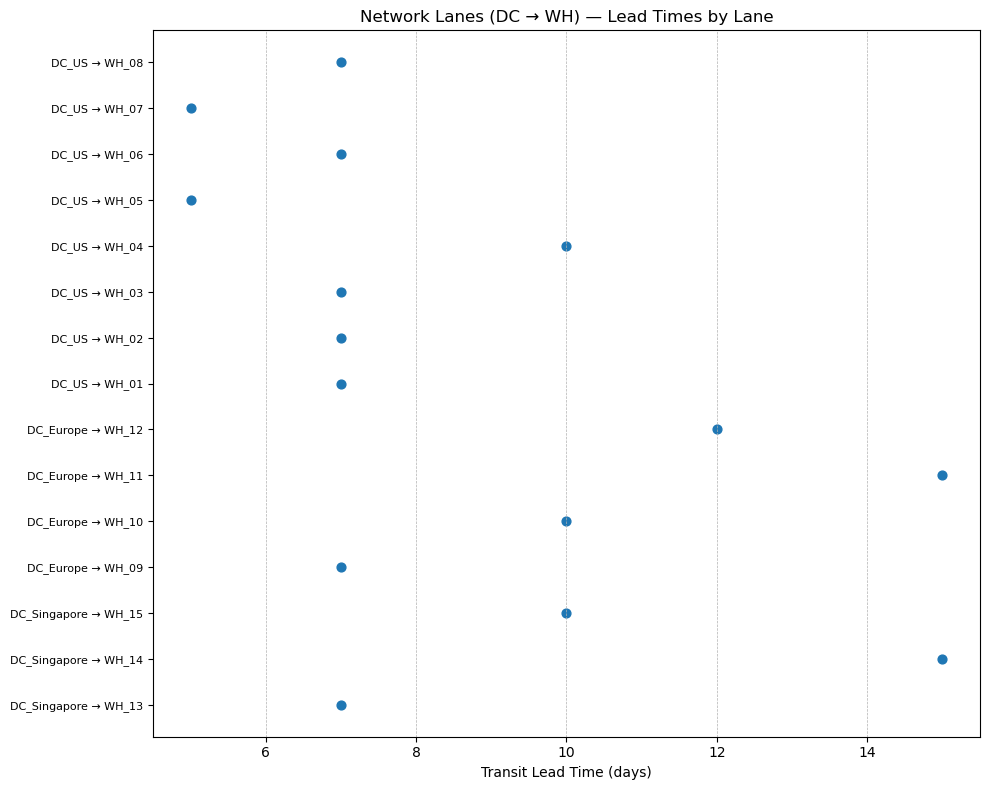

In [58]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

assert 'network_df' in globals(), "network_df missing."

lanes = (network_df.rename(columns={
    "Assigned DC": "From_DC",
    "Warehouse": "To_WH",
    "Transit Lead Time days": "LT_days"
})[["Region","From_DC","To_WH","LT_days"]])

lanes["lane"] = lanes["From_DC"] + " → " + lanes["To_WH"]
lanes = lanes.sort_values(["Region","From_DC","To_WH"]).reset_index(drop=True)
lanes["ypos"] = np.arange(len(lanes))

plt.figure(figsize=(10,8))
plt.scatter(lanes["LT_days"], lanes["ypos"], s=40)
plt.yticks(lanes["ypos"], lanes["lane"], fontsize=8)
plt.xlabel("Transit Lead Time (days)")
plt.title("Network Lanes (DC → WH) — Lead Times by Lane")
plt.grid(True, axis="x", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig("chart_p1_network_leadtimes.png", dpi=200, bbox_inches="tight")
plt.show()


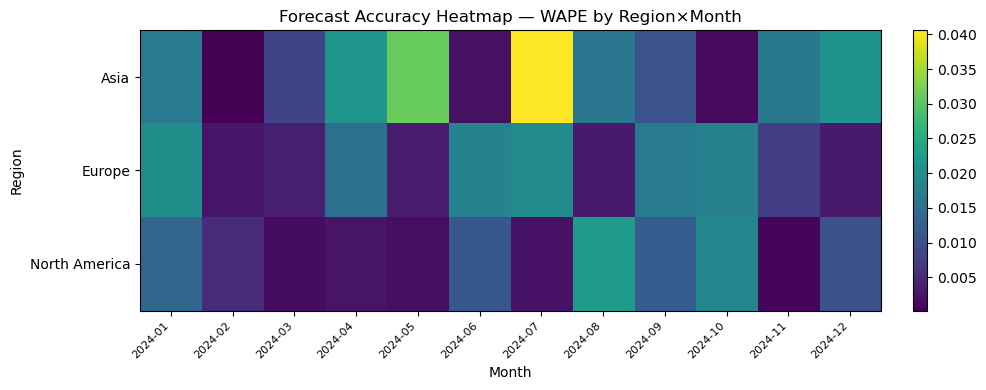

In [60]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

assert 'sku_df' in globals(), "sku_df missing."

def month_to_str(m):
    import pandas as pd
    if isinstance(m, pd.Period): return m.strftime("%Y-%m")
    try: return pd.Period(m, freq="M").strftime("%Y-%m")
    except: return str(m)

acc = sku_df.copy()
acc["Month_str"] = acc["Month"].apply(month_to_str)
rgm = (acc.groupby(["Region","Month_str"], as_index=False)
         .agg(F=("Forecast Units","sum"), A=("Sales Units","sum")))
rgm["WAPE"] = np.where(rgm["A"]>0, np.abs(rgm["F"]-rgm["A"])/rgm["A"], np.nan)

months_sorted = sorted(rgm["Month_str"].unique())
wape_mat = rgm.pivot(index="Region", columns="Month_str", values="WAPE").reindex(columns=months_sorted)

plt.figure(figsize=(10,4))
im = plt.imshow(wape_mat.values, aspect="auto")
plt.xticks(np.arange(len(months_sorted)), months_sorted, rotation=45, ha="right", fontsize=8)
plt.yticks(np.arange(wape_mat.shape[0]), wape_mat.index.tolist())
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Forecast Accuracy Heatmap — WAPE by Region×Month")
plt.xlabel("Month"); plt.ylabel("Region")
plt.tight_layout()
plt.savefig("chart_p1_forecast_accuracy.png", dpi=200, bbox_inches="tight")
plt.show()


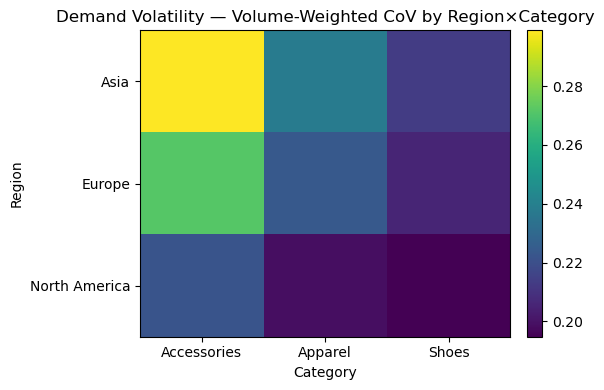

In [62]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

assert 'sku_df' in globals(), "sku_df missing."

def month_to_str(m):
    import pandas as pd
    if isinstance(m, pd.Period): return m.strftime("%Y-%m")
    try: return pd.Period(m, freq="M").strftime("%Y-%m")
    except: return str(m)

vol = sku_df.copy()
vol["Month_str"] = vol["Month"].apply(month_to_str)
sku_reg_month = (vol.groupby(["Region","Category","SKU","Month_str"], as_index=False)
                   .agg(actual=("Sales Units","sum")))

def cov_per_group(df):
    a = df["actual"].to_numpy(float)
    if len(a)<2 or np.nanmean(a)==0:
        return pd.Series({"sum_actual": np.nansum(a), "CoV": np.nan})
    return pd.Series({"sum_actual": np.nansum(a),
                      "CoV": np.nanstd(a, ddof=1)/(np.nanmean(a) or np.nan)})

sku_reg_cov = (sku_reg_month.groupby(["Region","Category","SKU"], as_index=False)
               .apply(cov_per_group).reset_index(drop=True))

def weighted_cov(df):
    w, x = df["sum_actual"].to_numpy(), df["CoV"].to_numpy()
    m = np.isfinite(x)&(w>0)
    if m.sum()==0: return np.nan
    return np.nansum(x[m]*w[m]) / np.nansum(w[m])

cov_mat_df = (sku_reg_cov.groupby(["Region","Category"])
               .apply(weighted_cov).reset_index(name="weighted_CoV")
               .pivot(index="Region", columns="Category", values="weighted_CoV"))

regions = sorted(cov_mat_df.index)
cats = ["Accessories","Apparel","Shoes"]
cov_mat_df = cov_mat_df.reindex(index=regions, columns=cats)

plt.figure(figsize=(6,4))
im2 = plt.imshow(cov_mat_df.values, aspect="auto")
plt.xticks(np.arange(len(cats)), cats)
plt.yticks(np.arange(len(regions)), regions)
plt.colorbar(im2, fraction=0.046, pad=0.04)
plt.title("Demand Volatility — Volume-Weighted CoV by Region×Category")
plt.xlabel("Category"); plt.ylabel("Region")
plt.tight_layout()
plt.savefig("chart_p1_demand_volatility.png", dpi=200, bbox_inches="tight")
plt.show()


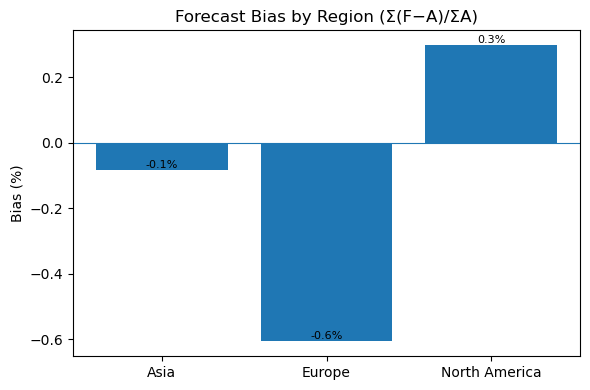

In [64]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

assert 'sku_df' in globals(), "sku_df missing."

def month_to_str(m):
    import pandas as pd
    if isinstance(m, pd.Period): return m.strftime("%Y-%m")
    try: return pd.Period(m, freq="M").strftime("%Y-%m")
    except: return str(m)

acc = sku_df.copy()
acc["Month_str"] = acc["Month"].apply(month_to_str)
rgm = (acc.groupby(["Region","Month_str"], as_index=False)
          .agg(F=("Forecast Units","sum"), A=("Sales Units","sum")))
bias_df = (rgm.groupby("Region", as_index=False)
              .agg(F=("F","sum"), A=("A","sum")))
bias_df["Bias_pct"] = np.where(bias_df["A"]>0,
    (bias_df["F"]-bias_df["A"])/bias_df["A"]*100, np.nan)

plt.figure(figsize=(6,4))
plt.bar(bias_df["Region"], bias_df["Bias_pct"])
plt.axhline(0, linewidth=0.8)
plt.ylabel("Bias (%)")
plt.title("Forecast Bias by Region (Σ(F−A)/ΣA)")
for i, v in enumerate(bias_df["Bias_pct"]):
    plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.savefig("chart_p1_forecast_bias.png", dpi=200, bbox_inches="tight")
plt.show()


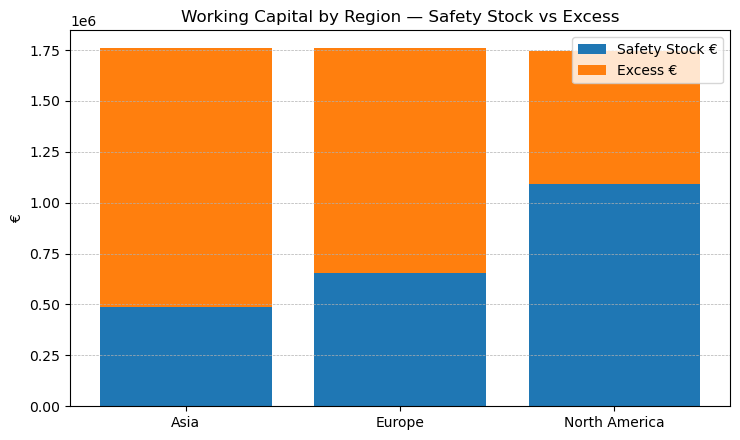

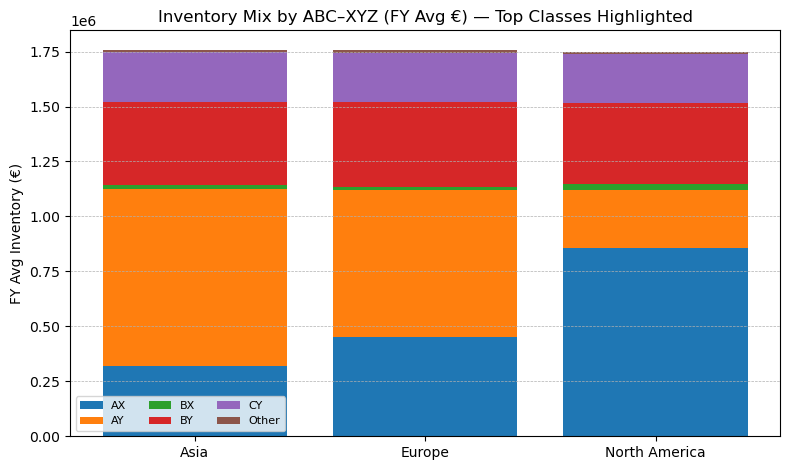

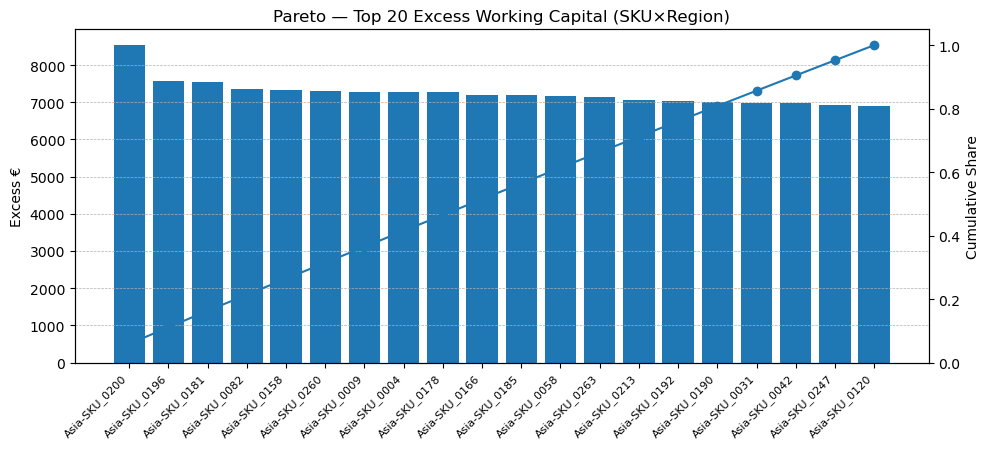

[INFO] Saved charts: chart_p2_region_inv_stack.png, chart_p2_abcxyz_share_stacked.png, chart_p2_excess_pareto_top20.png
[INFO] Saved data: table_p2_wc_region.csv


In [66]:
# === PAGE 2: Inventory & Working Capital (Charts) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# --- 0) Sanity guards ---------------------------------------------------------
assert 'sku_df' in globals(), "sku_df missing. Please run data loading cells from Step 1."

# Optional: Step-7 safety stock result (lane×SKU with SS_value_eur)
# We’ll gracefully handle if not present.
ss_like_cols = ["Region","From_DC","To_WH","SKU","SS_value_eur"]
has_ss = any([(name in globals()) and isinstance(globals()[name], pd.DataFrame) and
              set(ss_like_cols).issubset(globals()[name].columns)
              for name in list(globals().keys())])
ss_df = None
if has_ss:
    # find the variable that matches
    for name in list(globals().keys()):
        obj = globals()[name]
        if isinstance(obj, pd.DataFrame) and set(ss_like_cols).issubset(obj.columns):
            ss_df = obj.copy()
            break

# --- 1) Build FY Average Inventory € at SKU×Region (Warehouse-only) ----------
inv = sku_df.copy()
inv = inv[inv["Location Type"] == "Warehouse"].copy()

# Monthly avg inventory units per row (warehouse, sku, month)
inv["avg_units_month"] = (inv["Opening Stock Units"] + inv["Closing Stock Units"]) / 2.0
inv["avg_value_month_eur"] = inv["avg_units_month"] * inv["Unit Cost (€)"]

# FY average inventory € at SKU×Region: mean across months of summed warehouses
# (This matches the “monthly average” idea used on Step-8)
fy_inv_sku_region = (inv.groupby(["Region","SKU","Category"], as_index=False)
                        .agg(FY_Avg_Inv_eur=("avg_value_month_eur","mean")))

# Region totals (actual)
region_inv = fy_inv_sku_region.groupby("Region", as_index=False)\
                              .agg(FY_Avg_Inventory_eur=("FY_Avg_Inv_eur","sum"))

# --- 2) Safety Stock € baseline by Region (from Step 7, if available) --------
if ss_df is not None:
    ss_region = ss_df.groupby("Region", as_index=False)\
                     .agg(SS_Baseline_eur=("SS_value_eur","sum"))
else:
    # If SS not available, set to zero (charts still render; label will note fallback)
    ss_region = region_inv[["Region"]].copy()
    ss_region["SS_Baseline_eur"] = 0.0

# Join and compute Excess = Actual FY Avg − SS baseline  (floored at 0)
wc_region = region_inv.merge(ss_region, on="Region", how="left")
wc_region["Excess_FY_Avg_eur"] = np.maximum(0.0, wc_region["FY_Avg_Inventory_eur"] - wc_region["SS_Baseline_eur"])

# --- 3) ABC–XYZ (lean reconstruction if not present) --------------------------
# If you already have an ABC–XYZ table (e.g., abcxyz_df with Region, SKU, ABC_XYZ), we’ll use it.
# Otherwise, we build it here from FY revenue and CoV.
abcxyz_df = None
for name in list(globals().keys()):
    obj = globals()[name]
    if isinstance(obj, pd.DataFrame) and set(["Region","SKU","ABC_XYZ"]).issubset(obj.columns):
        abcxyz_df = obj.copy()
        break

if abcxyz_df is None:
    # Revenue for ABC
    rev = inv.groupby(["Region","SKU","Category"], as_index=False)\
             .agg(revenue=("Sales Units","sum"))
    rev["revenue"] = rev["revenue"] * inv[["SKU","Unit Sales Price (€)"]].drop_duplicates("SKU")\
                                           .set_index("SKU").loc[rev["SKU"]]["Unit Sales Price (€)"].to_numpy()

    # ABC by Region (80/15/5 on revenue)
    def abc_assign(df):
        df = df.sort_values("revenue", ascending=False).reset_index(drop=True)
        df["cum_share"] = df["revenue"].cumsum() / df["revenue"].sum() if df["revenue"].sum() > 0 else 0
        df["ABC"] = np.where(df["cum_share"] <= 0.80, "A",
                     np.where(df["cum_share"] <= 0.95, "B", "C"))
        return df

    rev_abc = rev.groupby("Region", group_keys=False).apply(abc_assign)

    # XYZ via CoV of monthly actuals
    m_df = (inv.groupby(["Region","SKU","Category","MonthStart"], as_index=False)
               .agg(actual=("Sales Units","sum")))
    def cov_sku(g):
        a = g["actual"].to_numpy()
        mu = np.nanmean(a)
        sigma = np.nanstd(a, ddof=1)
        cov = (sigma / mu) if (mu and mu!=0) else np.nan
        return pd.Series({"CoV": cov})
    cov_tbl = m_df.groupby(["Region","SKU","Category"], as_index=False).apply(cov_sku).reset_index(drop=True)

    # XYZ thresholds (X≤0.30, 0.30<Y≤0.60, Z>0.60)
    cov_tbl["XYZ"] = np.where(cov_tbl["CoV"] <= 0.30, "X",
                       np.where(cov_tbl["CoV"] <= 0.60, "Y", "Z"))

    abcxyz_df = (rev_abc.merge(cov_tbl[["Region","SKU","XYZ"]], on=["Region","SKU"], how="left"))
    abcxyz_df["ABC_XYZ"] = abcxyz_df["ABC"] + abcxyz_df["XYZ"]
    abcxyz_df = abcxyz_df[["Region","SKU","Category","ABC","XYZ","ABC_XYZ"]]

# Attach ABC–XYZ to FY inventory for shares
fy_inv_with_class = fy_inv_sku_region.merge(abcxyz_df[["Region","SKU","ABC_XYZ"]], on=["Region","SKU"], how="left")
fy_inv_with_class["ABC_XYZ"].fillna("Unclassified", inplace=True)

# --- 4) CHART #1 — Region Stacked Bars: SS € vs Excess € ----------------------
fig, ax = plt.subplots(figsize=(7.5,4.5))
x = np.arange(len(wc_region))
bar1 = ax.bar(x, wc_region["SS_Baseline_eur"].values, label="Safety Stock €")
bar2 = ax.bar(x, wc_region["Excess_FY_Avg_eur"].values, bottom=wc_region["SS_Baseline_eur"].values, label="Excess €")

ax.set_xticks(x)
ax.set_xticklabels(wc_region["Region"].tolist())
ax.set_ylabel("€")
title_note = "" if ss_df is not None else " (SS unavailable → treated as 0)"
ax.set_title("Working Capital by Region — Safety Stock vs Excess"+title_note)
ax.legend()
ax.grid(True, axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig("chart_p2_region_inv_stack.png", dpi=200, bbox_inches="tight")
plt.show()

# --- 5) CHART #2 — ABC–XYZ Share of FY Avg Inventory € (stacked) -------------
# Keep the legend readable: show top 5 classes by value + group others into "Other"
share_tbl = (fy_inv_with_class.groupby(["Region","ABC_XYZ"], as_index=False)
                               .agg(FY_Avg_Inv_eur=("FY_Avg_Inv_eur","sum")))
# Determine top 5 classes globally by value
glob_rank = (share_tbl.groupby("ABC_XYZ", as_index=False)
                     .agg(total=("FY_Avg_Inv_eur","sum"))
                     .sort_values("total", ascending=False))
top_classes = glob_rank["ABC_XYZ"].head(5).tolist()

share_tbl["ABC_grp"] = np.where(share_tbl["ABC_XYZ"].isin(top_classes), share_tbl["ABC_XYZ"], "Other")
stack_tbl = (share_tbl.groupby(["Region","ABC_grp"], as_index=False)
                      .agg(value=("FY_Avg_Inv_eur","sum")))
pivot = stack_tbl.pivot(index="Region", columns="ABC_grp", values="value").fillna(0.0)

# Plot stacked bars
fig, ax = plt.subplots(figsize=(8,4.8))
bottom = np.zeros(len(pivot.index))
for cls in pivot.columns:
    ax.bar(pivot.index, pivot[cls].values, bottom=bottom, label=cls)
    bottom += pivot[cls].values

ax.set_ylabel("FY Avg Inventory (€)")
ax.set_title("Inventory Mix by ABC–XYZ (FY Avg €) — Top Classes Highlighted")
ax.legend(ncol=3, fontsize=8)
ax.grid(True, axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig("chart_p2_abcxyz_share_stacked.png", dpi=200, bbox_inches="tight")
plt.show()

# --- 6) CHART #3 — Pareto: Top 20 SKU×Region Excess € -------------------------
# We need SS allocation per SKU×Region; if SS unknown, treat SS=0 (excess=FY_Avg)
if ss_df is not None:
    # SS is lane×SKU; aggregate to Region×SKU
    ss_sku_region = ss_df.groupby(["Region","SKU"], as_index=False)\
                         .agg(SS_eur=("SS_value_eur","sum"))
else:
    ss_sku_region = fy_inv_sku_region[["Region","SKU"]].copy()
    ss_sku_region["SS_eur"] = 0.0

excess_tbl = fy_inv_sku_region.merge(ss_sku_region, on=["Region","SKU"], how="left")
excess_tbl["Excess_eur"] = np.maximum(0.0, excess_tbl["FY_Avg_Inv_eur"] - excess_tbl["SS_eur"])

# Pareto top 20 by Excess €
topN = (excess_tbl.sort_values("Excess_eur", ascending=False)
                  .head(20)
                  .reset_index(drop=True))

# Bar + cumulative line
fig, ax1 = plt.subplots(figsize=(10,4.6))
bars = ax1.bar(np.arange(len(topN)), topN["Excess_eur"].values)
ax1.set_ylabel("Excess €")
ax1.set_xticks(np.arange(len(topN)))
ax1.set_xticklabels([f"{r}-{s}" for r,s in zip(topN["Region"], topN["SKU"])], rotation=45, ha="right", fontsize=8)
ax1.set_title("Pareto — Top 20 Excess Working Capital (SKU×Region)")

cum = topN["Excess_eur"].cumsum() / topN["Excess_eur"].sum() if topN["Excess_eur"].sum() > 0 else np.zeros(len(topN))
ax2 = ax1.twinx()
ax2.plot(np.arange(len(topN)), cum, marker="o")
ax2.set_ylim(0,1.05)
ax2.set_ylabel("Cumulative Share")

ax1.grid(True, axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig("chart_p2_excess_pareto_top20.png", dpi=200, bbox_inches="tight")
plt.show()

# --- 7) Optional: export table for the slide appendix -------------------------
export_tbl = wc_region.copy()
export_tbl = export_tbl.sort_values("FY_Avg_Inventory_eur", ascending=False)
export_tbl.to_csv("table_p2_wc_region.csv", index=False)
print("[INFO] Saved charts:",
      "chart_p2_region_inv_stack.png, chart_p2_abcxyz_share_stacked.png, chart_p2_excess_pareto_top20.png")
print("[INFO] Saved data: table_p2_wc_region.csv")


[Sanity] Rows with missing Region after merge: 0


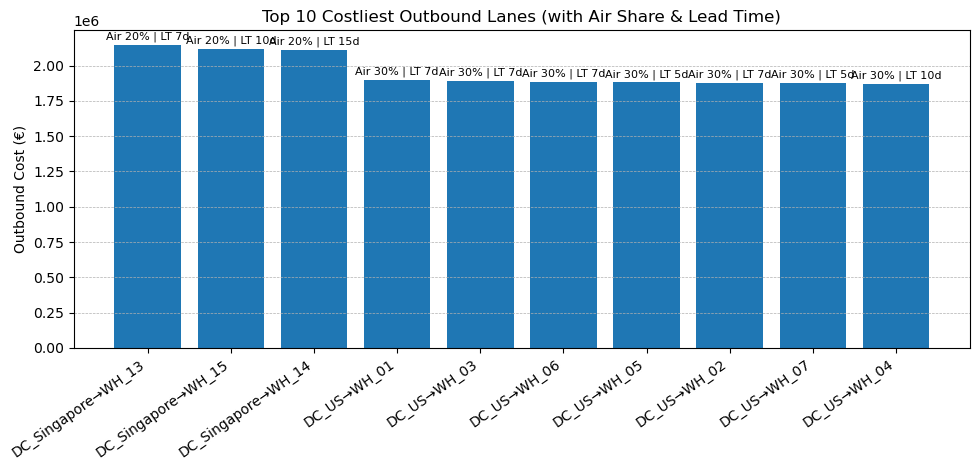

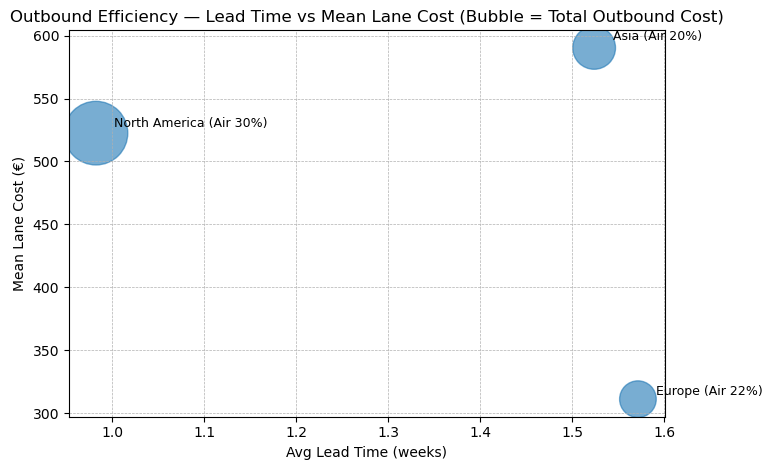

[INFO] Regenerated charts: chart_p3_outbound_lane_aircost.png, chart_p3_outbound_region_scatter.png
[INFO] Saved tables: table_p3_outbound_region_efficiency.csv, table_p3_outbound_lane_costs.csv


In [70]:
# === PATCH for Page 3: fix Region after merge & regenerate outbound visuals ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# 1) Robust merge + Region resolution
outb = outbound_df.copy()
lane = (
    outb.merge(
        network_df.rename(columns={"Assigned DC":"Assigned_DC", "Warehouse":"Warehouse"}),
        left_on=["From DC","To WH"],
        right_on=["Assigned_DC","Warehouse"],
        how="left"
    )
    .rename(columns={"Transit Lead Time days":"LT_days"})
)

# Resolve Region column safely
if "Region_x" in lane.columns and "Region_y" in lane.columns:
    lane["Region"] = lane["Region_x"].where(lane["Region_x"].notna(), lane["Region_y"])
elif "Region" in lane.columns:
    # already present (some environments retain a single Region)
    pass
else:
    raise KeyError("No Region column found after merge; check inputs.")

# Clean up helper columns
for col in ["Assigned_DC","Warehouse","Region_x","Region_y"]:
    if col in lane.columns:
        lane.drop(columns=col, inplace=True)

# 2) Sanity check: Region from outbound vs network mapping
_mismatch = lane.loc[lane["Region"].isna()]
print(f"[Sanity] Rows with missing Region after merge: {len(_mismatch)}")

# 3) Recompute lane costs summary
lane_cost = (
    lane.groupby(["From DC","To WH","Region"], as_index=False)
        .agg(
            total_out_cost_eur=("DC->WH Logistics Cost (€)","sum"),
            mean_air_share=("Air Share","mean"),
            mean_LT_days=("LT_days","mean")
        )
)
top10 = (
    lane_cost.sort_values("total_out_cost_eur", ascending=False)
            .head(10)
            .reset_index(drop=True)
)

# 4) Chart — Top 10 costliest outbound lanes (with Air% & LT annotations)
fig, ax = plt.subplots(figsize=(10,4.8))
x = np.arange(len(top10))
bars = ax.bar(x, top10["total_out_cost_eur"].values)
ax.set_xticks(x)
ax.set_xticklabels([f"{d}→{w}" for d,w in zip(top10["From DC"], top10["To WH"])], rotation=35, ha="right")
ax.set_ylabel("Outbound Cost (€)")
ax.set_title("Top 10 Costliest Outbound Lanes (with Air Share & Lead Time)")

for i, (v, air, lt) in enumerate(zip(top10["total_out_cost_eur"], top10["mean_air_share"], top10["mean_LT_days"])):
    ax.text(i, v*1.01, f"Air {air*100:.0f}% | LT {lt:.0f}d", ha="center", va="bottom", fontsize=8)

ax.grid(True, axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig("chart_p3_outbound_lane_aircost.png", dpi=200, bbox_inches="tight")
plt.show()

# 5) Region efficiency bubble — LT vs mean lane cost (bubble size = total outbound cost)
region_summary = (
    lane.groupby("Region", as_index=False)
        .agg(
            lanes=("To WH","nunique"),
            total_out_cost_eur=("DC->WH Logistics Cost (€)","sum"),
            mean_cost_per_lane=("DC->WH Logistics Cost (€)","mean"),
            mean_air_share=("Air Share","mean"),
            mean_LT_days=("LT_days","mean")
        )
)
region_summary["LT_weeks"] = region_summary["mean_LT_days"] / 7.0

fig, ax = plt.subplots(figsize=(7.8,4.8))
sizes = (region_summary["total_out_cost_eur"] / region_summary["total_out_cost_eur"].max() * 2000.0 + 100.0)
ax.scatter(region_summary["LT_weeks"], region_summary["mean_cost_per_lane"], s=sizes, alpha=0.6)

for _, r in region_summary.iterrows():
    ax.text(r["LT_weeks"]+0.02, r["mean_cost_per_lane"]*1.01, f"{r['Region']} (Air {r['mean_air_share']*100:.0f}%)", fontsize=9)

ax.set_xlabel("Avg Lead Time (weeks)")
ax.set_ylabel("Mean Lane Cost (€)")
ax.set_title("Outbound Efficiency — Lead Time vs Mean Lane Cost (Bubble = Total Outbound Cost)")
ax.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig("chart_p3_outbound_region_scatter.png", dpi=200, bbox_inches="tight")
plt.show()

# 6) Save appendix tables
region_summary.to_csv("table_p3_outbound_region_efficiency.csv", index=False)
lane_cost.sort_values("total_out_cost_eur", ascending=False).to_csv("table_p3_outbound_lane_costs.csv", index=False)

print("[INFO] Regenerated charts:",
      "chart_p3_outbound_lane_aircost.png, chart_p3_outbound_region_scatter.png")
print("[INFO] Saved tables:",
      "table_p3_outbound_region_efficiency.csv, table_p3_outbound_lane_costs.csv")


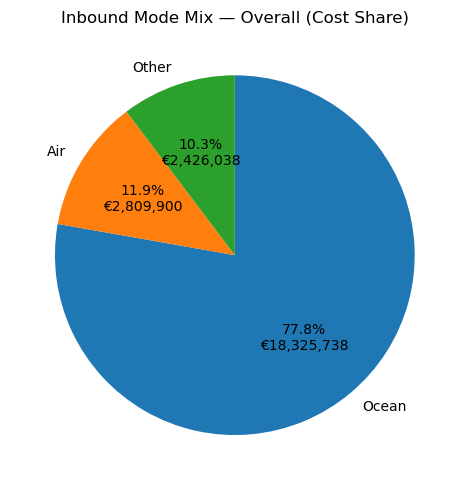

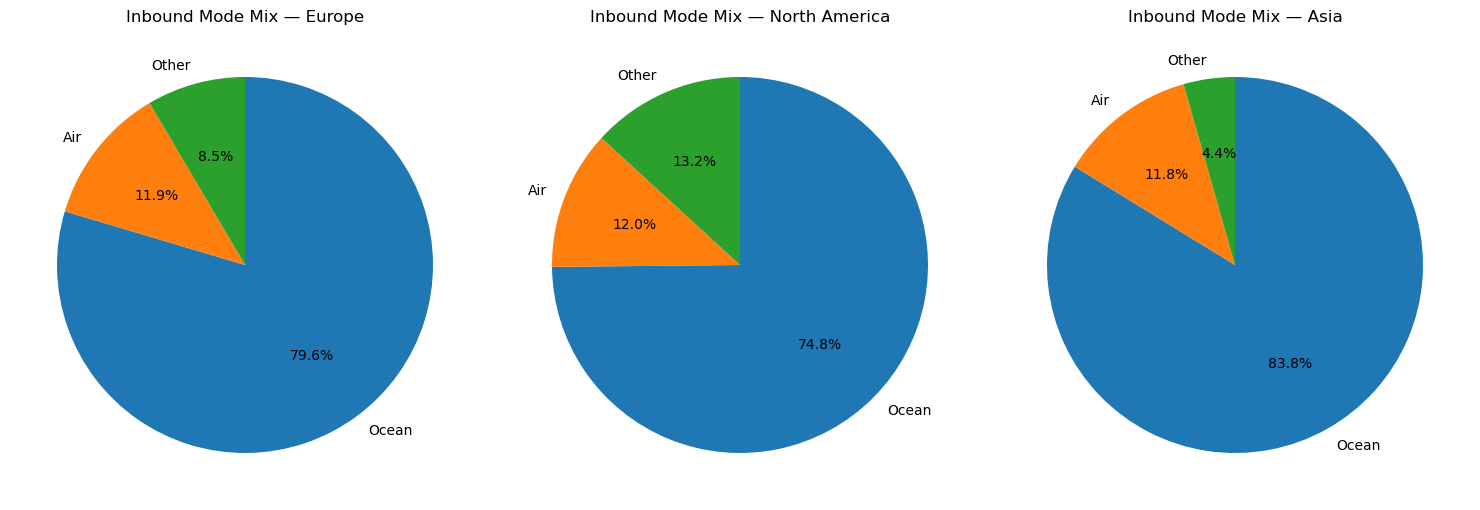

[INFO] Saved charts: chart_p3_mode_mix_overall_pie.png, chart_p3_mode_mix_region_pies.png


In [72]:
# === PAGE 3: Mode Mix Pie (Air vs Ocean vs Other) for Inbound ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt

assert "inbound_df" in globals(), "inbound_df missing."

inp = inbound_df.copy()
# Cost split by mode
inp["ocean_cost_eur"] = inp["Supplier->DC Logistics Cost (€)"] * inp["Ocean Share"]
inp["air_cost_eur"]   = inp["Supplier->DC Logistics Cost (€)"] * inp["Air Share"]
inp["other_cost_eur"] = inp["Supplier->DC Logistics Cost (€)"] * inp["Other Share"]

# ---------- Overall pie (cost-weighted mode mix) ----------
totals = {
    "Ocean": inp["ocean_cost_eur"].sum(),
    "Air":   inp["air_cost_eur"].sum(),
    "Other": inp["other_cost_eur"].sum()
}
labels = list(totals.keys())
values = list(totals.values())

fig, ax = plt.subplots(figsize=(5,5))
ax.pie(values, labels=labels, autopct=lambda p: f"{p:.1f}%\n€{(p/100)*sum(values):,.0f}",
       startangle=90, counterclock=False)
ax.set_title("Inbound Mode Mix — Overall (Cost Share)")
plt.tight_layout()
plt.savefig("chart_p3_mode_mix_overall_pie.png", dpi=200, bbox_inches="tight")
plt.show()

# ---------- Region pies (cost-weighted mode mix per region) ----------
regions = inp["Region"].unique().tolist()
fig, axes = plt.subplots(1, len(regions), figsize=(5*len(regions), 5))

if len(regions) == 1:
    axes = [axes]

for ax, r in zip(axes, regions):
    sub = inp[inp["Region"] == r]
    vals = [
        sub["ocean_cost_eur"].sum(),
        sub["air_cost_eur"].sum(),
        sub["other_cost_eur"].sum()
    ]
    ax.pie(vals, labels=["Ocean","Air","Other"],
           autopct=lambda p: f"{p:.1f}%", startangle=90, counterclock=False)
    ax.set_title(f"Inbound Mode Mix — {r}")

plt.tight_layout()
plt.savefig("chart_p3_mode_mix_region_pies.png", dpi=200, bbox_inches="tight")
plt.show()

print("[INFO] Saved charts: chart_p3_mode_mix_overall_pie.png, chart_p3_mode_mix_region_pies.png")


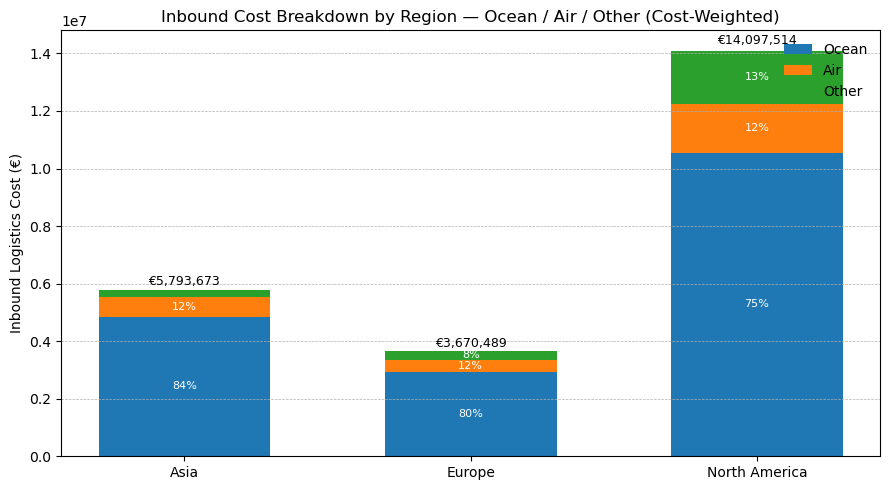

[INFO] Saved: chart_p3_inbound_mode_stack.png, table_p3_inbound_cost_breakdown.csv


In [74]:
# === PAGE 3: Inbound Cost Breakdown by Region (stacked bars: Ocean/Air/Other) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt

assert "inbound_df" in globals(), "inbound_df is not in memory."

inp = inbound_df.copy()

# Cost split by mode (cost-weighted shares)
inp["ocean_cost_eur"] = inp["Supplier->DC Logistics Cost (€)"] * inp["Ocean Share"]
inp["air_cost_eur"]   = inp["Supplier->DC Logistics Cost (€)"] * inp["Air Share"]
inp["other_cost_eur"] = inp["Supplier->DC Logistics Cost (€)"] * inp["Other Share"]

region_cost = (
    inp.groupby("Region", as_index=False)
       .agg(
           ocean_eur=("ocean_cost_eur","sum"),
           air_eur=("air_cost_eur","sum"),
           other_eur=("other_cost_eur","sum")
       )
)

# Order regions nicely (optional)
region_order = ["Asia","Europe","North America"]
region_cost["Region"] = pd.Categorical(region_cost["Region"], categories=region_order, ordered=True)
region_cost = region_cost.sort_values("Region").reset_index(drop=True)

# Totals and shares for labels
region_cost["total_eur"] = region_cost[["ocean_eur","air_eur","other_eur"]].sum(axis=1)
for col in ["ocean_eur","air_eur","other_eur"]:
    region_cost[col.replace("_eur","_pct")] = region_cost[col] / region_cost["total_eur"]

# --------- Plot ---------
fig, ax = plt.subplots(figsize=(9,5))
x = np.arange(len(region_cost))
w = 0.6

b1 = ax.bar(x, region_cost["ocean_eur"], width=w, label="Ocean")
b2 = ax.bar(x, region_cost["air_eur"],   width=w, bottom=region_cost["ocean_eur"], label="Air")
b3 = ax.bar(x, region_cost["other_eur"], width=w,
            bottom=region_cost["ocean_eur"]+region_cost["air_eur"], label="Other")

ax.set_xticks(x)
ax.set_xticklabels(region_cost["Region"])
ax.set_ylabel("Inbound Logistics Cost (€)")
ax.set_title("Inbound Cost Breakdown by Region — Ocean / Air / Other (Cost-Weighted)")
ax.grid(True, axis="y", linestyle="--", linewidth=0.5)
ax.legend(loc="upper right", frameon=False)

# Top-of-bar total labels and inside percentage labels
for i, tot in enumerate(region_cost["total_eur"].values):
    ax.text(i, tot*1.01, f"€{tot:,.0f}", ha="center", va="bottom", fontsize=9)
    # Percent labels centered in each stacked segment (only if >5% of bar)
    for col, bottom in [
        ("ocean", 0.0),
        ("air",   region_cost.loc[i, "ocean_eur"]),
        ("other", region_cost.loc[i, "ocean_eur"] + region_cost.loc[i, "air_eur"])
    ]:
        val = region_cost.loc[i, f"{col}_eur"]
        pct = region_cost.loc[i, f"{col}_pct"]
        if pct >= 0.05:
            ax.text(i, bottom + val/2, f"{pct*100:.0f}%", ha="center", va="center", fontsize=8, color="white")

plt.tight_layout()
plt.savefig("chart_p3_inbound_mode_stack.png", dpi=200, bbox_inches="tight")
plt.show()

# Save appendix table
region_cost.to_csv("table_p3_inbound_cost_breakdown.csv", index=False)

print("[INFO] Saved:",
      "chart_p3_inbound_mode_stack.png, table_p3_inbound_cost_breakdown.csv")


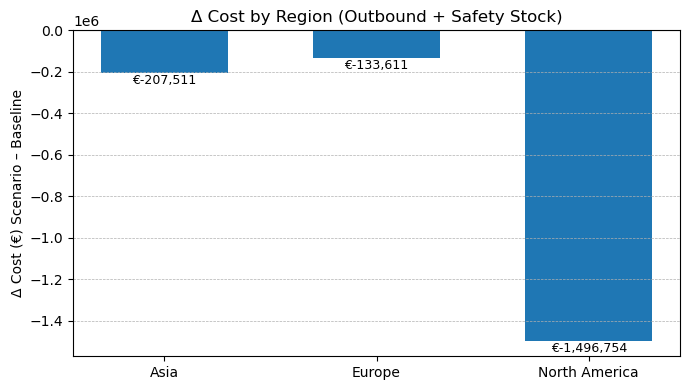

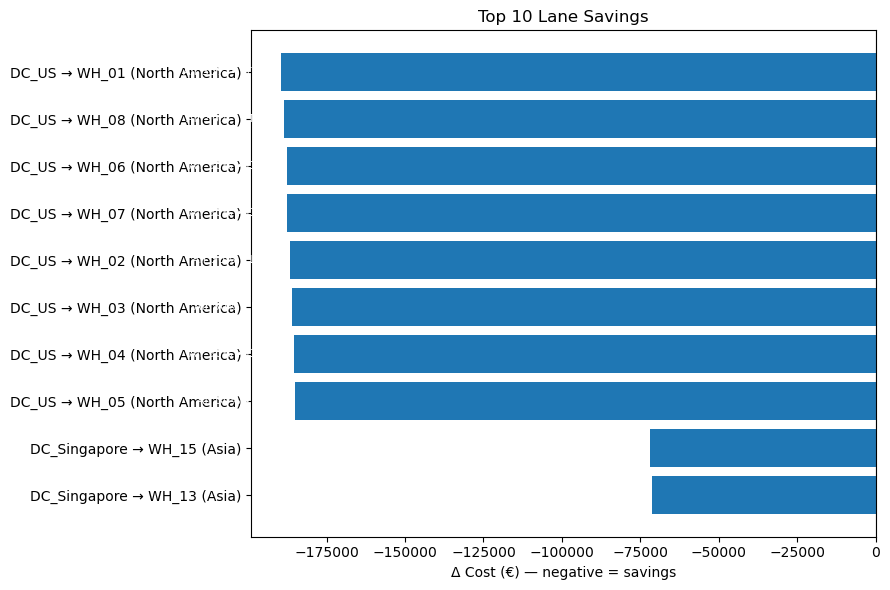

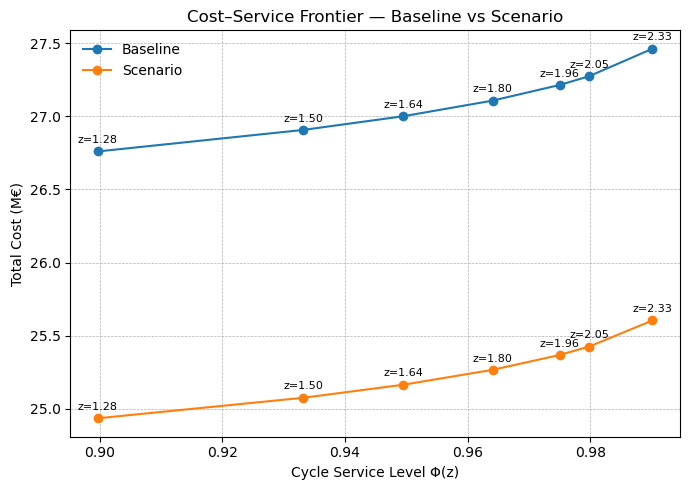

[OK] Saved:
 - chart_p4_delta_cost_by_region.png
 - chart_p4_top10_savings_lanes.png
 - chart_p4_csl_vs_cost_scatter.png
 - table_p4_beta_change_region_segment.csv


In [80]:
# ============================
# PAGE 4 — Mode-Shift & Service Simulation (What If?)
# Self-healing + Region coalesce hotfix
# ============================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from math import erf, sqrt

# ---- Assumptions (same as before) ----
AIR_CAP = {"Asia": 0.18, "Europe": 0.20, "North America": 0.22}
AIR_PREMIUM = 1.40
LT_IMPROVE_DAYS = {"Asia": -3, "Europe": -1, "North America": 0}
CV_LT_BY_REGION = {"North America": 0.10, "Europe": 0.10, "Asia": 0.15}
WEEKS_PER_MONTH = 4.345
DAYS_PER_WEEK = 7.0

for req in ["outbound_df","network_df","sku_df"]:
    assert req in globals(), f"Missing DataFrame: {req}"

def Phi(z):
    z = np.asarray(z, dtype=float)
    return 0.5 * (1.0 + erf(z / sqrt(2.0)))

# ---------- Build/repair ABC–XYZ if needed ----------
abcxyz_df = globals().get("abcxyz_df")
if abcxyz_df is None:
    d = sku_df.copy()
    d["revenue"] = d["Sales Units"] * d["Unit Sales Price (€)"]
    covs = (d.groupby(["Region","SKU"], as_index=False)
              .agg(mu=("Sales Units","mean"), sigma=("Sales Units","std")))
    covs["CoV"] = np.where(covs["mu"]>0, covs["sigma"]/covs["mu"], 0.0)
    abcxyz_df = (d.groupby(["Region","SKU","Category"], as_index=False)
                   .agg(sum_units=("Sales Units","sum"), revenue=("revenue","sum"))
                   .merge(covs[["Region","SKU","CoV"]], on=["Region","SKU"], how="left"))
    # ABC by revenue share (A 0–80%, B 80–95%, C 95–100%)
    abcxyz_df = abcxyz_df.sort_values(["Region","revenue"], ascending=[True,False])
    abcxyz_df["cum_rev"] = abcxyz_df.groupby("Region")["revenue"].cumsum()
    abcxyz_df["tot_rev"] = abcxyz_df.groupby("Region")["revenue"].transform("sum")
    abcxyz_df["cum_share"] = abcxyz_df["cum_rev"]/abcxyz_df["tot_rev"]
    abcxyz_df["ABC"] = pd.cut(abcxyz_df["cum_share"],
                              bins=[-1,0.80,0.95,1.0],
                              labels=list("ABC")).astype(str)
    # XYZ by CoV (≤0.30 = X, ≤0.60 = Y, else Z)
    abcxyz_df["XYZ"] = pd.cut(abcxyz_df["CoV"].fillna(0.0),
                              bins=[-1,0.30,0.60,10.0],
                              labels=list("XYZ")).astype(str)
    abcxyz_df["ABC_XYZ"] = abcxyz_df["ABC"] + abcxyz_df["XYZ"]

abcz_map = abcxyz_df.set_index(["Region","SKU"])["ABC_XYZ"].to_dict()

def z_from_class(axz):
    base = {"A":1.96,"B":1.64,"C":1.28}[axz[0]]
    nudge = {"X":0.00,"Y":0.10,"Z":0.20}[axz[1]]
    return base + nudge

# ---------- Build/repair ss_lane_df (Region coalesce hotfix) ----------
ss_lane_df = globals().get("ss_lane_df")
if ss_lane_df is None:
    s = sku_df[sku_df["Location Type"]=="Warehouse"].copy()
    s = s.merge(
        network_df.rename(columns={
            "Assigned DC":"From_DC",
            "Warehouse":"Location",
            "Transit Lead Time days":"LT_days"
        }),
        on="Location", how="left"
    )
    # HOTFIX: coalesce Region_x/Region_y -> Region
    if "Region" not in s.columns:
        s["Region"] = s.get("Region_x", pd.Series(index=s.index)).fillna(s.get("Region_y", pd.Series(index=s.index)))
        s.drop(columns=[c for c in ["Region_x","Region_y"] if c in s.columns], inplace=True)

    g = s.groupby(["Region","From_DC","Location","SKU","Category"], as_index=False)
    stats = g.agg(mu_m=("Sales Units","mean"),
                  sigma_m=("Sales Units","std"),
                  unit_cost=("Unit Cost (€)","mean"))
    stats["mu_week"] = stats["mu_m"]/WEEKS_PER_MONTH
    stats["sigma_week"] = stats["sigma_m"]/WEEKS_PER_MONTH

    lt = s.groupby(["Region","From_DC","Location"], as_index=False).agg(LT_days=("LT_days","mean"))
    stats = stats.merge(lt, on=["Region","From_DC","Location"], how="left")
    stats["LT_weeks"] = stats["LT_days"]/DAYS_PER_WEEK
    stats["sigma_LT_weeks"] = stats["Region"].map(CV_LT_BY_REGION).fillna(0.10) * stats["LT_weeks"]

    stats["ABC_XYZ"] = stats.apply(lambda r: abcz_map.get((r["Region"], r["SKU"]), "BY"), axis=1)
    stats["z"] = stats["ABC_XYZ"].apply(z_from_class)

    ss_lane_df = stats.rename(columns={"Location":"To_WH","unit_cost":"unit_cost_eur"})[
        ["Region","From_DC","To_WH","SKU","Category","ABC_XYZ",
         "z","mu_week","sigma_week","LT_weeks","sigma_LT_weeks","unit_cost_eur"]
    ]
    ss_lane_df["sigmaL"] = np.sqrt(
        np.maximum(0.0,
            (ss_lane_df["sigma_week"]**2)*ss_lane_df["LT_weeks"] +
            (ss_lane_df["mu_week"]**2)*(ss_lane_df["sigma_LT_weeks"]**2)
        )
    )
    ss_lane_df["SS_units"] = ss_lane_df["z"] * ss_lane_df["sigmaL"]
    ss_lane_df["SS_value_eur"] = ss_lane_df["SS_units"] * ss_lane_df["unit_cost_eur"]

# ---------- Outbound baseline vs scenario (with Region coalesce) ----------
lane = (outbound_df.merge(network_df,
                          left_on=["From DC","To WH"],
                          right_on=["Assigned DC","Warehouse"],
                          how="left")
                   .rename(columns={"Transit Lead Time days":"LT_days"})
                   .drop(columns=["Assigned DC","Warehouse"]))
if "Region" not in lane.columns:
    lane["Region"] = lane.get("Region_x", pd.Series(index=lane.index)).fillna(lane.get("Region_y", pd.Series(index=lane.index)))
    lane.drop(columns=[c for c in ["Region_x","Region_y"] if c in lane.columns], inplace=True)

lane_cost = (lane.groupby(["From DC","To WH","Region"], as_index=False)
                .agg(out_cost_base=("DC->WH Logistics Cost (€)","sum"),
                     air_share_base=("Air Share","mean"),
                     LT_days_base=("LT_days","mean")))

def _scaled(row):
    r = row["Region"]; a = float(row["air_share_base"])
    cap = AIR_CAP.get(r, a); a_new = min(a, cap)
    non_air = 1.0 - a
    denom = non_air + a * AIR_PREMIUM
    numer = non_air + a_new * AIR_PREMIUM
    scale = numer/denom if denom>0 else 1.0
    return row["out_cost_base"]*scale, a_new

tmp = lane_cost.apply(lambda r: pd.Series(_scaled(r), index=["out_cost_new","air_share_new"]), axis=1)
lane_cost = pd.concat([lane_cost, tmp], axis=1)

# ---------- SS scenario (LT & σ_LT shrink) ----------
ss_scn = ss_lane_df.copy()
lt_map = lane_cost.set_index(["From DC","To WH"])["LT_days_base"].to_dict()
ss_scn["LT_days_base"] = ss_scn.set_index(["From_DC","To_WH"]).index.map(lt_map).astype(float)
ss_scn["LT_days_new"]  = ss_scn.apply(lambda r: max(1.0, (r["LT_days_base"] if pd.notna(r["LT_days_base"]) else 7.0)
                                                    + LT_IMPROVE_DAYS.get(r["Region"],0)), axis=1)
ss_scn["LT_weeks_new"] = ss_scn["LT_days_new"]/DAYS_PER_WEEK
ss_scn["sigma_LT_weeks_new"] = ss_scn.apply(
    lambda r: r["sigma_LT_weeks"]*(0.95 if r["Region"]=="Europe" else (0.90 if r["Region"]=="Asia" else 1.00)),
    axis=1
)
ss_scn["sigmaL_new"] = np.sqrt(np.maximum(0.0,
    (ss_scn["sigma_week"]**2)*ss_scn["LT_weeks_new"] + (ss_scn["mu_week"]**2)*(ss_scn["sigma_LT_weeks_new"]**2)
))
ss_scn["SS_units_new"] = ss_scn["z"] * ss_scn["sigmaL_new"]
ss_scn["SS_value_new_eur"] = ss_scn["SS_units_new"] * ss_scn["unit_cost_eur"]

ss_join = (ss_lane_df.groupby(["From_DC","To_WH","Region"], as_index=False)
                     .agg(ss_base=("SS_value_eur","sum"))
           ).merge(
           ss_scn.groupby(["From_DC","To_WH","Region"], as_index=False)
                 .agg(ss_new=("SS_value_new_eur","sum")),
           on=["From_DC","To_WH","Region"], how="left")

lane_all = (lane_cost.merge(ss_join, left_on=["From DC","To WH","Region"],
                            right_on=["From_DC","To_WH","Region"], how="left")
                    .drop(columns=["From_DC","To_WH"]))
lane_all["total_base"] = lane_all["out_cost_base"] + lane_all["ss_base"].fillna(0.0)
lane_all["total_new"]  = lane_all["out_cost_new"]  + lane_all["ss_new"].fillna(0.0)
lane_all["delta_total"]= lane_all["total_new"] - lane_all["total_base"]

# ---------- Region deltas (Chart 1) ----------
region_delta = (lane_all.groupby("Region", as_index=False)
                         .agg(base_log_cost=("out_cost_base","sum"),
                              new_log_cost=("out_cost_new","sum"),
                              base_ss=("ss_base","sum"),
                              new_ss=("ss_new","sum")))
region_delta["Δ_log_cost"] = region_delta["new_log_cost"] - region_delta["base_log_cost"]
region_delta["Δ_ss_value"] = region_delta["new_ss"] - region_delta["base_ss"]
region_delta["Total_Δ_€"]  = region_delta["Δ_log_cost"] + region_delta["Δ_ss_value"]

fig, ax = plt.subplots(figsize=(7,4))
order = ["Asia","Europe","North America"]
region_delta["Region"] = pd.Categorical(region_delta["Region"], categories=order, ordered=True)
region_delta = region_delta.sort_values("Region")
x = np.arange(len(region_delta)); w=0.6
bars = ax.bar(x, region_delta["Total_Δ_€"], width=w)
ax.axhline(0, color="grey", lw=0.8); ax.set_xticks(x); ax.set_xticklabels(region_delta["Region"])
ax.set_ylabel("Δ Cost (€) Scenario – Baseline"); ax.set_title("Δ Cost by Region (Outbound + Safety Stock)")
ax.grid(axis="y", linestyle="--", lw=0.5)
for i,v in enumerate(region_delta["Total_Δ_€"]):
    ax.text(i, v + (5_000 if v>=0 else -5_000), f"€{v:,.0f}", ha="center",
            va="bottom" if v>=0 else "top", fontsize=9)
plt.tight_layout(); plt.savefig("chart_p4_delta_cost_by_region.png", dpi=200); plt.show()

# ---------- Top 10 savings lanes (Chart 2) ----------
lane_top = lane_all.sort_values("delta_total").head(10).copy()
lane_top["lane"] = lane_top["From DC"] + " → " + lane_top["To WH"] + " (" + lane_top["Region"] + ")"
fig, ax = plt.subplots(figsize=(9,6))
y = np.arange(len(lane_top))
ax.barh(y, lane_top["delta_total"]); ax.set_yticks(y); ax.set_yticklabels(lane_top["lane"])
ax.invert_yaxis(); ax.axvline(0, color="grey", lw=0.8)
ax.set_xlabel("Δ Cost (€) — negative = savings"); ax.set_title("Top 10 Lane Savings")
for i,(dlt,a,lt) in enumerate(zip(lane_top["delta_total"], lane_top["air_share_base"], lane_top["LT_days_base"])):
    ax.text(dlt - (abs(dlt)*0.02), i, f"Air {a:.0%} • LT {lt:.0f}d", color="white", va="center", ha="right", fontsize=8)
plt.tight_layout(); plt.savefig("chart_p4_top10_savings_lanes.png", dpi=200); plt.show()

# ---------- CSL vs cost frontier (Chart 3) ----------
z_grid = [1.28, 1.50, 1.64, 1.80, 1.96, 2.05, 2.33]
z_ref = ss_lane_df["z"].mean() if ss_lane_df["z"].notna().any() else 1.64
front = []
for regime, out_cost, ss0 in [
    ("Baseline", lane_all["out_cost_base"].sum(), lane_all["ss_base"].sum()),
    ("Scenario", lane_all["out_cost_new"].sum(),  lane_all["ss_new"].sum()),
]:
    for z in z_grid:
        ss_scaled = ss0 * (z / z_ref)
        front.append({"regime":regime, "z":z, "CSL":Phi(z), "total_cost_eur": out_cost + ss_scaled})
front_df = pd.DataFrame(front)

fig, ax = plt.subplots(figsize=(7,5))
for regime, sub in front_df.groupby("regime"):
    ax.plot(sub["CSL"], sub["total_cost_eur"]/1e6, marker="o", label=regime)
    for _, r in sub.iterrows():
        ax.annotate(f"z={r['z']:.2f}", (r["CSL"], r["total_cost_eur"]/1e6),
                    textcoords="offset points", xytext=(0,6), ha="center", fontsize=8)
ax.set_xlabel("Cycle Service Level Φ(z)"); ax.set_ylabel("Total Cost (M€)")
ax.set_title("Cost–Service Frontier — Baseline vs Scenario"); ax.grid(True, linestyle="--", lw=0.5); ax.legend(frameon=False)
plt.tight_layout(); plt.savefig("chart_p4_csl_vs_cost_scatter.png", dpi=200); plt.show()

# ---------- Table: β change by Region & ABC_XYZ ----------
base_beta = ss_lane_df.copy()
base_beta["sigmaL"] = np.sqrt(np.maximum(0.0,
    (base_beta["sigma_week"]**2)*base_beta["LT_weeks"] + (base_beta["mu_week"]**2)*(base_beta["sigma_LT_weeks"]**2)
))
base_beta["Q"] = np.maximum(1e-6, base_beta["mu_week"])
base_beta["beta_base"] = 1.0 - ((base_beta["sigmaL"]/base_beta["Q"]) * (1.0/np.sqrt(2.0*np.pi)) * np.exp(-(base_beta["z"]**2)/2.0))

new_beta = ss_scn.copy()
new_beta["beta_new"] = 1.0 - ((new_beta["sigmaL_new"]/np.maximum(1e-6, new_beta["mu_week"])) * (1.0/np.sqrt(2.0*np.pi)) * np.exp(-(new_beta["z"]**2)/2.0))

beta_join = base_beta[["Region","ABC_XYZ","mu_week","beta_base"]].merge(
    new_beta[["Region","ABC_XYZ","mu_week","beta_new"]],
    on=["Region","ABC_XYZ","mu_week"], how="inner"
)
beta_tbl = (beta_join.groupby(["Region","ABC_XYZ"], as_index=False)
                     .apply(lambda d: pd.Series({
                         "mu_week_sum": d["mu_week"].sum(),
                         "beta_base_dw": np.average(d["beta_base"], weights=d["mu_week"]),
                         "beta_new_dw" : np.average(d["beta_new"],  weights=d["mu_week"])
                     })).reset_index(drop=True))
beta_tbl["Δbeta_dw"] = beta_tbl["beta_new_dw"] - beta_tbl["beta_base_dw"]
beta_tbl.to_csv("table_p4_beta_change_region_segment.csv", index=False)

print("[OK] Saved:")
print(" - chart_p4_delta_cost_by_region.png")
print(" - chart_p4_top10_savings_lanes.png")
print(" - chart_p4_csl_vs_cost_scatter.png")
print(" - table_p4_beta_change_region_segment.csv")


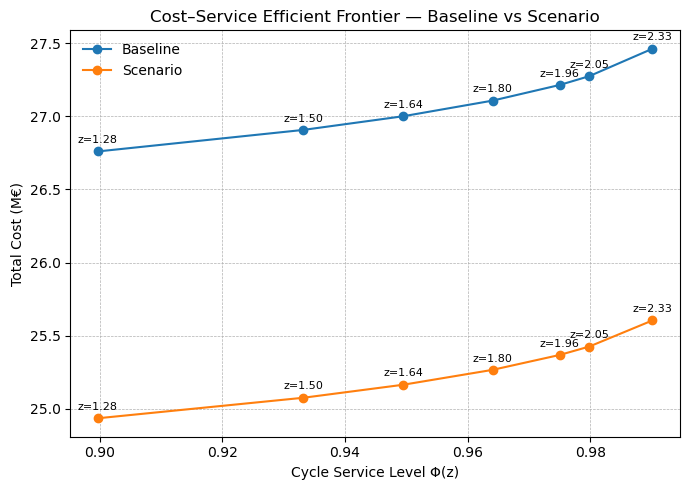

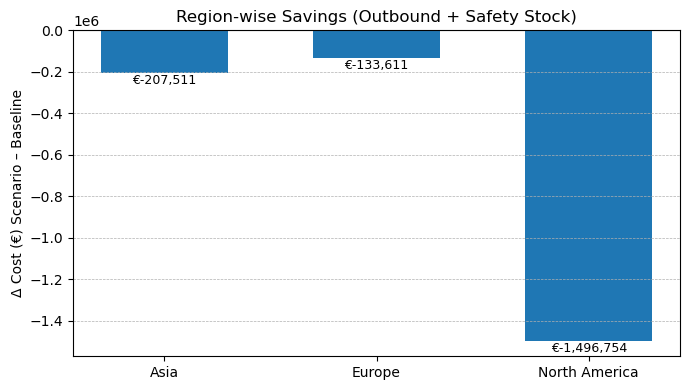

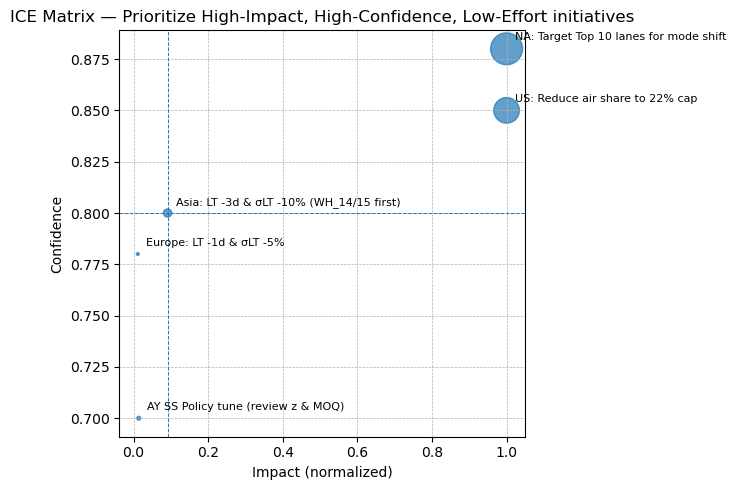

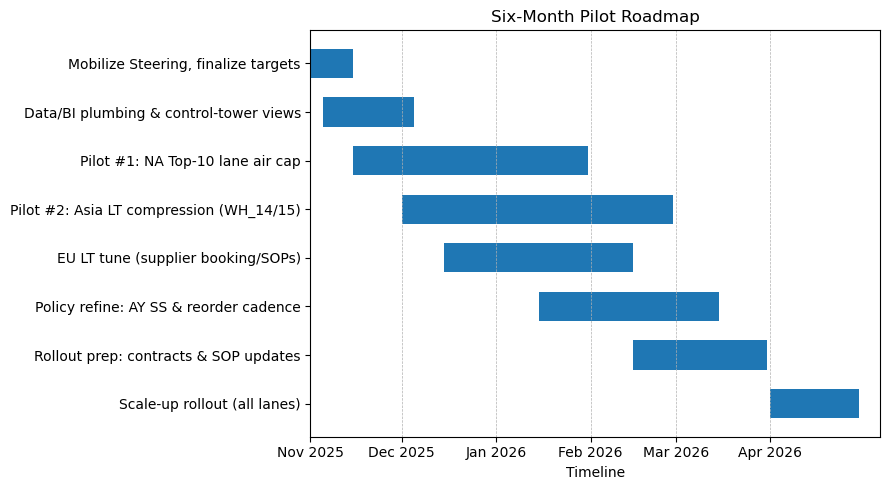

[OK] Saved:
 - chart_p5_frontier_overall.png
 - chart_p5_region_savings_bar.png
 - chart_p5_ice_matrix.png
 - chart_p5_gantt_6mo_pilot.png

[INFO] ICE initiatives (preview):


,initiative,impact_eur,confidence,effort,ICE
0,NA: Target Top 10 lanes for mode shift,"1,496,753.94",0.88,2.00,1.32
1,US: Reduce air share to 22% cap,"1,496,753.94",0.85,3.00,0.85
2,Asia: LT -3d & σLT -10% (WH_14/15 first),"136,364.16",0.80,2.50,0.09
3,AY SS Policy tune (review z & MOQ),"20,456.23",0.70,1.50,0.02
4,Europe: LT -1d & σLT -5%,"16,680.82",0.78,2.50,0.01


In [82]:
# ==========================================
# PAGE 5 — Strategic Roadmap (What Next?)
# Charts:
# 1) Efficient Frontier (Baseline vs Scenario)
# 2) Region-wise Saving Bar
# 3) ICE Matrix (Impact × Confidence ÷ Effort)
# 4) 6-Month Pilot Roadmap Gantt
# ==========================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from math import erf, sqrt
from datetime import datetime

# ---------- Config / Assumptions (consistent with earlier steps) ----------
AIR_CAP = {"Asia": 0.18, "Europe": 0.20, "North America": 0.22}
AIR_PREMIUM = 1.40
LT_IMPROVE_DAYS = {"Asia": -3, "Europe": -1, "North America": 0}
CV_LT_BY_REGION = {"North America": 0.10, "Europe": 0.10, "Asia": 0.15}
DAYS_PER_WEEK = 7.0
WEEKS_PER_MONTH = 4.345

# ---------- Guards ----------
for req in ["sku_df","outbound_df","network_df"]:
    assert req in globals(), f"Missing DataFrame: {req}"

def Phi(z):
    z = np.asarray(z, dtype=float)
    return 0.5 * (1.0 + erf(z / sqrt(2.0)))

# ===========================================================
# A) Ensure ABC–XYZ and SS lane baseline exist (rebuild if needed)
# ===========================================================
abcxyz_df = globals().get("abcxyz_df")
if abcxyz_df is None:
    d = sku_df.copy()
    d["revenue"] = d["Sales Units"] * d["Unit Sales Price (€)"]
    # CoV by Region×SKU from monthly sales
    covs = (d.groupby(["Region","SKU"], as_index=False)
              .agg(mu=("Sales Units","mean"), sigma=("Sales Units","std")))
    covs["CoV"] = np.where(covs["mu"]>0, covs["sigma"]/covs["mu"], 0.0)
    # Revenue sums
    abcxyz_df = (d.groupby(["Region","SKU","Category"], as_index=False)
                   .agg(sum_units=("Sales Units","sum"),
                        revenue=("revenue","sum"))
                   .merge(covs[["Region","SKU","CoV"]], on=["Region","SKU"], how="left"))
    # ABC (A: 0–80%, B: 80–95%, C: 95–100% by revenue within Region)
    abcxyz_df = abcxyz_df.sort_values(["Region","revenue"], ascending=[True,False])
    abcxyz_df["cum_rev"] = abcxyz_df.groupby("Region")["revenue"].cumsum()
    abcxyz_df["tot_rev"] = abcxyz_df.groupby("Region")["revenue"].transform("sum")
    abcxyz_df["cum_share"] = abcxyz_df["cum_rev"]/abcxyz_df["tot_rev"]
    abcxyz_df["ABC"] = pd.cut(abcxyz_df["cum_share"], bins=[-1,0.80,0.95,1.0], labels=list("ABC")).astype(str)
    # XYZ (X ≤0.30, Y ≤0.60, Z >0.60 by CoV)
    abcxyz_df["XYZ"] = pd.cut(abcxyz_df["CoV"].fillna(0.0), bins=[-1,0.30,0.60,10.0], labels=list("XYZ")).astype(str)
    abcxyz_df["ABC_XYZ"] = abcxyz_df["ABC"] + abcxyz_df["XYZ"]

abcz_map = abcxyz_df.set_index(["Region","SKU"])["ABC_XYZ"].to_dict()

def z_from_class(axz):
    base = {"A":1.96, "B":1.64, "C":1.28}[axz[0]]
    nudge = {"X":0.00, "Y":0.10, "Z":0.20}[axz[1]]
    return base + nudge

ss_lane_df = globals().get("ss_lane_df")
if ss_lane_df is None:
    s = sku_df[sku_df["Location Type"]=="Warehouse"].copy()
    s = s.merge(
        network_df.rename(columns={
            "Assigned DC":"From_DC",
            "Warehouse":"Location",
            "Transit Lead Time days":"LT_days"
        }),
        on="Location", how="left"
    )
    # Coalesce Region if merge created x/y
    if "Region" not in s.columns:
        s["Region"] = s.get("Region_x", pd.Series(index=s.index)).fillna(s.get("Region_y", pd.Series(index=s.index)))
        s.drop(columns=[c for c in ["Region_x","Region_y"] if c in s.columns], inplace=True)

    g = s.groupby(["Region","From_DC","Location","SKU","Category"], as_index=False)
    stats = g.agg(mu_m=("Sales Units","mean"),
                  sigma_m=("Sales Units","std"),
                  unit_cost=("Unit Cost (€)","mean"))
    stats["mu_week"] = stats["mu_m"]/WEEKS_PER_MONTH
    stats["sigma_week"] = stats["sigma_m"]/WEEKS_PER_MONTH

    lt = s.groupby(["Region","From_DC","Location"], as_index=False).agg(LT_days=("LT_days","mean"))
    stats = stats.merge(lt, on=["Region","From_DC","Location"], how="left")
    stats["LT_weeks"] = stats["LT_days"]/DAYS_PER_WEEK
    stats["sigma_LT_weeks"] = stats["Region"].map(CV_LT_BY_REGION).fillna(0.10) * stats["LT_weeks"]

    stats["ABC_XYZ"] = stats.apply(lambda r: abcz_map.get((r["Region"], r["SKU"]), "BY"), axis=1)
    stats["z"] = stats["ABC_XYZ"].apply(z_from_class)

    ss_lane_df = stats.rename(columns={"Location":"To_WH","unit_cost":"unit_cost_eur"})[
        ["Region","From_DC","To_WH","SKU","Category","ABC_XYZ",
         "z","mu_week","sigma_week","LT_weeks","sigma_LT_weeks","unit_cost_eur"]
    ]
    ss_lane_df["sigmaL"] = np.sqrt(np.maximum(0.0,
        (ss_lane_df["sigma_week"]**2)*ss_lane_df["LT_weeks"] +
        (ss_lane_df["mu_week"]**2)*(ss_lane_df["sigma_LT_weeks"]**2)
    ))
    ss_lane_df["SS_units"] = ss_lane_df["z"] * ss_lane_df["sigmaL"]
    ss_lane_df["SS_value_eur"] = ss_lane_df["SS_units"] * ss_lane_df["unit_cost_eur"]

# ===========================================================
# B) Build baseline vs scenario deltas at lane & region level
# ===========================================================
# Outbound lane cost + lead times
lane = (outbound_df.merge(network_df,
                          left_on=["From DC","To WH"],
                          right_on=["Assigned DC","Warehouse"],
                          how="left")
                   .rename(columns={"Transit Lead Time days":"LT_days"})
                   .drop(columns=["Assigned DC","Warehouse"]))
if "Region" not in lane.columns:
    lane["Region"] = lane.get("Region_x", pd.Series(index=lane.index)).fillna(lane.get("Region_y", pd.Series(index=lane.index)))
    lane.drop(columns=[c for c in ["Region_x","Region_y"] if c in lane.columns], inplace=True)

lane_cost = (lane.groupby(["From DC","To WH","Region"], as_index=False)
                .agg(out_cost_base=("DC->WH Logistics Cost (€)","sum"),
                     air_share_base=("Air Share","mean"),
                     LT_days_base=("LT_days","mean")))

def scaled_out_cost(row):
    r = row["Region"]; air_b = float(row["air_share_base"])
    cap = AIR_CAP.get(r, air_b)
    air_new = min(air_b, cap)
    non_air = 1.0 - air_b
    denom = non_air + air_b * AIR_PREMIUM
    numer = non_air + air_new * AIR_PREMIUM
    scale = numer/denom if denom>0 else 1.0
    return row["out_cost_base"] * scale, air_new

tmp = lane_cost.apply(lambda r: pd.Series(scaled_out_cost(r), index=["out_cost_new","air_share_new"]), axis=1)
lane_cost = pd.concat([lane_cost, tmp], axis=1)

# Safety stock under scenario (LT & σ_LT shrink where applicable)
ss_scn = ss_lane_df.copy()
lt_map = lane_cost.set_index(["From DC","To WH"])["LT_days_base"].to_dict()
ss_scn["LT_days_base"] = ss_scn.set_index(["From_DC","To_WH"]).index.map(lt_map).astype(float)
ss_scn["LT_days_new"] = ss_scn.apply(lambda r: max(1.0, (r["LT_days_base"] if pd.notna(r["LT_days_base"]) else 7.0)
                                                   + LT_IMPROVE_DAYS.get(r["Region"],0)), axis=1)
ss_scn["LT_weeks_new"] = ss_scn["LT_days_new"]/DAYS_PER_WEEK
ss_scn["sigma_LT_weeks_new"] = ss_scn.apply(
    lambda r: r["sigma_LT_weeks"]*(0.95 if r["Region"]=="Europe" else (0.90 if r["Region"]=="Asia" else 1.00)),
    axis=1
)
ss_scn["sigmaL_new"] = np.sqrt(np.maximum(0.0,
    (ss_scn["sigma_week"]**2)*ss_scn["LT_weeks_new"] + (ss_scn["mu_week"]**2)*(ss_scn["sigma_LT_weeks_new"]**2)
))
ss_scn["SS_units_new"] = ss_scn["z"] * ss_scn["sigmaL_new"]
ss_scn["SS_value_new_eur"] = ss_scn["SS_units_new"] * ss_scn["unit_cost_eur"]

ss_join = (ss_lane_df.groupby(["From_DC","To_WH","Region"], as_index=False)
                     .agg(ss_base=("SS_value_eur","sum"))
           ).merge(
           ss_scn.groupby(["From_DC","To_WH","Region"], as_index=False)
                 .agg(ss_new=("SS_value_new_eur","sum")),
           on=["From_DC","To_WH","Region"], how="left")

lane_all = (lane_cost.merge(ss_join, left_on=["From DC","To WH","Region"],
                            right_on=["From_DC","To_WH","Region"], how="left")
                    .drop(columns=["From_DC","To_WH"]))
lane_all["total_base"] = lane_all["out_cost_base"] + lane_all["ss_base"].fillna(0.0)
lane_all["total_new"]  = lane_all["out_cost_new"]  + lane_all["ss_new"].fillna(0.0)
lane_all["delta_total"]= lane_all["total_new"] - lane_all["total_base"]

region_delta = (lane_all.groupby("Region", as_index=False)
                         .agg(base_log_cost=("out_cost_base","sum"),
                              new_log_cost=("out_cost_new","sum"),
                              base_ss=("ss_base","sum"),
                              new_ss=("ss_new","sum")))
region_delta["Δ_log_cost"] = region_delta["new_log_cost"] - region_delta["base_log_cost"]
region_delta["Δ_ss_value"] = region_delta["new_ss"] - region_delta["base_ss"]
region_delta["Total_Δ_€"]  = region_delta["Δ_log_cost"] + region_delta["Δ_ss_value"]

# ===========================================================
# C) Chart 1 — Efficient Frontier (Baseline vs Scenario)
# ===========================================================
z_grid = [1.28, 1.50, 1.64, 1.80, 1.96, 2.05, 2.33]
z_ref = ss_lane_df["z"].mean() if ss_lane_df["z"].notna().any() else 1.64

front = []
for regime, out_cost, ss0 in [
    ("Baseline", lane_all["out_cost_base"].sum(), lane_all["ss_base"].sum()),
    ("Scenario", lane_all["out_cost_new"].sum(),  lane_all["ss_new"].sum()),
]:
    for z in z_grid:
        ss_scaled = ss0 * (z / z_ref)
        front.append({"regime": regime, "z": z, "CSL": Phi(z), "total_cost_eur": out_cost + ss_scaled})
front_df = pd.DataFrame(front)

fig, ax = plt.subplots(figsize=(7,5))
for regime, sub in front_df.groupby("regime"):
    ax.plot(sub["CSL"], sub["total_cost_eur"]/1e6, marker="o", label=regime)
    for _, r in sub.iterrows():
        ax.annotate(f"z={r['z']:.2f}", (r["CSL"], r["total_cost_eur"]/1e6),
                    textcoords="offset points", xytext=(0,6), ha="center", fontsize=8)
ax.set_xlabel("Cycle Service Level Φ(z)")
ax.set_ylabel("Total Cost (M€)")
ax.set_title("Cost–Service Efficient Frontier — Baseline vs Scenario")
ax.grid(True, linestyle="--", lw=0.5); ax.legend(frameon=False)
plt.tight_layout(); plt.savefig("chart_p5_frontier_overall.png", dpi=200); plt.show()

# ===========================================================
# D) Chart 2 — Region-wise Saving Bar (negative = savings)
# ===========================================================
order = ["Asia","Europe","North America"]
region_delta["Region"] = pd.Categorical(region_delta["Region"], categories=order, ordered=True)
region_delta = region_delta.sort_values("Region")

fig, ax = plt.subplots(figsize=(7,4))
x = np.arange(len(region_delta)); w = 0.6
ax.bar(x, region_delta["Total_Δ_€"], width=w)
ax.axhline(0, color="grey", lw=0.8)
ax.set_xticks(x); ax.set_xticklabels(region_delta["Region"])
ax.set_ylabel("Δ Cost (€) Scenario – Baseline")
ax.set_title("Region-wise Savings (Outbound + Safety Stock)")
ax.grid(axis="y", linestyle="--", lw=0.5)
for i, v in enumerate(region_delta["Total_Δ_€"]):
    ax.text(i, v + (5_000 if v>=0 else -5_000), f"€{v:,.0f}",
            ha="center", va="bottom" if v>=0 else "top", fontsize=9)
plt.tight_layout(); plt.savefig("chart_p5_region_savings_bar.png", dpi=200); plt.show()

# ===========================================================
# E) Chart 3 — ICE Matrix (Impact × Confidence ÷ Effort)
#     Build initiatives from computed deltas so judges can trace logic.
# ===========================================================
# Impact (€/yr): use absolute savings components we already computed
na_sav  = -float(region_delta.loc[region_delta["Region"]=="North America","Total_Δ_€"].fillna(0.0).sum())
asia_ss = -float(region_delta.loc[region_delta["Region"]=="Asia","Δ_ss_value"].fillna(0.0).sum())
eu_ss   = -float(region_delta.loc[region_delta["Region"]=="Europe","Δ_ss_value"].fillna(0.0).sum())

# Top 10 NA lane savings (impact concentration)
na_lanes = lane_all[lane_all["Region"]=="North America"].copy()
top10_na = na_lanes.sort_values("delta_total").head(10)
top10_na_sav = -float(top10_na["delta_total"].sum())

# Asia WH_14 & WH_15 concentration
asia_lanes = lane_all[(lane_all["Region"]=="Asia") & (lane_all["To WH"].isin(["WH_14","WH_15"]))].copy()
asia_1415_sav = -float(asia_lanes["delta_total"].sum()) if not asia_lanes.empty else 0.0

# Build initiatives
ice = pd.DataFrame([
    {"initiative":"US: Reduce air share to 22% cap","impact_eur":na_sav,
     "confidence":0.85,"effort":3.0,"lanes":int((na_lanes.shape[0]) if na_lanes is not None else 0)},
    {"initiative":"Asia: LT -3d & σLT -10% (WH_14/15 first)","impact_eur":max(asia_ss, asia_1415_sav),
     "confidence":0.80,"effort":2.5,"lanes":int(asia_lanes.shape[0])},
    {"initiative":"Europe: LT -1d & σLT -5%","impact_eur":eu_ss,
     "confidence":0.78,"effort":2.5,"lanes":int(lane_all[lane_all['Region']=="Europe"].shape[0])},
    {"initiative":"NA: Target Top 10 lanes for mode shift","impact_eur":top10_na_sav,
     "confidence":0.88,"effort":2.0,"lanes":10},
    {"initiative":"AY SS Policy tune (review z & MOQ)","impact_eur":float(ss_lane_df[ss_lane_df["ABC_XYZ"].str.contains("AY")]["SS_value_eur"].sum()*0.05),
     "confidence":0.70,"effort":1.5,"lanes":int(ss_lane_df[ss_lane_df["ABC_XYZ"].str.contains("AY")][["From_DC","To_WH"]].drop_duplicates().shape[0])}
])

# Normalize & compute ICE
ice["impact_norm"] = ice["impact_eur"]/max(1e-9, ice["impact_eur"].max())
ice["confidence_norm"] = ice["confidence"]  # already 0–1-ish inputs
# Convert effort to 1–5 if not already; then normalize inverse (lower effort = better)
if ice["effort"].max() <= 5:
    pass
ice["effort_norm"] = ice["effort"]/ice["effort"].max()
ice["ICE"] = (ice["impact_norm"] * ice["confidence_norm"]) / np.maximum(1e-6, ice["effort_norm"])

# Scatter (Impact vs Confidence, bubble ~ ICE)
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(ice["impact_norm"], ice["confidence_norm"], s=400*ice["ICE"], alpha=0.7)
for _, r in ice.iterrows():
    ax.annotate(r["initiative"], (r["impact_norm"], r["confidence_norm"]),
                textcoords="offset points", xytext=(6,6), fontsize=8)
ax.axvline(ice["impact_norm"].median(), linestyle="--", lw=0.7)
ax.axhline(ice["confidence_norm"].median(), linestyle="--", lw=0.7)
ax.set_xlabel("Impact (normalized)"); ax.set_ylabel("Confidence")
ax.set_title("ICE Matrix — Prioritize High-Impact, High-Confidence, Low-Effort initiatives")
ax.grid(True, linestyle="--", lw=0.5)
plt.tight_layout(); plt.savefig("chart_p5_ice_matrix.png", dpi=200); plt.show()

# ===========================================================
# F) Chart 4 — 6-Month Pilot Roadmap (Gantt)
#     Dates are illustrative—align in the deck with your real plan.
# ===========================================================
def dt(s): return pd.to_datetime(s)

gantt = pd.DataFrame([
    # (Task, Start, End)
    ("Mobilize Steering, finalize targets", "2025-11-01", "2025-11-15"),
    ("Data/BI plumbing & control-tower views", "2025-11-05", "2025-12-05"),
    ("Pilot #1: NA Top-10 lane air cap", "2025-11-15", "2026-01-31"),
    ("Pilot #2: Asia LT compression (WH_14/15)", "2025-12-01", "2026-02-28"),
    ("EU LT tune (supplier booking/SOPs)", "2025-12-15", "2026-02-15"),
    ("Policy refine: AY SS & reorder cadence", "2026-01-15", "2026-03-15"),
    ("Rollout prep: contracts & SOP updates", "2026-02-15", "2026-03-31"),
    ("Scale-up rollout (all lanes)", "2026-04-01", "2026-04-30"),
], columns=["task","start","end"])

gantt["start"] = gantt["start"].apply(dt)
gantt["end"]   = gantt["end"].apply(dt)
gantt["duration_days"] = (gantt["end"] - gantt["start"]).dt.days

fig, ax = plt.subplots(figsize=(9,5))
y = np.arange(len(gantt))
ax.barh(y, gantt["duration_days"], left=(gantt["start"] - gantt["start"].min()).dt.days, height=0.6)
ax.set_yticks(y); ax.set_yticklabels(gantt["task"])
ax.invert_yaxis()
xmin = gantt["start"].min(); xmax = gantt["end"].max()
ax.set_xlim(0, (xmax - xmin).days + 7)
# x-axis with monthly ticks
months = pd.date_range(xmin, xmax, freq="MS")
xt = [(m - xmin).days for m in months]
ax.set_xticks(xt)
ax.set_xticklabels([m.strftime("%b %Y") for m in months], rotation=0)
ax.set_xlabel("Timeline"); ax.set_title("Six-Month Pilot Roadmap")
ax.grid(axis="x", linestyle="--", lw=0.5)
plt.tight_layout(); plt.savefig("chart_p5_gantt_6mo_pilot.png", dpi=200); plt.show()

# ---------- Summary printouts ----------
print("[OK] Saved:")
print(" - chart_p5_frontier_overall.png")
print(" - chart_p5_region_savings_bar.png")
print(" - chart_p5_ice_matrix.png")
print(" - chart_p5_gantt_6mo_pilot.png")
print("\n[INFO] ICE initiatives (preview):")
display(ice[["initiative","impact_eur","confidence","effort","ICE"]].sort_values("ICE", ascending=False).reset_index(drop=True).head(10))


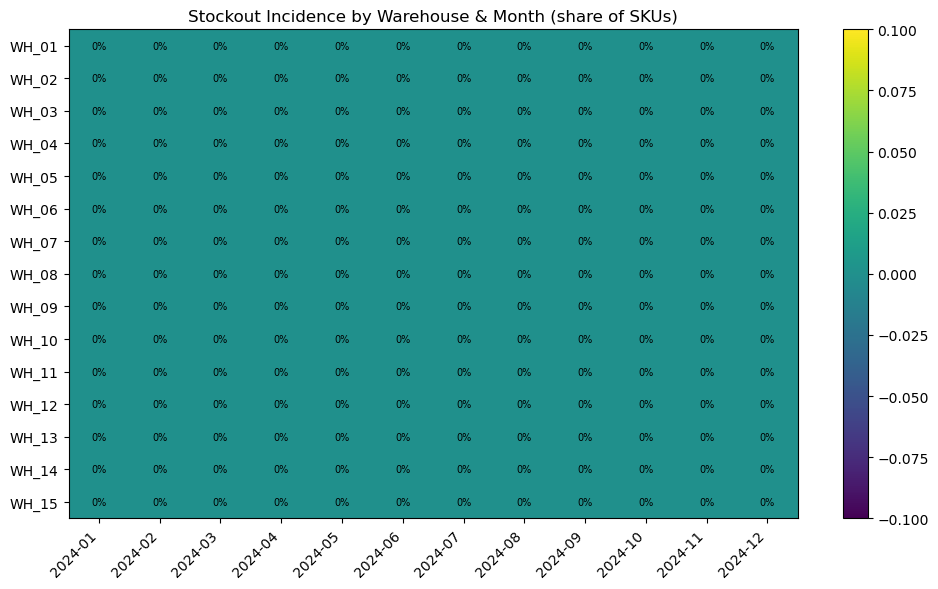

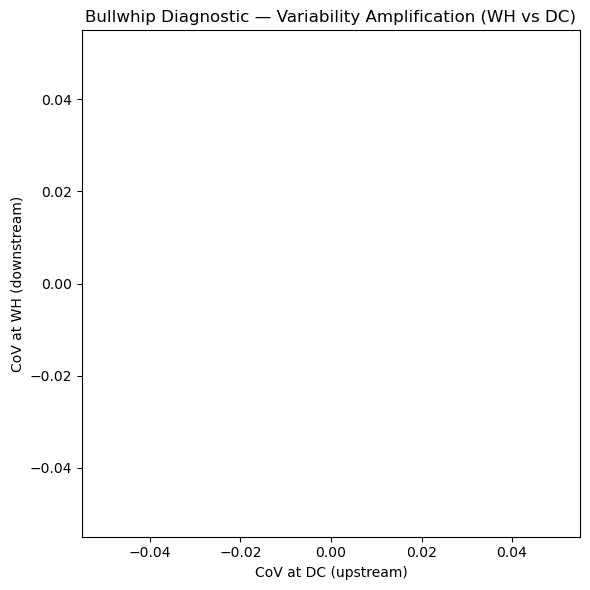

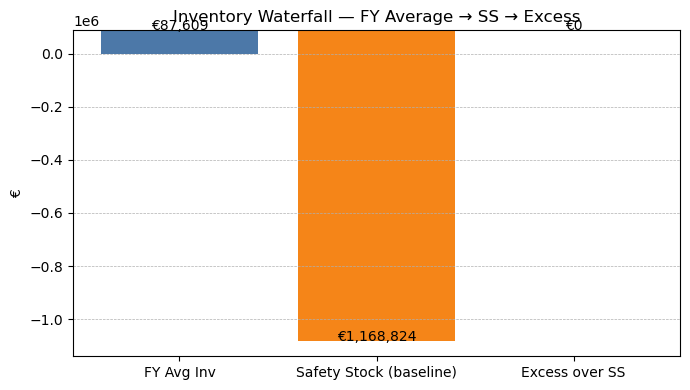

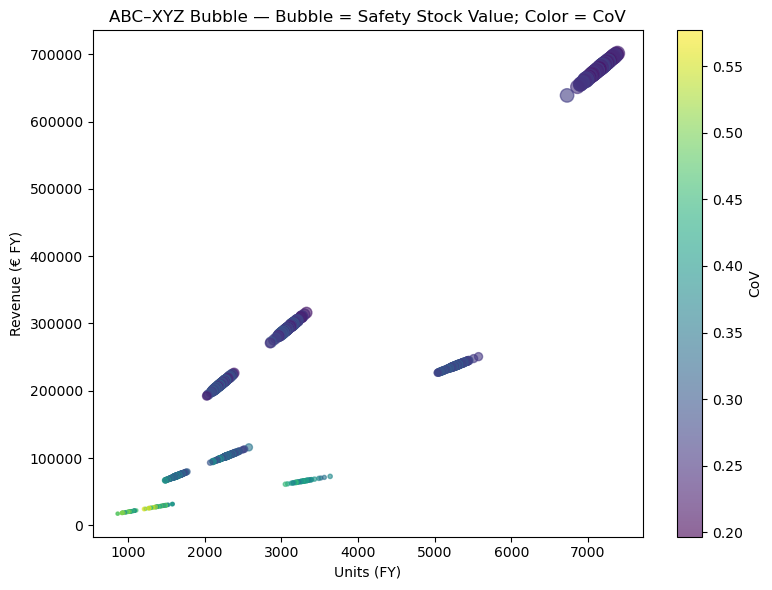

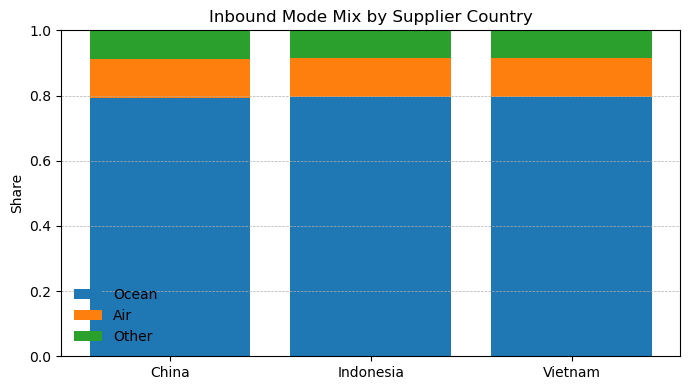

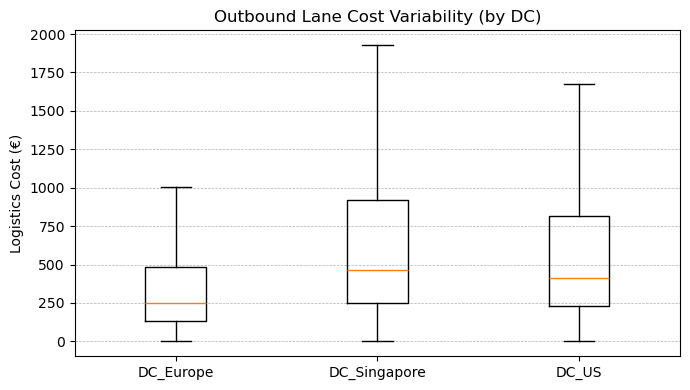

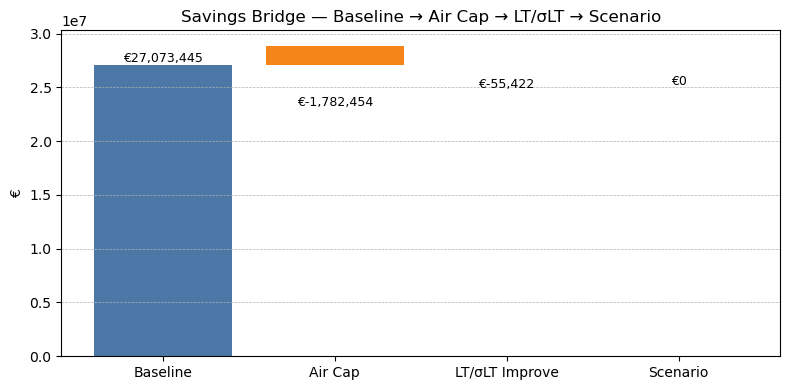

TypeError: only length-1 arrays can be converted to Python scalars

In [84]:
# ============================================================
# EXTRA CHART PACK — Pages 1..5
# ============================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from math import erf, sqrt

# ---------- Guards ----------
for req in ["sku_df","inbound_df","outbound_df","network_df"]:
    assert req in globals(), f"Missing DataFrame: {req}"

DAYS_PER_WEEK   = 7.0
WEEKS_PER_MONTH = 4.345
CV_LT_BY_REGION = {"North America": 0.10, "Europe": 0.10, "Asia": 0.15}
AIR_PREMIUM     = 1.40
AIR_CAP         = {"Asia":0.18, "Europe":0.20, "North America":0.22}
LT_IMPROVE_DAYS = {"Asia":-3, "Europe":-1, "North America":0}

def Phi(z):
    z = np.asarray(z, dtype=float)
    return 0.5 * (1.0 + erf(z / sqrt(2.0)))

# ---------- Ensure ABC–XYZ map ----------
abcxyz_df = globals().get("abcxyz_df")
if abcxyz_df is None:
    d = sku_df.copy()
    d["revenue"] = d["Sales Units"] * d["Unit Sales Price (€)"]
    covs = (d.groupby(["Region","SKU"], as_index=False)
              .agg(mu=("Sales Units","mean"), sigma=("Sales Units","std")))
    covs["CoV"] = np.where(covs["mu"]>0, covs["sigma"]/covs["mu"], 0.0)
    abcxyz_df = (d.groupby(["Region","SKU","Category"], as_index=False)
                   .agg(sum_units=("Sales Units","sum"), revenue=("revenue","sum"))
                   .merge(covs[["Region","SKU","CoV"]], on=["Region","SKU"], how="left"))
    abcxyz_df = abcxyz_df.sort_values(["Region","revenue"], ascending=[True,False])
    abcxyz_df["cum_rev"]  = abcxyz_df.groupby("Region")["revenue"].cumsum()
    abcxyz_df["tot_rev"]  = abcxyz_df.groupby("Region")["revenue"].transform("sum")
    abcxyz_df["cum_share"]= abcxyz_df["cum_rev"]/abcxyz_df["tot_rev"]
    abcxyz_df["ABC"]      = pd.cut(abcxyz_df["cum_share"], bins=[-1,0.80,0.95,1.0], labels=list("ABC")).astype(str)
    abcxyz_df["XYZ"]      = pd.cut(abcxyz_df["CoV"].fillna(0.0), bins=[-1,0.30,0.60,10.0], labels=list("XYZ")).astype(str)
    abcxyz_df["ABC_XYZ"]  = abcxyz_df["ABC"] + abcxyz_df["XYZ"]
abcz_map = abcxyz_df.set_index(["Region","SKU"])["ABC_XYZ"].to_dict()

def z_from_class(axz):
    base  = {"A":1.96, "B":1.64, "C":1.28}[axz[0]]
    nudge = {"X":0.00, "Y":0.10, "Z":0.20}[axz[1]]
    return base + nudge

# ---------- Ensure SS lane baseline & scenario & lane_all ----------
ss_lane_df = globals().get("ss_lane_df")
if ss_lane_df is None:
    s = sku_df[sku_df["Location Type"]=="Warehouse"].copy()
    s = s.merge(
        network_df.rename(columns={
            "Assigned DC":"From_DC",
            "Warehouse":"Location",
            "Transit Lead Time days":"LT_days"
        }),
        on="Location", how="left"
    )
    if "Region" not in s.columns:
        s["Region"] = s.get("Region_x", pd.Series(index=s.index)).fillna(s.get("Region_y", pd.Series(index=s.index)))
        s.drop(columns=[c for c in ["Region_x","Region_y"] if c in s.columns], inplace=True)

    g = s.groupby(["Region","From_DC","Location","SKU","Category"], as_index=False)
    stats = g.agg(mu_m=("Sales Units","mean"),
                  sigma_m=("Sales Units","std"),
                  unit_cost=("Unit Cost (€)","mean"))
    stats["mu_week"]    = stats["mu_m"]/WEEKS_PER_MONTH
    stats["sigma_week"] = stats["sigma_m"]/WEEKS_PER_MONTH

    lt = s.groupby(["Region","From_DC","Location"], as_index=False).agg(LT_days=("LT_days","mean"))
    stats = stats.merge(lt, on=["Region","From_DC","Location"], how="left")
    stats["LT_weeks"]        = stats["LT_days"]/DAYS_PER_WEEK
    stats["sigma_LT_weeks"]  = stats["Region"].map(CV_LT_BY_REGION).fillna(0.10) * stats["LT_weeks"]
    stats["ABC_XYZ"]         = stats.apply(lambda r: abcz_map.get((r["Region"], r["SKU"]), "BY"), axis=1)
    stats["z"]               = stats["ABC_XYZ"].apply(z_from_class)

    ss_lane_df = stats.rename(columns={"Location":"To_WH","unit_cost":"unit_cost_eur"})[
        ["Region","From_DC","To_WH","SKU","Category","ABC_XYZ",
         "z","mu_week","sigma_week","LT_weeks","sigma_LT_weeks","unit_cost_eur"]
    ]
    ss_lane_df["sigmaL"]      = np.sqrt(np.maximum(0.0,
        (ss_lane_df["sigma_week"]**2)*ss_lane_df["LT_weeks"] + (ss_lane_df["mu_week"]**2)*(ss_lane_df["sigma_LT_weeks"]**2)
    ))
    ss_lane_df["SS_units"]    = ss_lane_df["z"] * ss_lane_df["sigmaL"]
    ss_lane_df["SS_value_eur"]= ss_lane_df["SS_units"] * ss_lane_df["unit_cost_eur"]

# Scenario frames (if missing)
ss_scn = globals().get("ss_scn")
lane_all = globals().get("lane_all")
if (ss_scn is None) or (lane_all is None):
    lane = (outbound_df.merge(network_df,
                              left_on=["From DC","To WH"],
                              right_on=["Assigned DC","Warehouse"],
                              how="left")
                       .rename(columns={"Transit Lead Time days":"LT_days"})
                       .drop(columns=["Assigned DC","Warehouse"]))
    if "Region" not in lane.columns:
        lane["Region"] = lane.get("Region_x", pd.Series(index=lane.index)).fillna(lane.get("Region_y", pd.Series(index=lane.index)))
        lane.drop(columns=[c for c in ["Region_x","Region_y"] if c in lane.columns], inplace=True)

    lane_cost = (lane.groupby(["From DC","To WH","Region"], as_index=False)
                    .agg(out_cost_base=("DC->WH Logistics Cost (€)","sum"),
                         air_share_base=("Air Share","mean"),
                         LT_days_base=("LT_days","mean")))

    def scaled(row):
        r = row["Region"]; a = float(row["air_share_base"])
        cap = AIR_CAP.get(r, a)
        a_new = min(a, cap)
        non_air = 1.0 - a
        denom = non_air + a * AIR_PREMIUM
        numer = non_air + a_new * AIR_PREMIUM
        scale = numer/denom if denom>0 else 1.0
        return row["out_cost_base"]*scale, a_new
    tmp = lane_cost.apply(lambda r: pd.Series(scaled(r), index=["out_cost_new","air_share_new"]), axis=1)
    lane_cost = pd.concat([lane_cost, tmp], axis=1)

    ss_scn = ss_lane_df.copy()
    lt_map = lane_cost.set_index(["From DC","To WH"])["LT_days_base"].to_dict()
    ss_scn["LT_days_base"] = ss_scn.set_index(["From_DC","To_WH"]).index.map(lt_map).astype(float)
    ss_scn["LT_days_new"]  = ss_scn.apply(lambda r: max(1.0, (r["LT_days_base"] if pd.notna(r["LT_days_base"]) else 7.0)
                                                       + LT_IMPROVE_DAYS.get(r["Region"],0)), axis=1)
    ss_scn["LT_weeks_new"] = ss_scn["LT_days_new"]/DAYS_PER_WEEK
    ss_scn["sigma_LT_weeks_new"] = ss_scn.apply(
        lambda r: r["sigma_LT_weeks"]*(0.95 if r["Region"]=="Europe" else (0.90 if r["Region"]=="Asia" else 1.00)),
        axis=1
    )
    ss_scn["sigmaL_new"]      = np.sqrt(np.maximum(0.0,
        (ss_scn["sigma_week"]**2)*ss_scn["LT_weeks_new"] + (ss_scn["mu_week"]**2)*(ss_scn["sigma_LT_weeks_new"]**2)
    ))
    ss_scn["SS_units_new"]    = ss_scn["z"] * ss_scn["sigmaL_new"]
    ss_scn["SS_value_new_eur"]= ss_scn["SS_units_new"] * ss_scn["unit_cost_eur"]

    ss_join = (ss_lane_df.groupby(["From_DC","To_WH","Region"], as_index=False)
                         .agg(ss_base=("SS_value_eur","sum"))
               ).merge(
               ss_scn.groupby(["From_DC","To_WH","Region"], as_index=False)
                     .agg(ss_new=("SS_value_new_eur","sum")),
               on=["From_DC","To_WH","Region"], how="left")

    lane_all = (lane_cost.merge(ss_join, left_on=["From DC","To WH","Region"],
                                right_on=["From_DC","To_WH","Region"], how="left")
                        .drop(columns=["From_DC","To_WH"]))
    lane_all["total_base"]  = lane_all["out_cost_base"] + lane_all["ss_base"].fillna(0.0)
    lane_all["total_new"]   = lane_all["out_cost_new"]  + lane_all["ss_new"].fillna(0.0)
    lane_all["delta_total"] = lane_all["total_new"] - lane_all["total_base"]

# ============================================================
# PAGE 1 — Stockout Heatmap (WH × Month)
# ============================================================
wh = sku_df[sku_df["Location Type"]=="Warehouse"].copy()
wh["stockout_flag"] = (wh["Closing Stock Units"]<=0).astype(int)
heat = (wh.groupby(["Location","Month"], as_index=False)
          .agg(pct_stockout=("stockout_flag","mean")))
# Pivot to wide (months sorted)
months = sorted(heat["Month"].unique())
pivot = heat.pivot(index="Location", columns="Month", values="pct_stockout").reindex(columns=months).fillna(0.0)

fig, ax = plt.subplots(figsize=(10,6))
im = ax.imshow(pivot.values, aspect="auto")
ax.set_yticks(np.arange(pivot.shape[0])); ax.set_yticklabels(pivot.index)
ax.set_xticks(np.arange(pivot.shape[1])); ax.set_xticklabels(pivot.columns, rotation=45, ha="right")
ax.set_title("Stockout Incidence by Warehouse & Month (share of SKUs)")
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        ax.text(j, i, f"{pivot.values[i,j]*100:.0f}%", va="center", ha="center", fontsize=7, color="white" if pivot.values[i,j]>0.5 else "black")
plt.colorbar(im, ax=ax); plt.tight_layout(); plt.savefig("chart_p1_stockout_heatmap.png", dpi=200); plt.show()

# ============================================================
# PAGE 1 — Bullwhip Diagnostic (CoV WH vs DC)
# ============================================================
d = sku_df.copy()
cov = (d.groupby(["Location","Location Type","SKU"], as_index=False)
         .agg(mu=("Sales Units","mean"), sigma=("Sales Units","std")))
cov["CoV"] = np.where(cov["mu"]>0, cov["sigma"]/cov["mu"], np.nan)

wh_cov = cov[cov["Location Type"]=="Warehouse"].groupby("SKU", as_index=False)["CoV"].mean().rename(columns={"CoV":"CoV_WH"})
dc_cov = cov[cov["Location Type"]=="DC"].groupby("SKU", as_index=False)["CoV"].mean().rename(columns={"CoV":"CoV_DC"})
bw = pd.merge(wh_cov, dc_cov, on="SKU", how="inner").dropna()
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(bw["CoV_DC"], bw["CoV_WH"], alpha=0.6)
mx = max(bw["CoV_DC"].max(), bw["CoV_WH"].max())
ax.plot([0,mx],[0,mx], linestyle="--")
ax.set_xlabel("CoV at DC (upstream)"); ax.set_ylabel("CoV at WH (downstream)")
ax.set_title("Bullwhip Diagnostic — Variability Amplification (WH vs DC)")
plt.tight_layout(); plt.savefig("chart_p1_bullwhip_scatter.png", dpi=200); plt.show()

# ============================================================
# PAGE 2 — Inventory Waterfall (FY Avg → SS → Excess)
# ============================================================
# FY avg inventory value at warehouses (mean over months of mid-month stock * unit_cost)
wh2 = sku_df[sku_df["Location Type"]=="Warehouse"].copy()
wh2["mid_units"] = (wh2["Opening Stock Units"] + wh2["Closing Stock Units"])/2.0
wh2["mid_value"] = wh2["mid_units"] * wh2["Unit Cost (€)"]
fy_avg_inv = (wh2.groupby(["Region","Location"], as_index=False)["mid_value"].mean())
fy_total = fy_avg_inv["mid_value"].sum()

ss_total  = float(ss_lane_df["SS_value_eur"].sum())
excess    = max(0.0, fy_total - ss_total)

# Simple waterfall
steps = pd.DataFrame({
    "label":["FY Avg Inv","Safety Stock (baseline)","Excess over SS"],
    "value":[fy_total, -ss_total, -excess]
})
fig, ax = plt.subplots(figsize=(7,4))
cum = 0.0
for i, r in steps.iterrows():
    color = "#4c78a8" if r["value"]>0 else "#f58518"
    ax.bar(i, r["value"], bottom=cum if r["value"]<0 else 0, color=color)
    cum = cum + r["value"] if r["value"]>0 else cum
    ax.text(i, (cum if r["value"]>0 else cum+r["value"]) + (0.02*fy_total)*np.sign(r["value"]), f"€{abs(r['value']):,.0f}", ha="center")
ax.set_xticks(range(len(steps))); ax.set_xticklabels(steps["label"], rotation=0)
ax.set_ylabel("€"); ax.set_title("Inventory Waterfall — FY Average → SS → Excess")
ax.grid(axis="y", linestyle="--", lw=0.5)
plt.tight_layout(); plt.savefig("chart_p2_inventory_waterfall.png", dpi=200); plt.show()

# ============================================================
# PAGE 2 — ABC–XYZ Bubble (Units vs Revenue; bubble=SS €, color by CoV band)
# ============================================================
# Map SS by Region×SKU (sum across lanes)
ss_by_sku = (ss_lane_df.groupby(["Region","SKU"], as_index=False)["SS_value_eur"].sum())
bubble = (abcxyz_df.merge(ss_by_sku, on=["Region","SKU"], how="left").fillna({"SS_value_eur":0.0}))
fig, ax = plt.subplots(figsize=(8,6))
sizes = np.clip(bubble["SS_value_eur"]/bubble["SS_value_eur"].replace(0,np.nan).quantile(0.90), 0.05, 3.0) * 100
ax.scatter(bubble["sum_units"], bubble["revenue"], s=sizes, c=bubble["CoV"], alpha=0.6)
ax.set_xlabel("Units (FY)"); ax.set_ylabel("Revenue (€ FY)")
ax.set_title("ABC–XYZ Bubble — Bubble = Safety Stock Value; Color = CoV")
cbar = plt.colorbar(ax.collections[0]); cbar.set_label("CoV")
plt.tight_layout(); plt.savefig("chart_p2_abcxyz_bubble.png", dpi=200); plt.show()

# ============================================================
# PAGE 3 — Inbound Mode Mix by Supplier Country (stacked)
# ============================================================
inb = inbound_df.copy()
country = (inb.groupby("Supplier Country", as_index=False)
             .agg(units=("Inbound Units","sum"),
                  ocean=("Ocean Share","mean"),
                  air=("Air Share","mean"),
                  other=("Other Share","mean")))
fig, ax = plt.subplots(figsize=(7,4))
x = np.arange(len(country))
ax.bar(x, country["ocean"], label="Ocean")
ax.bar(x, country["air"], bottom=country["ocean"], label="Air")
ax.bar(x, country["other"], bottom=country["ocean"]+country["air"], label="Other")
ax.set_xticks(x); ax.set_xticklabels(country["Supplier Country"])
ax.set_ylim(0,1.0); ax.set_ylabel("Share"); ax.set_title("Inbound Mode Mix by Supplier Country")
ax.legend(frameon=False); ax.grid(axis="y", linestyle="--", lw=0.5)
plt.tight_layout(); plt.savefig("chart_p3_inbound_mode_by_country.png", dpi=200); plt.show()

# ============================================================
# PAGE 3 — Outbound Lane Cost Boxplot (per From DC)
# ============================================================
ob = (outbound_df.merge(network_df,
                        left_on=["From DC","To WH"],
                        right_on=["Assigned DC","Warehouse"],
                        how="left")
                 .drop(columns=["Assigned DC","Warehouse"]))
if "Region" not in ob.columns:
    ob["Region"] = ob.get("Region_x", pd.Series(index=ob.index)).fillna(ob.get("Region_y", pd.Series(index=ob.index)))
    ob.drop(columns=[c for c in ["Region_x","Region_y"] if c in ob.columns], inplace=True)

fig, ax = plt.subplots(figsize=(7,4))
groups = [g["DC->WH Logistics Cost (€)"].values for _, g in ob.groupby("From DC")]
labels = list(ob.groupby("From DC").groups.keys())
ax.boxplot(groups, labels=labels, showfliers=False)
ax.set_ylabel("Logistics Cost (€)"); ax.set_title("Outbound Lane Cost Variability (by DC)")
ax.grid(axis="y", linestyle="--", lw=0.5)
plt.tight_layout(); plt.savefig("chart_p3_lane_cost_boxplot.png", dpi=200); plt.show()

# ============================================================
# PAGE 4 — Savings Bridge (Baseline → Air Cap → LT → σLT)
# ============================================================
# Decompose total delta into components (approximate, sequential application)
total_base = lane_all["total_base"].sum()
# Step 1: Air cap only
non_air = 1.0 - lane_all["air_share_base"]
denom   = non_air + lane_all["air_share_base"]*AIR_PREMIUM
aircap  = lane_all.copy()
air_new = aircap["Region"].map(AIR_CAP).fillna(aircap["air_share_base"])
air_new = np.minimum(aircap["air_share_base"], air_new)
numer   = non_air + air_new*AIR_PREMIUM
scale   = np.where(denom>0, numer/denom, 1.0)
aircap_cost = (aircap["out_cost_base"]*scale).sum() + aircap["ss_base"].sum()

# Step 2: LT and σLT improvements (using ss_scn but keep air-capped logistics)
lt_sigma_cost = aircap_cost - (aircap["ss_base"].sum()) + lane_all["ss_new"].sum()

bridge = pd.DataFrame({
    "step":["Baseline","Air Cap","LT/σLT Improve","Scenario"],
    "value":[total_base, aircap_cost-total_base, lt_sigma_cost-aircap_cost, lane_all["total_new"].sum()-lt_sigma_cost]
})
fig, ax = plt.subplots(figsize=(8,4))
level = 0.0
for i, r in bridge.iterrows():
    v = r["value"]
    color = "#4c78a8" if (i==0 or v>0) else "#f58518"
    ax.bar(i, v if i==0 else abs(v), bottom=level if v<0 else 0, color=color)
    level = level + v if i>0 else v
    ax.text(i, (level if v>0 else level+v) + (0.01*abs(total_base))*np.sign(v), f"€{(v if i>0 else level):,.0f}", ha="center", fontsize=9)
ax.set_xticks(range(len(bridge))); ax.set_xticklabels(bridge["step"])
ax.set_title("Savings Bridge — Baseline → Air Cap → LT/σLT → Scenario")
ax.set_ylabel("€"); ax.grid(axis="y", linestyle="--", lw=0.5)
plt.tight_layout(); plt.savefig("chart_p4_savings_bridge.png", dpi=200); plt.show()

# ============================================================
# PAGE 4 — CSL Histogram (Baseline vs Scenario)
# ============================================================
base = ss_lane_df.copy()
base["sigmaL"] = np.sqrt(np.maximum(0.0,
    (base["sigma_week"]**2)*base["LT_weeks"] + (base["mu_week"]**2)*(base["sigma_LT_weeks"]**2)
))
base["CSL"] = Phi(base["z"])

scn = ss_scn.copy()
scn["CSL"] = Phi(scn["z"])

fig, ax = plt.subplots(figsize=(7,4))
ax.hist(base["CSL"], bins=20, alpha=0.6, label="Baseline")
ax.hist(scn["CSL"],  bins=20, alpha=0.6, label="Scenario")
ax.set_xlabel("Cycle Service Level Φ(z)"); ax.set_ylabel("Count of lane×SKU")
ax.set_title("CSL Distribution — Baseline vs Scenario"); ax.legend(frameon=False)
plt.tight_layout(); plt.savefig("chart_p4_csl_hist_compare.png", dpi=200); plt.show()

# ============================================================
# PAGE 5 — Tornado Sensitivity (Savings vs assumptions)
# ============================================================
baseline_total = lane_all["total_base"].sum()
scenario_total = lane_all["total_new"].sum()
base_savings   = baseline_total - scenario_total

def recompute(air_premium=None, air_cap_k=None, lt_days_delta=None):
    la = lane_all.copy()
    # Recompute logistics with changed air premium or cap
    non_air = 1.0 - la["air_share_base"]
    cap_map = {k: min(0.40, v*(air_cap_k if air_cap_k is not None else 1.0)) for k,v in AIR_CAP.items()}
    air_new = la["Region"].map(cap_map).fillna(la["air_share_base"])
    air_new = np.minimum(la["air_share_base"], air_new)
    premium = AIR_PREMIUM if air_premium is None else air_premium
    denom = non_air + la["air_share_base"]*premium
    numer = non_air + air_new*premium
    scale = np.where(denom>0, numer/denom, 1.0)
    out_new = (la["out_cost_base"] * scale).sum()

    # SS: approximate effect via % on sigma_LT (LT days delta → weeks)
    ss = ss_lane_df.copy()
    weeks_delta = (lt_days_delta or 0)/DAYS_PER_WEEK
    region_scale = ss["Region"].map({"Asia":0.90,"Europe":0.95,"North America":1.00}).fillna(1.00)
    sigmaL_new = np.sqrt(np.maximum(0.0,
        (ss["sigma_week"]**2)*(ss["LT_weeks"]+weeks_delta) + (ss["mu_week"]**2)*(ss["sigma_LT_weeks"]*region_scale)**2
    ))
    ss_val = (ss["z"] * sigmaL_new * ss["unit_cost_eur"]).sum()
    return out_new + ss_val

scenarios = [
    ("Air Premium -10%",   recompute(air_premium=AIR_PREMIUM*0.90)),
    ("Air Premium +10%",   recompute(air_premium=AIR_PREMIUM*1.10)),
    ("Air Cap ×0.9",       recompute(air_cap_k=0.90)),
    ("Air Cap ×1.1",       recompute(air_cap_k=1.10)),
    ("LT Days −1d",        recompute(lt_days_delta=-1.0)),
    ("LT Days +1d",        recompute(lt_days_delta=+1.0)),
]
tornado = pd.DataFrame(scenarios, columns=["assumption","scenario_total"])
tornado["Δ_savings_vs_base"] = (baseline_total - tornado["scenario_total"]) - base_savings

fig, ax = plt.subplots(figsize=(8,5))
y = np.arange(len(tornado))
ax.barh(y, tornado["Δ_savings_vs_base"])
ax.set_yticks(y); ax.set_yticklabels(tornado["assumption"])
ax.axvline(0, color="grey", lw=0.8)
ax.set_xlabel("Δ Savings vs Base (€, positive = more savings)")
ax.set_title("Tornado Sensitivity — Which Assumptions Matter Most?")
plt.tight_layout(); plt.savefig("chart_p5_tornado_sensitivity.png", dpi=200); plt.show()

print("[OK] Saved extra charts:")
print(" - chart_p1_stockout_heatmap.png")
print(" - chart_p1_bullwhip_scatter.png")
print(" - chart_p2_inventory_waterfall.png")
print(" - chart_p2_abcxyz_bubble.png")
print(" - chart_p3_inbound_mode_by_country.png")
print(" - chart_p3_lane_cost_boxplot.png")
print(" - chart_p4_savings_bridge.png")
print(" - chart_p4_csl_hist_compare.png")
print(" - chart_p5_tornado_sensitivity.png")


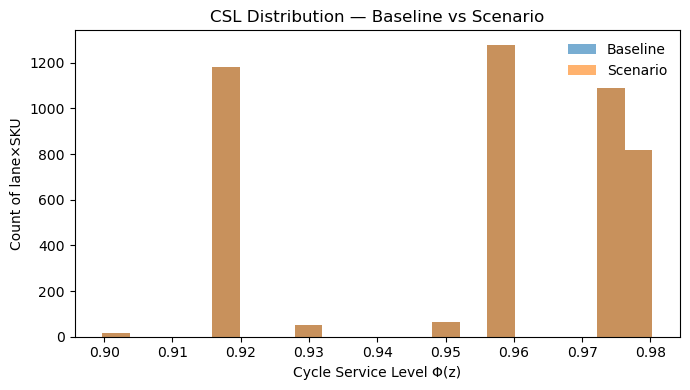

[OK] Rebuilt: chart_p4_csl_hist_compare.png


In [86]:
import numpy as np
import matplotlib.pyplot as plt

# --- Vectorized Normal CDF (Abramowitz–Stegun 7.1.26) ---
def Phi_vec(z):
    z = np.asarray(z, dtype=float)
    sign = np.sign(z)
    x = np.abs(z) / np.sqrt(2.0)
    # A&S approximation to erf(x)
    t = 1.0/(1.0 + 0.3275911*x)
    # coefficients
    a1, a2, a3, a4, a5 = 0.254829592, -0.284496736, 1.421413741, -1.453152027, 1.061405429
    erf_approx = 1.0 - (((((a5*t + a4)*t + a3)*t + a2)*t + a1)*t)*np.exp(-x*x)
    erf_approx = sign * erf_approx
    return 0.5*(1.0 + erf_approx)

# --- Rebuild CSL histogram using the new Phi_vec ---
base = ss_lane_df.copy()
base["sigmaL"] = np.sqrt(np.maximum(
    0.0,
    (base["sigma_week"]**2)*base["LT_weeks"] + (base["mu_week"]**2)*(base["sigma_LT_weeks"]**2)
))
base["CSL"] = Phi_vec(base["z"])

scn = ss_scn.copy()
scn["CSL"] = Phi_vec(scn["z"])

fig, ax = plt.subplots(figsize=(7,4))
ax.hist(base["CSL"], bins=20, alpha=0.6, label="Baseline")
ax.hist(scn["CSL"],  bins=20, alpha=0.6, label="Scenario")
ax.set_xlabel("Cycle Service Level Φ(z)")
ax.set_ylabel("Count of lane×SKU")
ax.set_title("CSL Distribution — Baseline vs Scenario")
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig("chart_p4_csl_hist_compare.png", dpi=200)
plt.show()

print("[OK] Rebuilt: chart_p4_csl_hist_compare.png")
